In [1]:
import pandas as pd
import numpy as np
import pickle
#https://pypi.org/project/geopy/
from geopy.geocoders import Nominatim

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# built in api 
import foursquare as fs

import requests
from bs4 import BeautifulSoup
from pandas import json_normalize

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

---
# Foursquare Data Pull

In [4]:
inputLocation = 'Chicago, IL'

def get_coords(inputLocation):
    geolocator = Nominatim(user_agent="my_user_agent")
    location = geolocator.geocode(inputLocation)
    latitude = location.latitude
    longitude = location.longitude
    latitude_str = str(location.latitude)
    longitude_str = str(location.longitude)
    ll = latitude_str + ',' + longitude_str
    return ll, latitude, longitude

get_coords(inputLocation)

('41.8755616,-87.6244212', 41.8755616, -87.6244212)

In [5]:
geolocator = Nominatim(user_agent="my_user_agent")
location = geolocator.geocode(inputLocation)
print(f'Location Address\n{location.address}\n')
print(f'Latitude & Longitude\n{(location.latitude, location.longitude)}\n')
# print(location.raw)

Location Address
Chicago, Cook County, Illinois, United States

Latitude & Longitude
(41.8755616, -87.6244212)



In [6]:
def foursquare_api():
    with open('foursquare_keys.txt', 'r') as f:
        CLIENT_ID, CLIENT_SECRET = [lines.strip() for lines in f.readlines()]

    # VERSION = '20180605' # FOURSQUARE API VERSION
    VERSION = '20201112' # FOURSQUARE API VERSION

    # Construct the client object
    client = fs.Foursquare(client_id=CLIENT_ID, 
                           client_secret=CLIENT_SECRET, 
                           version=VERSION)
    return client

In [7]:
with open('foursquare_keys.txt', 'r') as f:
    CLIENT_ID, CLIENT_SECRET = [lines.strip() for lines in f.readlines()]

# VERSION = '20180605' # FOURSQUARE API VERSION
VERSION = '20201112' # FOURSQUARE API VERSION

# Construct the client object
client = fs.Foursquare(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, version=VERSION)

In [8]:
inputLocation = 'Chicago, IL'
radius=100000
limit=100
ll = get_coords(inputLocation)[0]
params={'ll':ll,
        'limit':limit, 
        'intent' : 'browse',
        'radius':radius, 
       }
venues = client.venues.explore(params)
venues = venues['groups'][0]['items']
# venues = json_normalize(venues)
venues[1]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '4c47533649fa9521cb1f5e62',
  'name': 'Grant Park',
  'location': {'address': '337 E Randolph Dr',
   'crossStreet': 'at Michigan Ave',
   'lat': 41.8766257847394,
   'lng': -87.61926269478862,
   'labeledLatLngs': [{'label': 'display',
     'lat': 41.8766257847394,
     'lng': -87.61926269478862}],
   'distance': 443,
   'postalCode': '60601',
   'cc': 'US',
   'city': 'Chicago',
   'state': 'IL',
   'country': 'United States',
   'formattedAddress': ['337 E Randolph Dr (at Michigan Ave)',
    'Chicago, IL 60601',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d163941735',
    'name': 'Park',
    'pluralName': 'Parks',
    'shortName': 'Park',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, 'groups': []}

In [9]:
#https://developer.foursquare.com/docs/api-reference/venues/search/#parameters
def explore_venues(client, inputLocation, limit=100, radius=250):
    '''function to get n-places using explore in foursquare, where n is the limit when calling the function.
    This returns a pandas dataframe with name, city, categories, address, Latitude, Longitude.
    Arguments: client (foursquare_api()), inputLocation (city, state) , limit (defaults to 100), radius (defaults to a city-wide area)
    '''
    
    ll = get_coords(inputLocation)[0]
    params={'ll':ll,
            'limit':limit, 
            'intent' : 'browse',
            'radius':radius, 
           }
    venues = client.venues.explore(params)
    venues = venues['groups'][0]['items']
    venues = json_normalize(venues)
    filtered_cols = ['venue.name',
                     'venue.location.city',
                     'venue.categories',
                     'venue.location.address',
                     'venue.location.lat', 
                     'venue.location.lng']
    venues = venues.loc[:, filtered_cols]
    venues['venue.categories'] = [v[0]['name'] for i, v in venues['venue.categories'].items()]
    venues.columns = [col.split(".")[-1] for col in venues.columns]

    
    return venues

### Pull venues around Chicago, IL

In [10]:
chicago = explore_venues(foursquare_api(), 'Chicago, IL', radius=100000)
chicago

name     city      categories  \
0   Symphony Center (Chicago Symphony Orchestra)  Chicago    Concert Hall   
1                                     Grant Park  Chicago            Park   
2                   The Art Institute of Chicago  Chicago      Art Museum   
3                                Millennium Park  Chicago            Park   
4                              Maggie Daley Park  Chicago            Park   
..                                           ...      ...             ...   
95                             Heritage Bicycles  Chicago     Coffee Shop   
96                            Bang Bang Pie Shop  Chicago        Pie Shop   
97                        Binny's Beverage Depot  Chicago    Liquor Store   
98                    Jeni's Splendid Ice Creams  Chicago  Ice Cream Shop   
99                    Jeni’s Splendid Ice Creams  Chicago  Ice Cream Shop   

                  address        lat        lng  
0      220 S Michigan Ave  41.879275 -87.624680  
1       337 E Randolph Dr  41.876626 -87.619263  
2      111 S Michigan Ave  41.879689 -87.623258  
3       201 E Randolph St  41.882598 -87.624126  
4       337 E Randolph Dr  41.882905 -87.618846  
..                    ...        ...        ...  
95  2959 N Lincoln Avenue  41.935760 -87.662830  
96  2051 N California Ave  41.919014 -87.697173  
97          3000 N. Clark  41.936759 -87.648420  
98   3404 N Southport Ave  41.943603 -87.664026  
99        3637 N Clark St  41.948472 -87.657353  

[100 rows x 6 columns]

### Pull venues around Brook Park, OH

In [11]:
brook_park = explore_venues(foursquare_api(), 'Brook Park, OH', radius=100000)

In [157]:
cleveland = explore_venues(foursquare_api(), 'Cleveland, OH', radius=100000)

In [158]:
print('The dataframe has {} venues and {} neighborhoods.'.format(
        len(cleveland['name'].unique()),
        cleveland.shape[0]))

The dataframe has 91 venues and 100 neighborhoods.


In [12]:
print('The dataframe has {} venues and {} neighborhoods.'.format(
        len(chicago['name'].unique()),
        chicago.shape[0]))

The dataframe has 96 venues and 100 neighborhoods.


In [13]:
chicago_value_counts = chicago['city'].value_counts()
chicago_value_counts[chicago_value_counts > 1]

Chicago    100
Name: city, dtype: int64

In [14]:
CLIENT_ID = 'A1VPXW0G4VZLCKIMZUOGCWBXBGIY5UP21CRGT0R4OJXJOWBQ' 
CLIENT_SECRET = 'HK051UQF5HLYE5044ZAZ3R00GBQS05DCO25UV24Y531IYBQT' 
VERSION = '20180605'

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    """
    A function that retrieves information about venues in each neighborhood.
    It takes as input a list of the names of the neighborhoods, a list of 
    their latitudes, and a list of their longitudes.
    It returns a dataframe with information about each neighborhood and its venues.
    """
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('•', end='')
            
        # create the API request URL
        url = ('https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}'
               '&v={}&ll={},{}&intent=browse&radius={}&limit={}'
               .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT))
            
        # make the GET request
        results = None
        while results is None:
            try:
                results = requests.get(url).json()["response"]["venues"]
            except:
                print('X', end='')
                results = None
        
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['name'], v['location']['lat'], 
                             v['location']['lng'], v['categories'][0]['name']) 
                            for v in results if len(v['categories']) > 0])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [ ]:
getNearbyVenues

---
# City Data Web Scraping
+ http://www.city-data.com/

In [16]:
# test it for Brook Park, OH neighborhood first
url = 'http://www.city-data.com/neighborhood/Albany-Park-Chicago-IL.html'

# url = "http://www.city-data.com/neighborhood/Brook-Park-Brook-Park-OH.html"
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')

In [17]:
row_data = soup.find(class_='row')
row_data

<div class="row"><div class="col-xs-12">
<div class="row"><div class="col-md-7"><br/><a href="/nbmaps/neigh-Chicago-Illinois.html">Chicago, Illinois Neighborhood Map</a><br/><br/></div><div class="col-md-5"><script type="text/javascript"><!--function bse(enable){document.getElementById("bssubmit").disabled=enable;}--></script><div class="search_box_bs"><b>Business Search</b> <span id="bsinfomsg">- <b>14 Million</b> verified businesses</span><br><form action="http://www.city-data.com/bs/" method="get" onchange="bse(false);" onsubmit="bse(true);">Search for: <input class="bs_input" name="q" onchange="bse(false);" value=""/>near: <input class="bs_input" name="w" onchange="bse(false);" value="Chicago, IL"/> <input class="li sp-finds" id="bssubmit" name="bssubmit" onclick="urchinTracker('/forum_searchbusiness.html');" src="http://pics3.city-data.com/trn.gif" type="image" value="Find It"/></form></br></div></div></div><div class="content-item row"><br/><b>Area:</b> 1.915 <b>square miles</b><

In [18]:
item = row_data.find(class_='content-item')
item

<div class="content-item row"><br/><b>Area:</b> 1.915 <b>square miles</b><br/><br/>
<b>Population:</b> 45,575<br/><br/>
<b>Population density:</b><br/><div class="hgraph"><table><tr><td><b>Albany Park:</b></td><td><p class="h" style="padding-left:150px;"></p>23,794 <b>people per square mile</b></td></tr><tr><td><b>Chicago:</b></td><td><p class="a" style="padding-left:74px;"></p>11,861 <b>people per square mile</b></td></tr></table></div>
</div>

In [19]:
# extract area and population
d = {}
for i in item.find_all('b'):
    try:
        key = i.text.strip()
        value = i.next_sibling.strip()
        d[key] = value
    except:
        pass
d

{'Area:': '1.915', 'Population:': '45,575'}

In [20]:
# function to pull data from hgraph 
def pull_value(hg, item_pos):
    return hg[item_pos].find('table').find_all('tr')[0].find_all('td')[1].text

# test function above on another hgraph
hg = row_data.find_all(class_ = 'hgraph')[1:]
pull_value(hg,2)

'22,649'

In [21]:
# pull all data from the page
keys = ['med household income'
        ,'med rent'
        ,'males'
        ,'med age males'
        ,'med age females'
        ,'avg household size'
        ,'pct family household'
        ,'pct married couple'
        ,'pct families with children'
        ,'pct single mother'
        ,'pct never married males > 15'
        ,'pct never married females > 15'
        ,'pct not speak English well'
        ,'pct born in state'
        ,'pct born in another us state'
       ,'pct native residents born outside us'
       ,'pct foreign born residents'
       ,'avg number of cars houses'
       ,'avg number of cars apts'
       ,'pct units mortgage']
values = [pull_value(hg, pos) for pos in range(0,20)]
dict(zip(keys,values))

{'med household income': '$65,737',
 'med rent': '$983',
 'males': '22,649',
 'med age males': '35.5 years',
 'med age females': '38.6 years',
 'avg household size': '4.8 people',
 'pct family household': '49.8%',
 'pct married couple': '44.7%',
 'pct families with children': '28.0%',
 'pct single mother': '6.3%',
 'pct never married males > 15': '22.9%',
 'pct never married females > 15': '19.3%',
 'pct not speak English well': '13.7%',
 'pct born in state': '46.4%',
 'pct born in another us state': '15.2%',
 'pct native residents born outside us': '2.1%',
 'pct foreign born residents': '36.3%',
 'avg number of cars houses': '1.4',
 'avg number of cars apts': '1.1',
 'pct units mortgage': '63.7%'}

In [22]:
# join both datasets: (area,population)+(rest of the data)
mydict = d.copy()
mydict.update(dict(zip(keys,values)))
#sorted
mydict = dict(sorted(mydict.items(), key=lambda item: item[0]))
mydict
# area in sq. miles

{'Area:': '1.915',
 'Population:': '45,575',
 'avg household size': '4.8 people',
 'avg number of cars apts': '1.1',
 'avg number of cars houses': '1.4',
 'males': '22,649',
 'med age females': '38.6 years',
 'med age males': '35.5 years',
 'med household income': '$65,737',
 'med rent': '$983',
 'pct born in another us state': '15.2%',
 'pct born in state': '46.4%',
 'pct families with children': '28.0%',
 'pct family household': '49.8%',
 'pct foreign born residents': '36.3%',
 'pct married couple': '44.7%',
 'pct native residents born outside us': '2.1%',
 'pct never married females > 15': '19.3%',
 'pct never married males > 15': '22.9%',
 'pct not speak English well': '13.7%',
 'pct single mother': '6.3%',
 'pct units mortgage': '63.7%'}

In [23]:
#https://developer.foursquare.com/docs/api-reference/venues/search/#parameters
keys = ['med household income'
        ,'med rent'
        ,'males'
        ,'med age males'
        ,'med age females'
        ,'avg household size'
        ,'pct family household'
        ,'pct married couple'
        ,'pct families with children'
        ,'pct single mother'
        ,'pct never married males > 15'
        ,'pct never married females > 15'
        ,'pct not speak English well'
        ,'pct born in state'
        ,'pct born in another us state'
       ,'pct native residents born outside us'
       ,'pct foreign born residents'
       ,'avg number of cars houses'
       ,'avg number of cars apts'
       ,'pct units mortgage']

def pull_neighborhood_data(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    row_data = soup.find(class_='row')
    item = row_data.find(class_='content-item')
    dictionary = {}
    for i in item.find_all('b'):
        try:
            key = i.text.strip()
            value = i.next_sibling.strip()
            dictionary[key] = value
        except:
            pass
    hg = row_data.find_all(class_ = 'hgraph')[1:]
    values = [pull_value(hg, pos) for pos in range(0,20)]
    dictionary_copy = dictionary.copy()
    dictionary_copy.update(dict(zip(keys,values)))
    dictionary_copy = dict(sorted(dictionary_copy.items(), key=lambda item: item[0]))
    return dictionary_copy

# def pull_neighborhood_data(url):
#     '''function to extract all data for a neighborhood from page URL'''
#     page = requests.get(url)
#     soup = BeautifulSoup(page.text, 'html.parser')
#     row_data = soup.find(class_='row')
#     item = row_data.find(class_='content-item')
#     # extract area and population
#     dictionary = {}
#     for i in item.find_all('b'):
#         try:
#             key = i.text.strip()
#             value = i.next_sibling.strip()
#             dictionary[key] = value
#         except:
#             pass
#     hg = row_data.find_all(class_ = 'hgraph')[1:]
#     values = [pull_value(hg, pos) for pos in range(0,43)]
#     # join both datasets: (area,population) + (rest of the data)
#     dictionary_copy = dictionary.copy()
#     dictionary_copy.update(dict(zip(keys,values)))
#     dictionary_copy = dict(sorted(dictionary_copy.items(), key=lambda item: item[0]))
#     return dictionary_copy

In [24]:
url = 'http://www.city-data.com/neighborhood/Albany-Park-Chicago-IL.html'
pull_neighborhood_data(url)

{'Area:': '1.915',
 'Population:': '45,575',
 'avg household size': '4.8 people',
 'avg number of cars apts': '1.1',
 'avg number of cars houses': '1.4',
 'males': '22,649',
 'med age females': '38.6 years',
 'med age males': '35.5 years',
 'med household income': '$65,737',
 'med rent': '$983',
 'pct born in another us state': '15.2%',
 'pct born in state': '46.4%',
 'pct families with children': '28.0%',
 'pct family household': '49.8%',
 'pct foreign born residents': '36.3%',
 'pct married couple': '44.7%',
 'pct native residents born outside us': '2.1%',
 'pct never married females > 15': '19.3%',
 'pct never married males > 15': '22.9%',
 'pct not speak English well': '13.7%',
 'pct single mother': '6.3%',
 'pct units mortgage': '63.7%'}

In [25]:
pull_neighborhood_data('http://www.city-data.com/neighborhood/Brook-Park-Brook-Park-OH.html')

{'Area:': '12.979',
 'Population:': '25,488',
 'avg household size': '4.2 people',
 'avg number of cars apts': '1.4',
 'avg number of cars houses': '2.3',
 'males': '12,655',
 'med age females': '46.3 years',
 'med age males': '41.7 years',
 'med household income': '$55,566',
 'med rent': '$709',
 'pct born in another us state': '12.9%',
 'pct born in state': '78.3%',
 'pct families with children': '27.9%',
 'pct family household': '44.1%',
 'pct foreign born residents': '7.8%',
 'pct married couple': '44.5%',
 'pct native residents born outside us': '1.5%',
 'pct never married females > 15': '16.2%',
 'pct never married males > 15': '17.6%',
 'pct not speak English well': '2.3%',
 'pct single mother': '13.4%',
 'pct units mortgage': '56.2%'}

---
# Scrape List of Neighborhoods in Illinois

In [ ]:
page_no = 1 # use only the first page for now
url = "http://www.city-data.com/indexes/neighborhoods/IL/%d/"%page_no
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')

In [159]:
page_no = 1 # use only the first page for now
# url = "http://www.city-data.com/indexes/neighborhoods/IL/%d/"%page_no
url = "http://www.city-data.com/indexes/neighborhoods/OH/%d/"%page_no
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')

In [160]:
li = soup.find_all('li')
li[100] # show one of the neighborhoods

<li><a href="/neighborhood/Bluebird-Beach-Vermilion-OH.html">Bluebird Beach neighborhood in Vermilion, OH</a></li>

In [161]:
url_prefix = 'http://www.city-data.com'

# function returns neighborhood name and url for a list item
def get_neigh_url(li_item):
    value = url_prefix+li_item.find('a').get('href')
    key = li_item.text
    return (key,value)
    
print(get_neigh_url(li[100]))

('Bluebird Beach neighborhood in Vermilion, OH', 'http://www.city-data.com/neighborhood/Bluebird-Beach-Vermilion-OH.html')


In [162]:
# Scrape all neighborhood names from one page identified by page_no
def scrape_page(page_no):
    url = "http://www.city-data.com/indexes/neighborhoods/OH/%d/"%page_no
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    urls_dict = []
    for li_item in soup.find_all('li'):
        if li_item.text.find('Cleveland, OH') >= 0: # Use only neighborhoods containing 'Raleigh, NC' in their name
            urls_dict.append(get_neigh_url(li_item))
    return urls_dict

# Example -- scrape page 2 from the website
scrape_page(2)

[('Cascade Crossing (Cascade Xing) neighborhood in Cleveland, OH',
  'http://www.city-data.com/neighborhood/Cascade-Crossing-Cleveland-OH.html'),
 ('Cedar Fairmount neighborhood in Cleveland, OH',
  'http://www.city-data.com/neighborhood/Cedar-Fairmount-Cleveland-OH.html'),
 ('Cedar Green neighborhood in Cleveland, OH',
  'http://www.city-data.com/neighborhood/Cedar-Green-Cleveland-OH.html'),
 ('Cedar Lee neighborhood in Cleveland, OH',
  'http://www.city-data.com/neighborhood/Cedar-Lee-Cleveland-OH.html'),
 ('Cedar Taylor neighborhood in Cleveland, OH',
  'http://www.city-data.com/neighborhood/Cedar-Taylor-Cleveland-OH.html'),
 ('Central neighborhood in Cleveland, OH',
  'http://www.city-data.com/neighborhood/Central-Cleveland-OH.html'),
 ('Chinatown neighborhood in Cleveland, OH',
  'http://www.city-data.com/neighborhood/Chinatown-Cleveland-OH.html'),
 ('Civic Center neighborhood in Cleveland, OH',
  'http://www.city-data.com/neighborhood/Civic-Center-Cleveland-OH.html'),
 ('Clark-Fu

In [29]:
# Scrape all neighborhood names from one page identified by page_no
def scrape_page(page_no):
    url = "http://www.city-data.com/indexes/neighborhoods/IL/%d/"%page_no
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    urls_dict = []
    for li_item in soup.find_all('li'):
        if li_item.text.find('Chicago, IL') >= 0: # Use only neighborhoods containing 'Raleigh, NC' in their name
            urls_dict.append(get_neigh_url(li_item))
    return urls_dict

# Example -- scrape page 2 from the website
scrape_page(2)

[('Clearing neighborhood in Chicago, IL',
  'http://www.city-data.com/neighborhood/Clearing-Chicago-IL.html'),
 ('Cornerstone Lakes neighborhood in West Chicago, IL',
  'http://www.city-data.com/neighborhood/Cornerstone-Lakes-West-Chicago-IL.html'),
 ('Cragin (Belmont Cragin) neighborhood in Chicago, IL',
  'http://www.city-data.com/neighborhood/Cragin-Chicago-IL.html'),
 ('Depaul neighborhood in Chicago, IL',
  'http://www.city-data.com/neighborhood/Depaul-Chicago-IL.html'),
 ('Douglas neighborhood in Chicago, IL',
  'http://www.city-data.com/neighborhood/Douglas-Chicago-IL.html'),
 ('Downtown West Chicago (Downtown) neighborhood in West Chicago, IL',
  'http://www.city-data.com/neighborhood/Downtown-West-Chicago-West-Chicago-IL.html'),
 ('Dunning neighborhood in Chicago, IL',
  'http://www.city-data.com/neighborhood/Dunning-Chicago-IL.html'),
 ('East Garfield Park neighborhood in Chicago, IL',
  'http://www.city-data.com/neighborhood/East-Garfield-Park-Chicago-IL.html'),
 ('East Side

In [163]:
# Go through all pages and scrape neighborhood names
from random import randint
from time import sleep

urls_dict = []

for page_no in range(1,10):
    d = scrape_page(page_no)
    urls_dict = urls_dict + d
    print("Processed page %d of 10"%page_no)
#     sleep(randint(3,20)) # introduce a random sleep to simulate human interaction
    print("waiting...")
    
print(urls_dict)

Processed page 1 of 10
waiting...
Processed page 2 of 10
waiting...
Processed page 3 of 10
waiting...
Processed page 4 of 10
waiting...
Processed page 5 of 10
waiting...
Processed page 6 of 10
waiting...
Processed page 7 of 10
waiting...
Processed page 8 of 10
waiting...
Processed page 9 of 10
waiting...
[('200th Street neighborhood in Cleveland, OH', 'http://www.city-data.com/neighborhood/200th-Street-Cleveland-OH.html'), ('Ambler Heights (Chestnut Hills) neighborhood in Cleveland, OH', 'http://www.city-data.com/neighborhood/Ambler-Heights-Cleveland-OH.html'), ('Bain Park (Baine Park) neighborhood in Cleveland, OH', 'http://www.city-data.com/neighborhood/Bain-Park-Cleveland-OH.html'), ('Barrington neighborhood in Cleveland, OH', 'http://www.city-data.com/neighborhood/Barrington-Cleveland-OH.html'), ('Bexley Park neighborhood in Cleveland, OH', 'http://www.city-data.com/neighborhood/Bexley-Park-Cleveland-OH.html'), ('Biddulph Plaza neighborhood in Cleveland, OH', 'http://www.city-data.

In [30]:
# Go through all pages and scrape neighborhood names
from random import randint
from time import sleep

urls_dict = []

for page_no in range(1,8):
    d = scrape_page(page_no)
    urls_dict = urls_dict + d
    print("Processed page %d of 7"%page_no)
#     sleep(randint(3,20)) # introduce a random sleep to simulate human interaction
    print("waiting...")
    
print(urls_dict)

Processed page 1 of 7
waiting...
Processed page 2 of 7
waiting...
Processed page 3 of 7
waiting...
Processed page 4 of 7
waiting...
Processed page 5 of 7
waiting...
Processed page 6 of 7
waiting...
Processed page 7 of 7
waiting...
[('Albany Park neighborhood in Chicago, IL', 'http://www.city-data.com/neighborhood/Albany-Park-Chicago-IL.html'), ('Alta Vista Gardens neighborhood in West Chicago, IL', 'http://www.city-data.com/neighborhood/Alta-Vista-Gardens-West-Chicago-IL.html'), ('Andersonville neighborhood in Chicago, IL', 'http://www.city-data.com/neighborhood/Andersonville-Chicago-IL.html'), ('Appletree neighborhood in West Chicago, IL', 'http://www.city-data.com/neighborhood/Appletree-West-Chicago-IL.html'), ('Archer Heights neighborhood in Chicago, IL', 'http://www.city-data.com/neighborhood/Archer-Heights-Chicago-IL.html'), ('Armour Square neighborhood in Chicago, IL', 'http://www.city-data.com/neighborhood/Armour-Square-Chicago-IL.html'), ('Ashburn neighborhood in Chicago, IL', 

In [164]:
# total number of neighborhoods scraped
len(urls_dict)

128

In [165]:
# save neighborhood names and urls for later usage
import pickle
with open('urls_dict.pickle','wb') as f:
    pickle.dump(urls_dict, f)

---
# Scrape Socioeconomic Data (production)

Now that we have the full list of urls and neighborhood names, we can scrape socioeconomic data for each neighborhood in the list

In [166]:
# Run the scraping code for each url in the list (total of ~1500)
# CAREFUL -- this code will take long time to complete
l = []
count = 0
for name, url in urls_dict:
    print(url)
    try:
        d = pull_neighborhood_data(url)
        d['neighborhood'] = name
        l.append(d)
        count += 1
        print("%s processed (%d), now waiting..."%(name,count))
    except: # something went wrong, i.e. the page does not contain the needed data
        print("%s unable to pull data"%(name))
#     sleep(randint(3,20)) # random sleep to simulate human interaction
    
l

http://www.city-data.com/neighborhood/200th-Street-Cleveland-OH.html
200th Street neighborhood in Cleveland, OH processed (1), now waiting...
http://www.city-data.com/neighborhood/Ambler-Heights-Cleveland-OH.html
Ambler Heights (Chestnut Hills) neighborhood in Cleveland, OH processed (2), now waiting...
http://www.city-data.com/neighborhood/Bain-Park-Cleveland-OH.html
Bain Park (Baine Park) neighborhood in Cleveland, OH processed (3), now waiting...
http://www.city-data.com/neighborhood/Barrington-Cleveland-OH.html
Barrington neighborhood in Cleveland, OH processed (4), now waiting...
http://www.city-data.com/neighborhood/Bexley-Park-Cleveland-OH.html
Bexley Park neighborhood in Cleveland, OH processed (5), now waiting...
http://www.city-data.com/neighborhood/Biddulph-Plaza-Cleveland-OH.html
Biddulph Plaza neighborhood in Cleveland, OH processed (6), now waiting...
http://www.city-data.com/neighborhood/Biddulph-and-Memphis-Cleveland-OH.html
Biddulph and Memphis neighborhood in Clevelan

Industrial Valley neighborhood in Cleveland, OH processed (53), now waiting...
http://www.city-data.com/neighborhood/Jefferson-Cleveland-OH.html
Jefferson neighborhood in Cleveland, OH processed (54), now waiting...
http://www.city-data.com/neighborhood/John-Carroll-Cleveland-OH.html
John Carroll (John Carroll University) neighborhood in Cleveland, OH processed (55), now waiting...
http://www.city-data.com/neighborhood/Kamm-s-Corners-Cleveland-OH.html
Kamm's Corners neighborhood in Cleveland, OH processed (56), now waiting...
http://www.city-data.com/neighborhood/Kinsman-Cleveland-OH.html
Kinsman neighborhood in Cleveland, OH processed (57), now waiting...
http://www.city-data.com/neighborhood/Larchmere-Antique-District-Cleveland-OH.html
Larchmere Antique District neighborhood in Cleveland, OH processed (58), now waiting...
http://www.city-data.com/neighborhood/Lee-Miles-Cleveland-OH.html
Lee-Miles neighborhood in Cleveland, OH processed (59), now waiting...
http://www.city-data.com/ne

Union-Miles Park neighborhood in Cleveland, OH processed (107), now waiting...
http://www.city-data.com/neighborhood/University-Cleveland-OH.html
University neighborhood in Cleveland, OH processed (108), now waiting...
http://www.city-data.com/neighborhood/University-Corners-Cleveland-OH.html
University Corners neighborhood in Cleveland, OH processed (109), now waiting...
http://www.city-data.com/neighborhood/University-Heights-Cleveland-OH.html
University Heights neighborhood in Cleveland, OH processed (110), now waiting...
http://www.city-data.com/neighborhood/University-Square-Cleveland-OH.html
University Square neighborhood in Cleveland, OH processed (111), now waiting...
http://www.city-data.com/neighborhood/Village-of-Parkview-Cleveland-OH.html
Village of Parkview (Parkview) neighborhood in Cleveland, OH processed (112), now waiting...
http://www.city-data.com/neighborhood/Walford-Cleveland-OH.html
Walford neighborhood in Cleveland, OH processed (113), now waiting...
http://www.c

[{'Area:': '1.522',
  'Population:': '7,849',
  'avg household size': '4.5 people',
  'avg number of cars apts': '1.1',
  'avg number of cars houses': '1.6',
  'males': '3,322',
  'med age females': '42.6 years',
  'med age males': '39.3 years',
  'med household income': '$45,529',
  'med rent': '$758',
  'pct born in another us state': '15.8%',
  'pct born in state': '80.9%',
  'pct families with children': '15.4%',
  'pct family household': '47.5%',
  'pct foreign born residents': '2.8%',
  'pct married couple': '25.0%',
  'pct native residents born outside us': '0.8%',
  'pct never married females > 15': '28.0%',
  'pct never married males > 15': '18.5%',
  'pct not speak English well': '0.1%',
  'pct single mother': '27.9%',
  'pct units mortgage': '65.6%',
  'neighborhood': '200th Street neighborhood in Cleveland, OH'},
 {'Area:': '0.696',
  'Population:': '4,100',
  'avg household size': '7.1 people',
  'avg number of cars apts': '1.7',
  'avg number of cars houses': '2.2',
  'ma

In [167]:
# convert scraped data to a Pandas dataframe
df = pd.DataFrame(l)
df.head(2).T

0  \
Area:                                                                      1.522   
Population:                                                                7,849   
avg household size                                                    4.5 people   
avg number of cars apts                                                      1.1   
avg number of cars houses                                                    1.6   
males                                                                      3,322   
med age females                                                       42.6 years   
med age males                                                         39.3 years   
med household income                                                     $45,529   
med rent                                                                    $758   
pct born in another us state                                               15.8%   
pct born in state                                                          80.9%   
pct families with children                                                 15.4%   
pct family household                                                       47.5%   
pct foreign born residents                                                  2.8%   
pct married couple                                                         25.0%   
pct native residents born outside us                                        0.8%   
pct never married females > 15                                             28.0%   
pct never married males > 15                                               18.5%   
pct not speak English well                                                  0.1%   
pct single mother                                                          27.9%   
pct units mortgage                                                         65.6%   
neighborhood                          200th Street neighborhood in Cleveland, OH   

                                                                                      1  
Area:                                                                             0.696  
Population:                                                                       4,100  
avg household size                                                           7.1 people  
avg number of cars apts                                                             1.7  
avg number of cars houses                                                           2.2  
males                                                                             1,863  
med age females                                                              28.3 years  
med age males                                                                29.0 years  
med household income                                                            $62,417  
med rent                                                                           $896  
pct born in another us state                                                      32.8%  
pct born in state                                                                 53.5%  
pct families with children                                                        27.7%  
pct family household                                                              45.7%  
pct foreign born residents                                                        12.6%  
pct married couple                                                                39.2%  
pct native residents born outside us                                               1.3%  
pct never married females > 15                                                    34.2%  
pct never married males > 15                                                      28.6%  
pct not speak English well                                                         2.3%  
pct single mother                                                                  8.8%  
pct units mortgage                                                                

In [168]:
df.to_csv('cleveland_neighs.csv')

In [35]:
# Save for later use
df.to_csv('chicago_neighs.csv')

In [36]:
chicago_venues = getNearbyVenues(names=df['neighborhood'],
                             latitudes=chicago['lat'],
                             longitudes=chicago['lng']
                            )

••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••

In [169]:
cleveland_venues = getNearbyVenues(names=df['neighborhood'],
                             latitudes=cleveland['lat'],
                             longitudes=cleveland['lng']
                            )

••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••

In [37]:
chicago_venues.head(2)
chicago_venues.shape

Neighborhood  Neighborhood Latitude  \
0  Albany Park neighborhood in Chicago, IL              41.879275   
1  Albany Park neighborhood in Chicago, IL              41.879275   

   Neighborhood Longitude                   Venue  Venue Latitude  \
0               -87.62468  Potbelly Sandwich Shop       41.879333   
1               -87.62468     Cliff Dwellers Club       41.879364   

   Venue Longitude  Venue Category  
0       -87.624655  Sandwich Place  
1       -87.624722     Social Club

(9173, 7)

In [146]:
# Removing records where venue is "building" or "office"
chicago_venues = chicago_venues[~chicago_venues['Venue Category'].isin(['Residential Building (Apartment / Condo)', 'Building', 'Office', 'Bus Line', 'Bus Station', 'Bus Stop', 'Road', 'Taxi'])]
print(chicago_venues.shape)
chicago_venues.head()

(7471, 7)


Neighborhood  Neighborhood Latitude  \
0  Albany Park neighborhood in Chicago, IL              41.879275   
1  Albany Park neighborhood in Chicago, IL              41.879275   
3  Albany Park neighborhood in Chicago, IL              41.879275   
4  Albany Park neighborhood in Chicago, IL              41.879275   
5  Albany Park neighborhood in Chicago, IL              41.879275   

   Neighborhood Longitude                                         Venue  \
0               -87.62468                        Potbelly Sandwich Shop   
1               -87.62468                           Cliff Dwellers Club   
3               -87.62468  Symphony Center (Chicago Symphony Orchestra)   
4               -87.62468                      Womens Health Consulting   
5               -87.62468                  The Art Institute of Chicago   

   Venue Latitude  Venue Longitude   Venue Category  
0       41.879333       -87.624655   Sandwich Place  
1       41.879364       -87.624722      Social Club  
3       41.879275       -87.624680     Concert Hall  
4       41.879304       -87.624915  Doctor's Office  
5       41.879689       -87.623258       Art Museum

In [39]:
brook_park_venues = getNearbyVenues(names=df['neighborhood'],
                             latitudes=brook_park['lat'],
                             longitudes=brook_park['lng']
                            )

•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••X•••••••••••••••••••••

In [170]:
chicago_venues.groupby('Neighborhood').size().to_frame()

0
Neighborhood                                           
Albany Park neighborhood in Chicago, IL              70
Alta Vista Gardens neighborhood in West Chicago...   68
Andersonville neighborhood in Chicago, IL            92
Appletree neighborhood in West Chicago, IL           86
Archer Heights neighborhood in Chicago, IL           58
...                                                 ...
Riverdale neighborhood in Chicago, IL                82
Rogers Park neighborhood in Chicago, IL             161
Roosevelt Highlands neighborhood in West Chicag...   84
Roscoe Village neighborhood in Chicago, IL           85
Roseland neighborhood in Chicago, IL                 82

[99 rows x 1 columns]

In [171]:
brook_park_venues.groupby('Neighborhood').size().to_frame()

0
Neighborhood                                           
Albany Park neighborhood in Chicago, IL              93
Alta Vista Gardens neighborhood in West Chicago...   96
Andersonville neighborhood in Chicago, IL            89
Appletree neighborhood in West Chicago, IL           90
Archer Heights neighborhood in Chicago, IL           88
...                                                 ...
Riverdale neighborhood in Chicago, IL                95
Rogers Park neighborhood in Chicago, IL             183
Roosevelt Highlands neighborhood in West Chicag...   92
Roscoe Village neighborhood in Chicago, IL           84
Roseland neighborhood in Chicago, IL                 98

[99 rows x 1 columns]

In [42]:
brook_park_venues.head(2)

Neighborhood  Neighborhood Latitude  \
0  Albany Park neighborhood in Chicago, IL              41.377896   
1  Albany Park neighborhood in Chicago, IL              41.377896   

   Neighborhood Longitude               Venue  Venue Latitude  \
0              -81.820805  Fat Head's Brewery       41.377896   
1              -81.820805    USA Vein Clinics       41.375687   

   Venue Longitude   Venue Category  
0       -81.820805          Brewery  
1       -81.825256  Doctor's Office

In [43]:
chicago_venues.tail(2)

Neighborhood  Neighborhood Latitude  \
9170  Roseland neighborhood in Chicago, IL              41.948472   
9172  Roseland neighborhood in Chicago, IL              41.948472   

      Neighborhood Longitude                                      Venue  \
9170              -87.657353                   Posted up on Clark Steet   
9172              -87.657353  Cornelia Arts Building (Theater Momentum)   

      Venue Latitude  Venue Longitude Venue Category  
9170       41.948159       -87.657643         Lounge  
9172       41.948819       -87.656165        Theater

In [44]:
print('There are {} uniques categories.'.format(len(brook_park_venues['Venue Category'].unique())))

There are 487 uniques categories.


In [45]:
print('There are {} uniques categories.'.format(len(chicago_venues['Venue Category'].unique())))

There are 465 uniques categories.


In [154]:
chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# we used Neighborhood_" instead of just "Neighborhood" because
# there is a venue category called "Neighborhood"
chicago_onehot['Neighborhood_'] = chicago_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]
chicago_onehot.head()

Neighborhood_  ATM  Accessories Store  \
0  Albany Park neighborhood in Chicago, IL    0                  0   
1  Albany Park neighborhood in Chicago, IL    0                  0   
3  Albany Park neighborhood in Chicago, IL    0                  0   
4  Albany Park neighborhood in Chicago, IL    0                  0   
5  Albany Park neighborhood in Chicago, IL    0                  0   

   Acupuncturist  Adult Boutique  Advertising Agency  African Restaurant  \
0              0               0                   0                   0   
1              0               0                   0                   0   
3              0               0                   0                   0   
4              0               0                   0                   0   
5              0               0                   0                   0   

   Airport  Alternative Healer  American Restaurant  ...  Weight Loss Center  \
0        0                   0                    0  ...                   0   
1        0                   0                    0  ...                   0   
3        0                   0                    0  ...                   0   
4        0                   0                    0  ...                   0   
5        0                   0                    0  ...                   0   

   Whisky Bar  Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  \
0           0         0          0       0            0              0   
1           0         0          0       0            0              0   
3           0         0          0       0            0              0   
4           0         0          0       0            0              0   
5           0         0          0       0            0              0   

   Yoga Studio  Zoo  Zoo Exhibit  
0            0    0            0  
1            0    0            0  
3            0    0            0  
4            0    0            0  
5            0    0            0  

[5 rows x 466 columns]

In [49]:
brook_park_onehot = pd.get_dummies(brook_park_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# we used Neighborhood_" instead of just "Neighborhood" because
# there is a venue category called "Neighborhood"
brook_park_onehot['Neighborhood_'] = brook_park_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [brook_park_onehot.columns[-1]] + list(brook_park_onehot.columns[:-1])
brook_park_onehot = brook_park_onehot[fixed_columns]

brook_park_onehot.head()

Neighborhood_  ATM  Accessories Store  \
0  Albany Park neighborhood in Chicago, IL    0                  0   
1  Albany Park neighborhood in Chicago, IL    0                  0   
2  Albany Park neighborhood in Chicago, IL    0                  0   
3  Albany Park neighborhood in Chicago, IL    0                  0   
4  Albany Park neighborhood in Chicago, IL    0                  0   

   Acupuncturist  Adult Boutique  Advertising Agency  Airport  \
0              0               0                   0        0   
1              0               0                   0        0   
2              0               0                   0        0   
3              0               0                   0        0   
4              0               0                   0        0   

   Alternative Healer  American Restaurant  Amphitheater  ...  Water Park  \
0                   0                    0             0  ...           0   
1                   0                    0             0  ...           0   
2                   0                    0             0  ...           0   
3                   0                    0             0  ...           0   
4                   0                    0             0  ...           0   

   Whisky Bar  Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  \
0           0         0          0       0            0              0   
1           0         0          0       0            0              0   
2           0         0          0       0            0              0   
3           0         0          0       0            0              0   
4           0         0          0       0            0              0   

   Yoga Studio  Zoo  Zoo Exhibit  
0            0    0            0  
1            0    0            0  
2            0    0            0  
3            0    0            0  
4            0    0            0  

[5 rows x 488 columns]

In [50]:

%config InlineBackend.figure_format = 'retina'
plt.rc('figure', dpi=300)
plt.rc('savefig', dpi=300)
fig_size = (12,6)
big_fig_size = (18,8)
fig_fc = '#ffffff'
pc = ["#4285f4", "#db4437", "#f4b400", "#0f9d58", "#ab47bc", "#00acc1", "#ff7043", 
      "#9e9d24", "#5c6bc0", "#f06292", "#00796b", "#c2185b", "#7e57c2", "#03a9f4", 
      "#8bc34a", "#fdd835", "#fb8c00", "#8d6e63", "#9e9e9e", "#607d8b"]

def plot_conf(ax, xlbl='', ylbl='', t=''):
    """
    This function perform operations to produce better-looking 
    visualizations
    """
    # changing the background color of the plot
    ax.set_facecolor('#ffffff')
    # modifying the ticks on plot axes
    ax.tick_params(axis='both', labelcolor='#616161', color='#ffffff')
    ax.tick_params(axis='both', which='major', labelsize=9)
    # adding a grid and specifying its color
    ax.grid(True, color='#e9e9e9')
    # making the grid appear behind the graph elements
    ax.set_axisbelow(True)
    # hiding axes
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#ffffff') 
    ax.spines['right'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')
    # setting the title, x label, and y label of the plot
    ax.set_title(t, fontsize=14, color='#616161', loc='left', pad=24, fontweight='bold');
    ax.set_xlabel(xlbl, labelpad=16, fontsize=11, color='#616161', fontstyle='italic');
    ax.set_ylabel(ylbl, color='#616161', labelpad=16, fontsize=11, fontstyle='italic');
    
# table configuration
styles = [
    dict(selector="td, th", props=[("border", "1px solid #333"), ("padding", "2px")]),
    dict(selector="th.col_heading", props=[("background", "#eee8d5"), ("color", "#b58900"), ("padding", "5px 8px")]),
    dict(selector="th.index_name", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "5px 8px")]),
    dict(selector="th.blank", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "0")]),
    dict(selector="th.row_heading.level0", props=[("background", "rgba(133, 153, 0, 0.1)")]),
    dict(selector="th.row_heading.level1", props=[("background", "rgba(42, 161, 152, 0.1)")]),
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "3px solid #333333")]),
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "Gold")]),
]

disp_fmt = "<h2 style='color: #b58900'>{}<span style='color: #FF91CE; font-size: 115%'>:</span></h2>"

## Most Common Venue Categories in Chicago


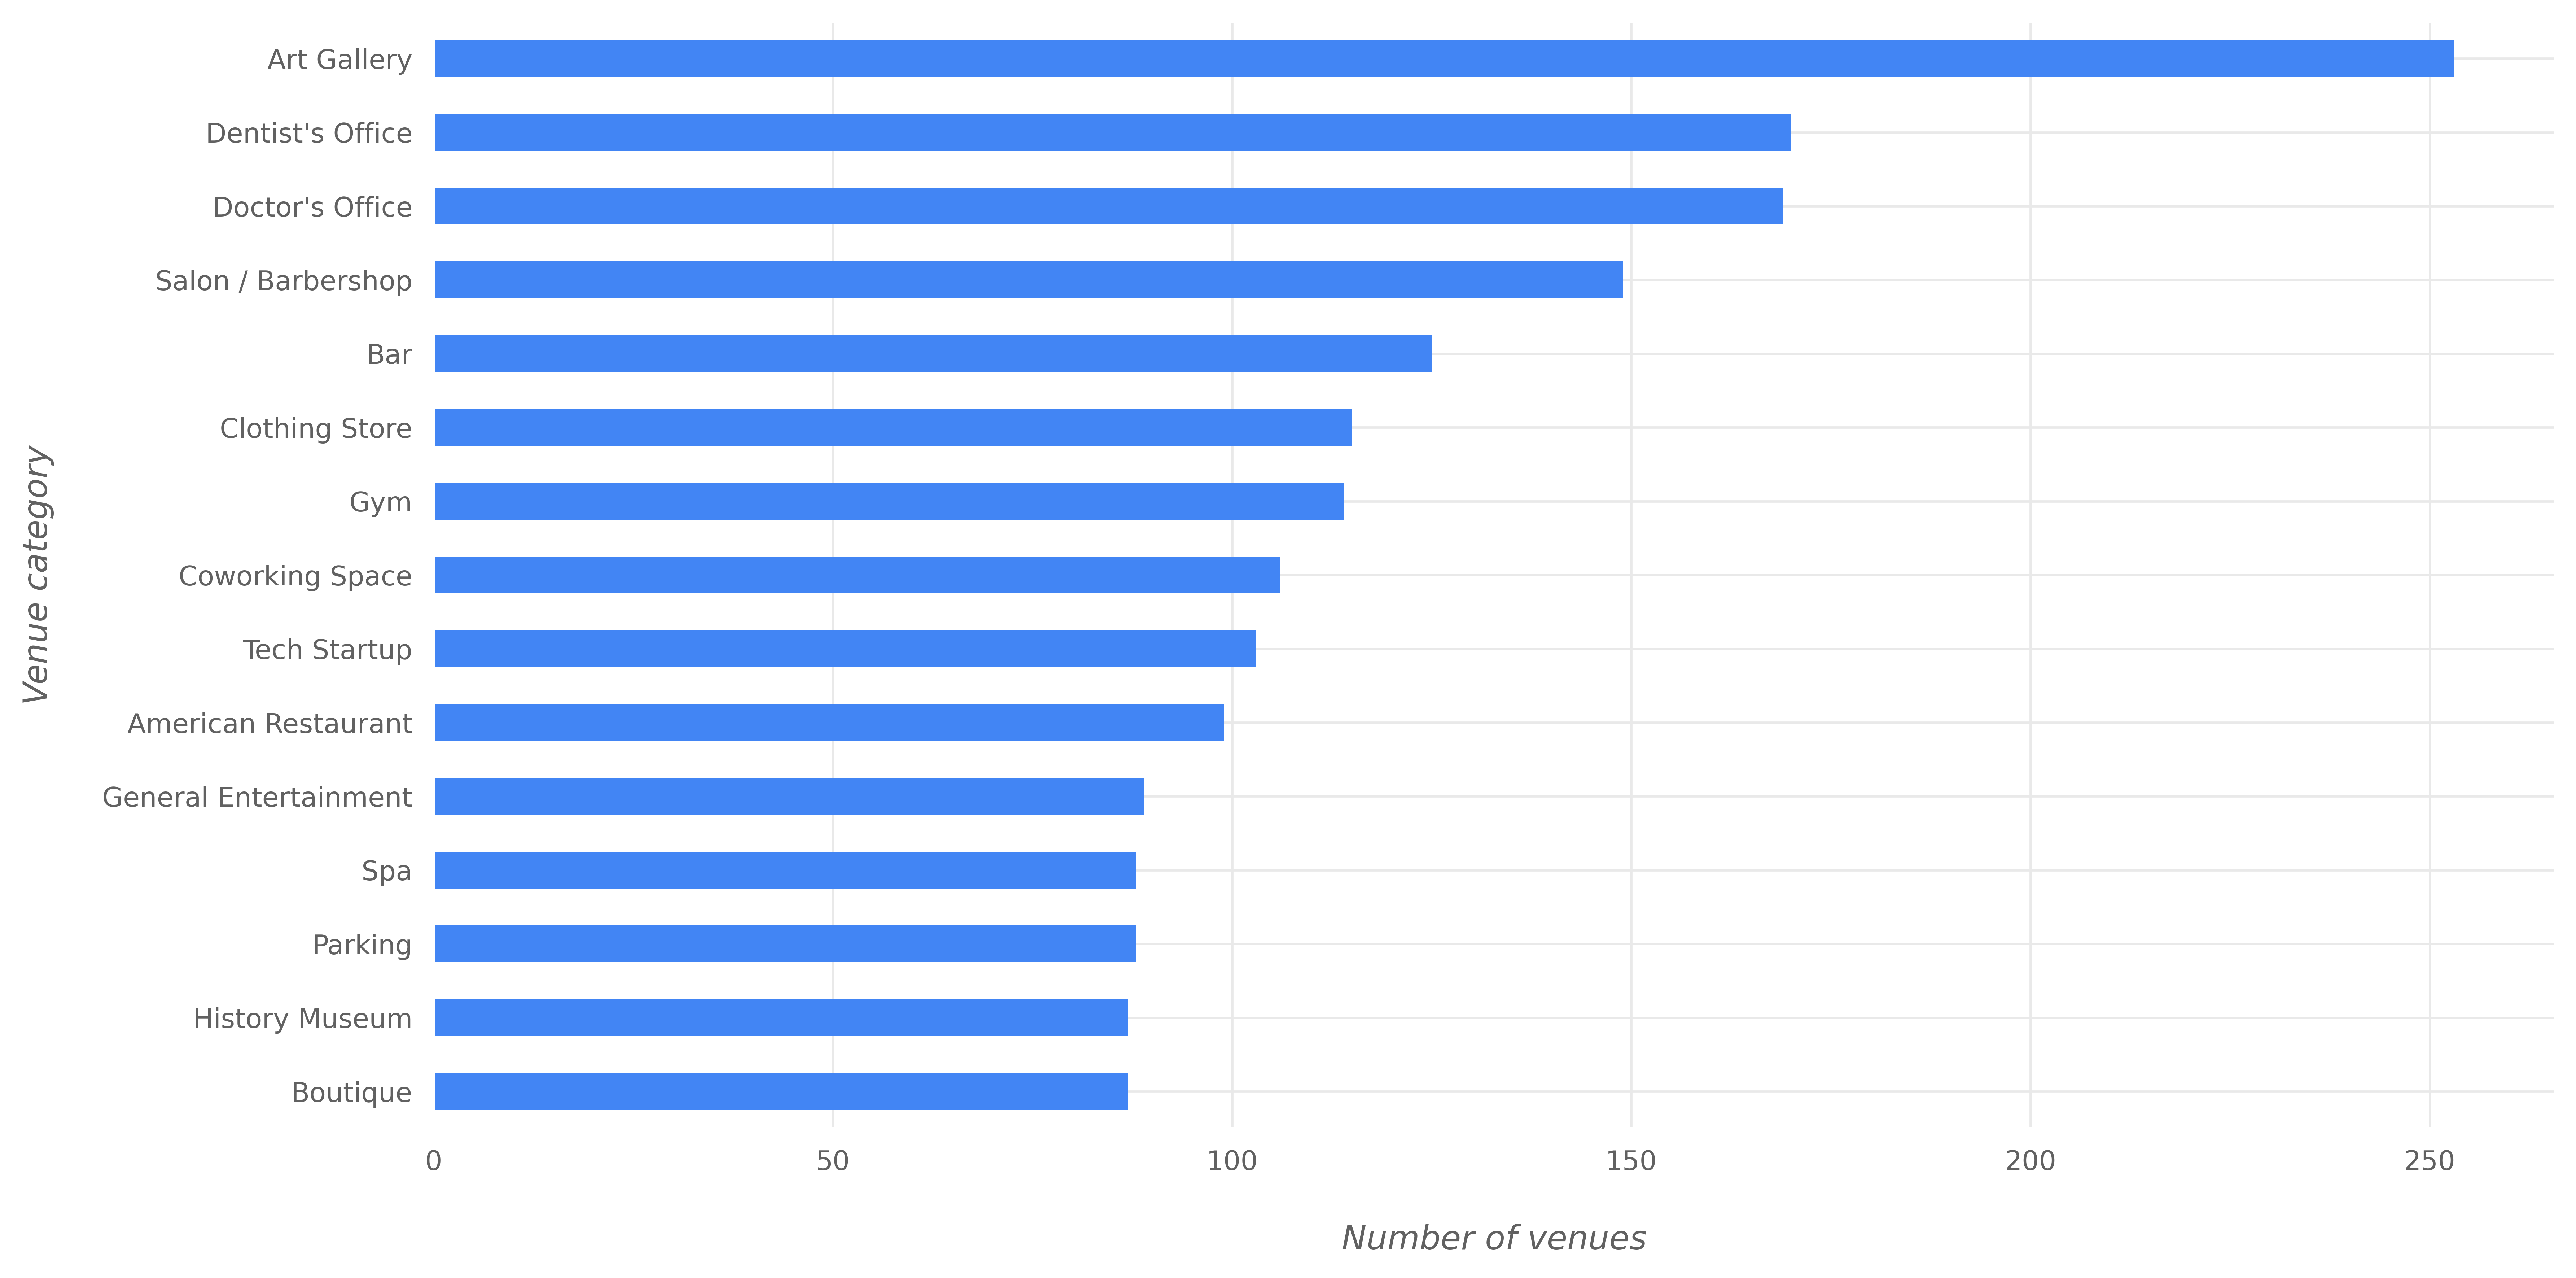

In [51]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
chicago_top_vc = chicago_venues['Venue Category'].value_counts(normalize=False)
ax = chicago_top_vc.head(15).plot(kind='barh', color=pc[0]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-chicago.png', dpi=300)

## Which Venue Categories Exist in More Chicago Neighborhoods?


99 neighborhoods in Chicago


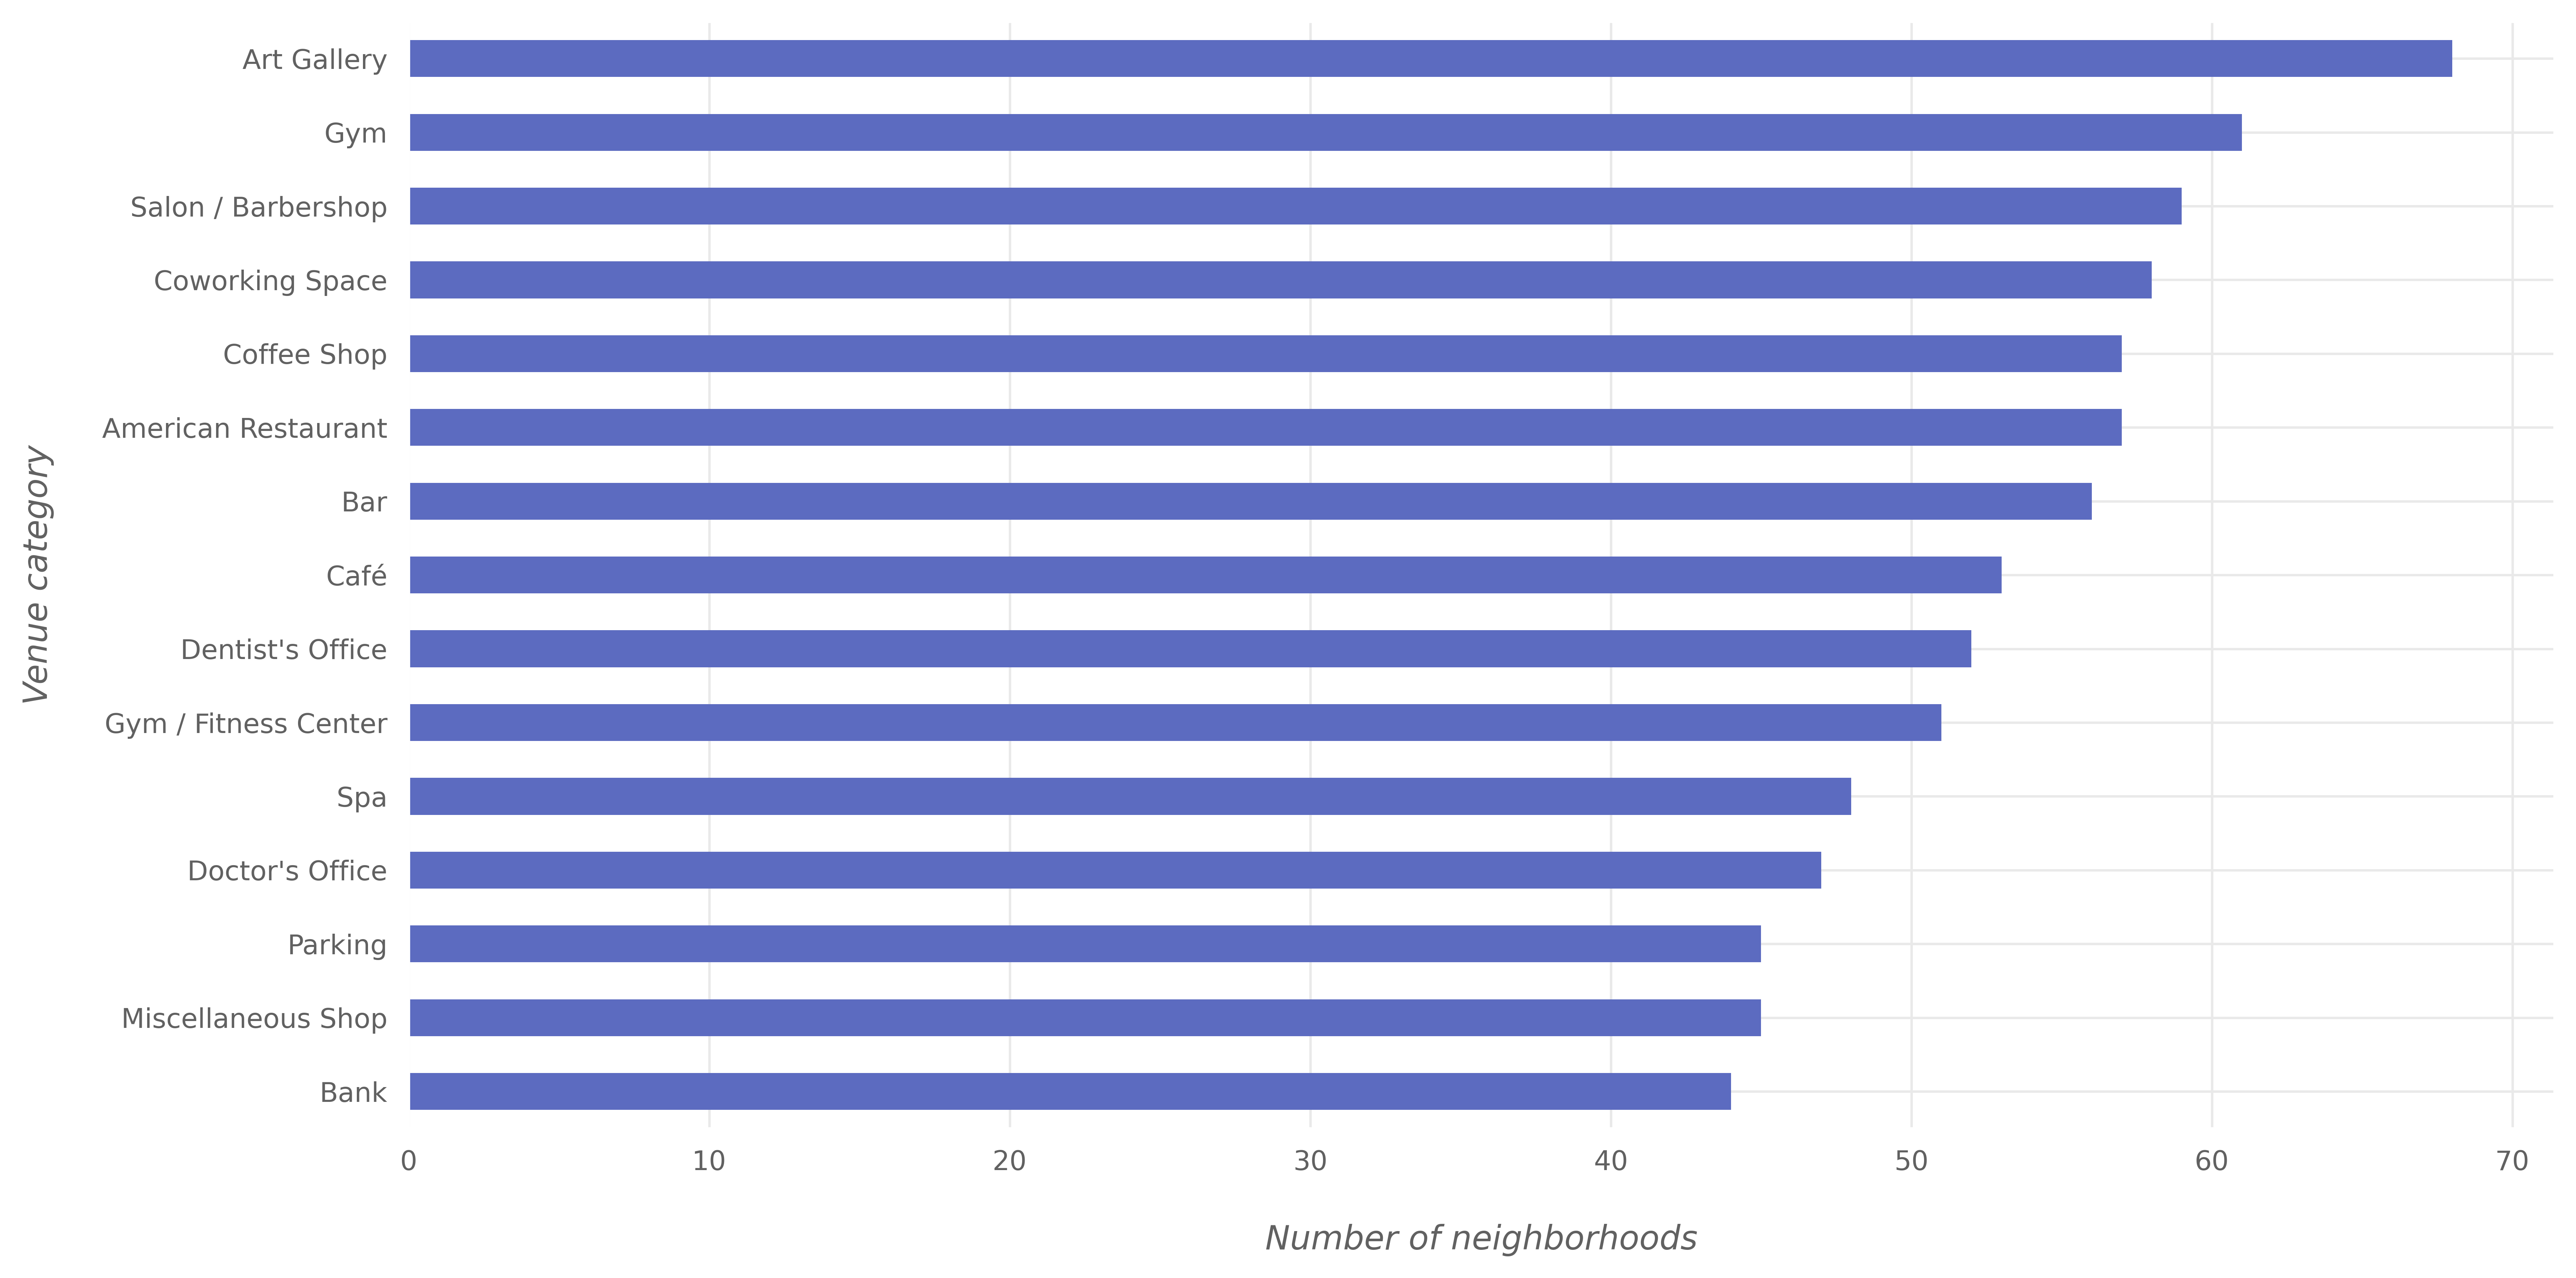

In [52]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
chicago_g = chicago_onehot.groupby('Neighborhood_').max().reset_index()
chicago_p = chicago_g.drop('Neighborhood_', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in Chicago".format(chicago_g.shape[0]))
ax = chicago_p.head(15).plot(kind='barh', color=pc[8]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-chicago.png', dpi=300)

In [53]:
brook_park_grouped = brook_park_onehot.groupby('Neighborhood_').mean().reset_index()
brook_park_grouped.head()

Neighborhood_  ATM  Accessories Store  \
0            Albany Park neighborhood in Chicago, IL  0.0                0.0   
1  Alta Vista Gardens neighborhood in West Chicag...  0.0                0.0   
2          Andersonville neighborhood in Chicago, IL  0.0                0.0   
3         Appletree neighborhood in West Chicago, IL  0.0                0.0   
4         Archer Heights neighborhood in Chicago, IL  0.0                0.0   

   Acupuncturist  Adult Boutique  Advertising Agency  Airport  \
0            0.0             0.0                 0.0      0.0   
1            0.0             0.0                 0.0      0.0   
2            0.0             0.0                 0.0      0.0   
3            0.0             0.0                 0.0      0.0   
4            0.0             0.0                 0.0      0.0   

   Alternative Healer  American Restaurant  Amphitheater  ...  Water Park  \
0            0.010753             0.021505           0.0  ...         0.0   
1            0.000000             0.062500           0.0  ...         0.0   
2            0.000000             0.000000           0.0  ...         0.0   
3            0.000000             0.000000           0.0  ...         0.0   
4            0.000000             0.000000           0.0  ...         0.0   

   Whisky Bar  Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  \
0         0.0       0.0        0.0     0.0          0.0            0.0   
1         0.0       0.0        0.0     0.0          0.0            0.0   
2         0.0       0.0        0.0     0.0          0.0            0.0   
3         0.0       0.0        0.0     0.0          0.0            0.0   
4         0.0       0.0        0.0     0.0          0.0            0.0   

   Yoga Studio  Zoo  Zoo Exhibit  
0          0.0  0.0          0.0  
1          0.0  0.0          0.0  
2          0.0  0.0          0.0  
3          0.0  0.0          0.0  
4          0.0  0.0          0.0  

[5 rows x 488 columns]

In [54]:
chicago_grouped = chicago_onehot.groupby('Neighborhood_').mean().reset_index()
chicago_grouped.head()

Neighborhood_  ATM  Accessories Store  \
0            Albany Park neighborhood in Chicago, IL  0.0                0.0   
1  Alta Vista Gardens neighborhood in West Chicag...  0.0                0.0   
2          Andersonville neighborhood in Chicago, IL  0.0                0.0   
3         Appletree neighborhood in West Chicago, IL  0.0                0.0   
4         Archer Heights neighborhood in Chicago, IL  0.0                0.0   

   Acupuncturist  Adult Boutique  Advertising Agency  African Restaurant  \
0            0.0             0.0            0.014286                 0.0   
1            0.0             0.0            0.000000                 0.0   
2            0.0             0.0            0.000000                 0.0   
3            0.0             0.0            0.000000                 0.0   
4            0.0             0.0            0.000000                 0.0   

   Airport  Alternative Healer  American Restaurant  ...  Weight Loss Center  \
0      0.0                 0.0             0.014286  ...                 0.0   
1      0.0                 0.0             0.014706  ...                 0.0   
2      0.0                 0.0             0.010870  ...                 0.0   
3      0.0                 0.0             0.046512  ...                 0.0   
4      0.0                 0.0             0.000000  ...                 0.0   

   Whisky Bar  Wine Bar  Wine Shop    Winery  Wings Joint  Women's Store  \
0         0.0  0.000000        0.0  0.000000          0.0            0.0   
1         0.0  0.000000        0.0  0.000000          0.0            0.0   
2         0.0  0.000000        0.0  0.000000          0.0            0.0   
3         0.0  0.000000        0.0  0.011628          0.0            0.0   
4         0.0  0.017241        0.0  0.000000          0.0            0.0   

   Yoga Studio  Zoo  Zoo Exhibit  
0          0.0  0.0          0.0  
1          0.0  0.0          0.0  
2          0.0  0.0          0.0  
3          0.0  0.0          0.0  
4          0.0  0.0          0.0  

[5 rows x 466 columns]

## The most common categories for each neighborhood¶


In [55]:
def return_most_common_venues(row, num_top_cat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cat]


num_top_cat = 7
indicators = ['st', 'nd', 'rd']

In [56]:
columns = ['Neighborhood_']
for ind in np.arange(num_top_cat):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
chicago_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
chicago_neighborhoods_categories_sorted['Neighborhood_'] = chicago_grouped['Neighborhood_']

for ind in np.arange(chicago_grouped.shape[0]):
    chicago_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        chicago_grouped.iloc[ind, :], num_top_cat)

chicago_neighborhoods_categories_sorted.head()

Neighborhood_ 1st Most Common Category  \
0            Albany Park neighborhood in Chicago, IL              Art Gallery   
1  Alta Vista Gardens neighborhood in West Chicag...    General Entertainment   
2          Andersonville neighborhood in Chicago, IL               Art Museum   
3         Appletree neighborhood in West Chicago, IL         Dentist's Office   
4         Archer Heights neighborhood in Chicago, IL               Playground   

  2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
0          Doctor's Office          Coworking Space               Non-Profit   
1              Event Space              Music Venue                     Café   
2              Art Gallery                   Museum                  Exhibit   
3          Doctor's Office              Art Gallery           Medical Center   
4                     Park                  Parking                    Train   

  5th Most Common Category 6th Most Common Category 7th Most Common Category  
0               Art Museum            Historic Site          Conference Room  
1            Historic Site                  Parking        College Classroom  
2         Sculpture Garden        College Cafeteria                  Theater  
3      American Restaurant     Mental Health Office            Jewelry Store  
4                      Bar          Conference Room              Coffee Shop

In [57]:
columns = ['Neighborhood_']
for ind in np.arange(num_top_cat):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
brook_park_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
brook_park_neighborhoods_categories_sorted['Neighborhood_'] = brook_park_grouped['Neighborhood_']

for ind in np.arange(brook_park_grouped.shape[0]):
    brook_park_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        brook_park_grouped.iloc[ind, :], num_top_cat)

brook_park_neighborhoods_categories_sorted.head()

Neighborhood_  \
0            Albany Park neighborhood in Chicago, IL   
1  Alta Vista Gardens neighborhood in West Chicag...   
2          Andersonville neighborhood in Chicago, IL   
3         Appletree neighborhood in West Chicago, IL   
4         Archer Heights neighborhood in Chicago, IL   

                   1st Most Common Category 2nd Most Common Category  \
0                                    Office           Medical Center   
1                                    Office                    Hotel   
2                           Doctor's Office          Automotive Shop   
3                                    Office                 Building   
4  Residential Building (Apartment / Condo)                     Park   

  3rd Most Common Category 4th Most Common Category 5th Most Common Category  \
0                    Hotel         Dentist's Office          Doctor's Office   
1      American Restaurant     Fast Food Restaurant              Gas Station   
2               Non-Profit                 Building       Salon / Barbershop   
3                     Park                    Hotel                    Trail   
4                   Office              Gas Station                 Building   

  6th Most Common Category 7th Most Common Category  
0               Food Truck                 Building  
1         Dentist's Office          Automotive Shop  
2             Funeral Home       Miscellaneous Shop  
3         Dentist's Office      Government Building  
4      Government Building                      Bar

In [58]:
df_add_neigh = df.copy()
df_add_neigh

Area: Population: avg household size avg number of cars apts  \
0    1.915      45,575         4.8 people                     1.1   
1    0.321         579         3.6 people                     1.6   
2    0.634      14,913         5.0 people                     0.8   
3    0.126          25         3.8 people                     1.8   
4    1.966      20,099        10.9 people                     1.1   
..     ...         ...                ...                     ...   
121  3.487      57,092         5.1 people                     1.3   
122  4.553     121,991         7.4 people                     1.0   
123  0.958      27,038        11.5 people                     1.0   
124  0.294         545         2.9 people                     2.5   
125  2.132      31,178         4.6 people                     0.6   

    avg number of cars houses   males med age females med age males  \
0                         1.4  22,649      38.6 years    35.5 years   
1                         2.5     283      33.1 years    30.3 years   
2                         1.4   7,623      39.0 years    40.2 years   
3                         2.3      13      34.5 years    29.6 years   
4                         1.9  10,312      32.5 years    31.8 years   
..                        ...     ...             ...           ...   
121                       1.3  28,412      39.5 years    37.8 years   
122                       1.4  62,943      32.2 years    32.7 years   
123                       1.3  14,299      32.0 years    32.2 years   
124                       2.5     270      42.5 years    41.6 years   
125                       1.3  13,373      38.1 years    32.6 years   

    med household income med rent  ... pct family household  \
0                $65,737     $983  ...                49.8%   
1                $57,021   $1,263  ...                62.9%   
2                $85,830   $1,264  ...                29.8%   
3                $81,237   $1,107  ...                84.0%   
4                $53,024     $799  ...                58.3%   
..                   ...      ...  ...                  ...   
121              $75,009   $1,072  ...                53.3%   
122             $102,451   $1,457  ...                36.2%   
123             $125,726   $1,665  ...                35.7%   
124              $96,435   $1,317  ...                68.0%   
125              $34,508     $771  ...                36.1%   

    pct foreign born residents pct married couple  \
0                        36.3%              44.7%   
1                        35.2%              65.6%   
2                        18.2%              33.8%   
3                        22.6%              43.2%   
4                        37.8%              52.9%   
..                         ...                ...   
121                      39.8%              55.9%   
122                      13.5%              30.3%   
123                       9.6%              31.3%   
124                      19.5%              54.1%   
125                       8.2%              15.9%   

    pct native residents born outside us pct never married females > 15  \
0                                   2.1%                          19.3%   
1                                   0.1%                          15.5%   
2                                   1.8%                          23.9%   
3                                   1.4%                          23.1%   
4                                   1.1%                          18.4%   
..                                   ...                            ...   
121                                 2.5%                          14.9%   
122                                 4.2%                          26.3%   
123                                 2.4%                          24.6%   
124                                 0.4%                          16.7%   
125                                 0.8%                          35.6%   

    pct never married males 

In [59]:
# add brook park neighborhood to df
row = pull_neighborhood_data('http://www.city-data.com/neighborhood/Brook-Park-Brook-Park-OH.html')
row

{'Area:': '12.979',
 'Population:': '25,488',
 'avg household size': '4.2 people',
 'avg number of cars apts': '1.4',
 'avg number of cars houses': '2.3',
 'males': '12,655',
 'med age females': '46.3 years',
 'med age males': '41.7 years',
 'med household income': '$55,566',
 'med rent': '$709',
 'pct born in another us state': '12.9%',
 'pct born in state': '78.3%',
 'pct families with children': '27.9%',
 'pct family household': '44.1%',
 'pct foreign born residents': '7.8%',
 'pct married couple': '44.5%',
 'pct native residents born outside us': '1.5%',
 'pct never married females > 15': '16.2%',
 'pct never married males > 15': '17.6%',
 'pct not speak English well': '2.3%',
 'pct single mother': '13.4%',
 'pct units mortgage': '56.2%'}

In [60]:
# If brook park has not been added, add it to the dataset
if len(df[df['neighborhood'] == 'Brook Park, Brook Park, OH']) == 0:
    df_add_neigh = df_add_neigh.append(pd.Series(row), ignore_index = True)
df_add_neigh.tail()

Area: Population: avg household size avg number of cars apts  \
122   4.553     121,991         7.4 people                     1.0   
123   0.958      27,038        11.5 people                     1.0   
124   0.294         545         2.9 people                     2.5   
125   2.132      31,178         4.6 people                     0.6   
126  12.979      25,488         4.2 people                     1.4   

    avg number of cars houses   males med age females med age males  \
122                       1.4  62,943      32.2 years    32.7 years   
123                       1.3  14,299      32.0 years    32.2 years   
124                       2.5     270      42.5 years    41.6 years   
125                       1.3  13,373      38.1 years    32.6 years   
126                       2.3  12,655      46.3 years    41.7 years   

    med household income med rent  ... pct family household  \
122             $102,451   $1,457  ...                36.2%   
123             $125,726   $1,665  ...                35.7%   
124              $96,435   $1,317  ...                68.0%   
125              $34,508     $771  ...                36.1%   
126              $55,566     $709  ...                44.1%   

    pct foreign born residents pct married couple  \
122                      13.5%              30.3%   
123                       9.6%              31.3%   
124                      19.5%              54.1%   
125                       8.2%              15.9%   
126                       7.8%              44.5%   

    pct native residents born outside us pct never married females > 15  \
122                                 4.2%                          26.3%   
123                                 2.4%                          24.6%   
124                                 0.4%                          16.7%   
125                                 0.8%                          35.6%   
126                                 1.5%                          16.2%   

    pct never married males > 15 pct not speak English well pct single mother  \
122                        29.6%                       5.4%             12.3%   
123                        31.0%                       3.2%              5.8%   
124                        17.5%                       8.9%              3.9%   
125                        26.2%                       0.7%             24.8%   
126                        17.6%                       2.3%             13.4%   

    pct units mortgage                               neighborhood  
122              82.1%      West Town neighborhood in Chicago, IL  
123              82.2%    Wicker Park neighborhood in Chicago, IL  
124              72.9%  Woodland neighborhood in West Chicago, IL  
125              71.9%       Woodlawn neighborhood in Chicago, IL  
126              56.2%                                        NaN  

[5 rows x 23 columns]

In [61]:
# df_add_neigh.columns
df_add_neigh['neighborhood'] = df_add_neigh['neighborhood'].replace(np.nan,'Brook Park neighborhood in Brook Park, OH')
df_add_neigh.tail()

Area: Population: avg household size avg number of cars apts  \
122   4.553     121,991         7.4 people                     1.0   
123   0.958      27,038        11.5 people                     1.0   
124   0.294         545         2.9 people                     2.5   
125   2.132      31,178         4.6 people                     0.6   
126  12.979      25,488         4.2 people                     1.4   

    avg number of cars houses   males med age females med age males  \
122                       1.4  62,943      32.2 years    32.7 years   
123                       1.3  14,299      32.0 years    32.2 years   
124                       2.5     270      42.5 years    41.6 years   
125                       1.3  13,373      38.1 years    32.6 years   
126                       2.3  12,655      46.3 years    41.7 years   

    med household income med rent  ... pct family household  \
122             $102,451   $1,457  ...                36.2%   
123             $125,726   $1,665  ...                35.7%   
124              $96,435   $1,317  ...                68.0%   
125              $34,508     $771  ...                36.1%   
126              $55,566     $709  ...                44.1%   

    pct foreign born residents pct married couple  \
122                      13.5%              30.3%   
123                       9.6%              31.3%   
124                      19.5%              54.1%   
125                       8.2%              15.9%   
126                       7.8%              44.5%   

    pct native residents born outside us pct never married females > 15  \
122                                 4.2%                          26.3%   
123                                 2.4%                          24.6%   
124                                 0.4%                          16.7%   
125                                 0.8%                          35.6%   
126                                 1.5%                          16.2%   

    pct never married males > 15 pct not speak English well pct single mother  \
122                        29.6%                       5.4%             12.3%   
123                        31.0%                       3.2%              5.8%   
124                        17.5%                       8.9%              3.9%   
125                        26.2%                       0.7%             24.8%   
126                        17.6%                       2.3%             13.4%   

    pct units mortgage                               neighborhood  
122              82.1%      West Town neighborhood in Chicago, IL  
123              82.2%    Wicker Park neighborhood in Chicago, IL  
124              72.9%  Woodland neighborhood in West Chicago, IL  
125              71.9%       Woodlawn neighborhood in Chicago, IL  
126              56.2%  Brook Park neighborhood in Brook Park, OH  

[5 rows x 23 columns]

In [62]:
# df_add_neigh.drop(df_add_neigh.tail(3).index, inplace = True)
# df_add_neigh.tail()

In [63]:
df_add_neigh[df_add_neigh['neighborhood'] == 'Brook Park neighborhood in Brook Park, OH']

Area: Population: avg household size avg number of cars apts  \
126  12.979      25,488         4.2 people                     1.4   

    avg number of cars houses   males med age females med age males  \
126                       2.3  12,655      46.3 years    41.7 years   

    med household income med rent  ... pct family household  \
126              $55,566     $709  ...                44.1%   

    pct foreign born residents pct married couple  \
126                       7.8%              44.5%   

    pct native residents born outside us pct never married females > 15  \
126                                 1.5%                          16.2%   

    pct never married males > 15 pct not speak English well pct single mother  \
126                        17.6%                       2.3%             13.4%   

    pct units mortgage                               neighborhood  
126              56.2%  Brook Park neighborhood in Brook Park, OH  

[1 rows x 23 columns]

In [64]:
df_add_neigh.to_csv('chicago_brook-park_neighs.csv')

In [65]:
df = pd.read_csv('chicago_brook-park_neighs.csv',index_col = 0)
df = df.rename(columns = {'neighborhood':'Neighborhood'})
df['Neighborhood'] = df['Neighborhood'].apply(lambda x:x.replace(' neighborhood in',','))
df = df.set_index('Neighborhood')
df.head()

Area: Population: avg household size  \
Neighborhood                                                                 
Albany Park, Chicago, IL              1.915      45,575         4.8 people   
Alta Vista Gardens, West Chicago, IL  0.321         579         3.6 people   
Andersonville, Chicago, IL            0.634      14,913         5.0 people   
Appletree, West Chicago, IL           0.126          25         3.8 people   
Archer Heights, Chicago, IL           1.966      20,099        10.9 people   

                                      avg number of cars apts  \
Neighborhood                                                    
Albany Park, Chicago, IL                                  1.1   
Alta Vista Gardens, West Chicago, IL                      1.6   
Andersonville, Chicago, IL                                0.8   
Appletree, West Chicago, IL                               1.8   
Archer Heights, Chicago, IL                               1.1   

                                      avg number of cars houses   males  \
Neighborhood                                                              
Albany Park, Chicago, IL                                    1.4  22,649   
Alta Vista Gardens, West Chicago, IL                        2.5     283   
Andersonville, Chicago, IL                                  1.4   7,623   
Appletree, West Chicago, IL                                 2.3      13   
Archer Heights, Chicago, IL                                 1.9  10,312   

                                     med age females med age males  \
Neighborhood                                                         
Albany Park, Chicago, IL                  38.6 years    35.5 years   
Alta Vista Gardens, West Chicago, IL      33.1 years    30.3 years   
Andersonville, Chicago, IL                39.0 years    40.2 years   
Appletree, West Chicago, IL               34.5 years    29.6 years   
Archer Heights, Chicago, IL               32.5 years    31.8 years   

                                     med household income med rent  ...  \
Neighborhood                                                        ...   
Albany Park, Chicago, IL                          $65,737     $983  ...   
Alta Vista Gardens, West Chicago, IL              $57,021   $1,263  ...   
Andersonville, Chicago, IL                        $85,830   $1,264  ...   
Appletree, West Chicago, IL                       $81,237   $1,107  ...   
Archer Heights, Chicago, IL                       $53,024     $799  ...   

                                     pct families with children  \
Neighborhood                                                      
Albany Park, Chicago, IL                                  28.0%   
Alta Vista Gardens, West Chicago, IL                      20.6%   
Andersonville, Chicago, IL                                34.5%   
Appletree, West Chicago, IL                               11.5%   
Archer Heights, Chicago, IL                               19.7%   

                                     pct family household  \
Neighborhood                                                
Albany Park, Chicago, IL                            49.8%   
Alta Vista Gardens, West Chicago, IL                62.9%   
Andersonville, Chicago, IL                          29.8%   
Appletree, West Chicago, IL                         84.0%   
Archer Heights, Chicago, IL                         58.3%   

                                     pct foreign born residents  \
Neighborhood                                                      
Albany Park, Chicago, IL                                  36.3%   
Alta Vista Gardens, West Chicago, IL                      35.2%   
Andersonville, Chicago, IL                                18.2%   
Appletree, West Chicago, IL                               22.6%   
Archer Heights, Chicago, IL                               37.8%   

                                     pct married couple  \
Neighborhood                                              
Albany

---
# Scrape Venues (production)

+ Now pull values from each neighborhood

In [66]:
# Retrieve the list of urls
with open('urls_dict.pickle','rb') as f:
    urls_dict = pickle.load(f)
urls_dict[:5] # show the first five

[('Albany Park neighborhood in Chicago, IL',
  'http://www.city-data.com/neighborhood/Albany-Park-Chicago-IL.html'),
 ('Alta Vista Gardens neighborhood in West Chicago, IL',
  'http://www.city-data.com/neighborhood/Alta-Vista-Gardens-West-Chicago-IL.html'),
 ('Andersonville neighborhood in Chicago, IL',
  'http://www.city-data.com/neighborhood/Andersonville-Chicago-IL.html'),
 ('Appletree neighborhood in West Chicago, IL',
  'http://www.city-data.com/neighborhood/Appletree-West-Chicago-IL.html'),
 ('Archer Heights neighborhood in Chicago, IL',
  'http://www.city-data.com/neighborhood/Archer-Heights-Chicago-IL.html')]

In [67]:
# Fix neighborhood name to make it look like an address

names = []
latitudes = []
longitudes = []

for u in urls_dict:
    try:
        name = u[0].replace(' neighborhood in',',') # make name look like an address
        lat = get_coords(name)[1]
        lng = get_coords(name)[2]
        print(name,lat,lng)
        names.append(name)
        latitudes.append(lat)
        longitudes.append(lng)
    except:
        pass
print(names,latitudes,longitudes)

Albany Park, Chicago, IL 40.249168 -94.338345
Andersonville, Chicago, IL 41.9771393 -87.66927341557962
Appletree, West Chicago, IL 41.858798 -88.18906
Archer Heights, Chicago, IL 41.804075 -87.7347494005478
Armour Square, Chicago, IL 41.7887757 -87.6016841
Ashburn, Chicago, IL 41.7411888 -87.7133516
Auburn Gresham, Chicago, IL 41.7539228 -87.6467163
Austin, Chicago, IL 41.8873138 -87.7743606
Avalon Park, Chicago, IL 41.742255549999996 -87.59473451586688
Avondale, Chicago, IL 41.7020156 -87.7898857
Belmont Cragin, Chicago, IL 41.9385081 -87.7499325
Beverly, Chicago, IL 41.7214831 -87.66589578004567
Brainerd, Chicago, IL 41.7328116 -87.6583828
Bridgeport, Chicago, IL 41.8388939 -87.6667101
Brighton Park, Chicago, IL 41.82948515 -87.69813059370775
Bronzeville, Chicago, IL 41.8312717 -87.6265475
Bucktown, Chicago, IL 41.9125727 -87.68034140366368
Burnside, Chicago, IL 41.7244847 -87.59835977095553
Cabrini-Green (Cabrini Green), Chicago, IL 41.8988049 -87.6409372
Canaryville, Chicago, IL 41

In [68]:
inputLocation = 'Brook Park, OH'
geolocator = Nominatim(user_agent="my_user_agent")
location = geolocator.geocode(inputLocation)
print(f'Location Address\n{location.address}\n')
print(f'Latitude & Longitude\n{(location.latitude, location.longitude)}\n')
# print(location.raw)

Location Address
Brook Park, Cuyahoga County, Ohio, 44142, United States

Latitude & Longitude
(41.3983838, -81.8045788)



In [69]:
# remove duplicates
# add brook park
# convert to a dataframe
# save it
coords = list(set(zip(names, latitudes, longitudes))) # remove duplicates
len(coords)

119

In [70]:
coords.append(('Brook Park, Brook Park, OH', 41.3983838, -81.8045788)) # append Murraywood
len(coords)

120

In [71]:
# save coords for later use
with open('coords.pickle','wb') as f:
    pickle.dump(coords,f)

In [72]:
# pull coords from file & check length
with open('coords.pickle','rb') as f:
    coords = pickle.load(f)
    
len(coords)

120

In [73]:
# def scrape_venues():
#     with open('urls_dict.pickle','rb') as f:
#         urls_dict = pickle.load(f)
#     names = []
#     latitudes = []
#     longitudes = []

#     for u in urls_dict:
#         try:
#             name = u[0].replace(' neighborhood in',',') # make name look like an address
#             lat = get_coords(name)[1]
#             lng = get_coords(name)[2]
#             names.append(name)
#             latitudes.append(lat)
#             longitudes.append(lng)
#         except:
#             pass

#     coords = list(set(zip(names, latitudes, longitudes))) # remove duplicates
#     # save coords for later use
#     with open('coords.pickle','wb') as f:
#         pickle.dump(coords,f)
#     return coords

---
# Pull Venus Data from within "radius" meters from length of "coords"

In [74]:
def get_nearby_venues(coords, client, radius = 122, limit = 100):        
    venues_lst = []
    for name, lat, lng in coords:
        print(name)
        try:
            latitude_str = str(lat)
            longitude_str = str(lng)
            ll = latitude_str + ',' + longitude_str       
            venues = client.venues.explore(params={
                'll':ll,
                'limit':100,
                'intent' : 'browse',
                'radius':8000,
            })
            venues = venues['groups'][0]['items']
            # return only relevant information for each nearby venue
            venues_lst.append([(
                        name, 
                        lat, 
                        lng, 
                        venue['venue']['name'], 
                        venue['venue']['location']['lat'], 
                        venue['venue']['location']['lng'],  
                        venue['venue']['categories'][0]['name']) for venue in venues])
        except:
            pass

        nearby_venues = pd.DataFrame([item for venue_list in venues_lst for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                                 'Neighborhood Latitude', 
                                 'Neighborhood Longitude', 
                                 'Venue', 
                                 'Venue Latitude', 
                                 'Venue Longitude', 
                                 'Venue Category']
    return nearby_venues

In [75]:
venues = get_nearby_venues(coords, foursquare_api())
venues

Beverly, Chicago, IL
Streeterville, Chicago, IL
Oakland, Chicago, IL
West Pullman, Chicago, IL
South Chicago, Chicago, IL
Lincoln Park, Chicago, IL
Kenwood, Chicago, IL
Bridgeport, Chicago, IL
East Side, Chicago, IL
Near West Side, Chicago, IL
Austin, Chicago, IL
West Garfield Park, Chicago, IL
Marquette Park (Chicago Lawn), Chicago, IL
Portage Park, Chicago, IL
North Center, Chicago, IL
Goose Island, Chicago, IL
Logan Square, Chicago, IL
West Englewood, Chicago, IL
Greater Grand Crossing, Chicago, IL
Archer Heights, Chicago, IL
Canaryville, Chicago, IL
Humboldt Park, Chicago, IL
Norwood Park, Chicago, IL
Woodlawn, Chicago, IL
Lincoln Square, Chicago, IL
Englewood, Chicago, IL
Hillside, West Chicago, IL
Bucktown, Chicago, IL
Grand Boulevard, Chicago, IL
Depaul, Chicago, IL
Belmont Cragin, Chicago, IL
Riverdale, Chicago, IL
Wicker Park, Chicago, IL
Cragin (Belmont Cragin), Chicago, IL
Dunning, Chicago, IL
Pill Hill (Calumet Heights), Chicago, IL
Printer's Row (Printers Row), Chicago, IL

Neighborhood  Neighborhood Latitude  \
0            Beverly, Chicago, IL              41.721483   
1            Beverly, Chicago, IL              41.721483   
2            Beverly, Chicago, IL              41.721483   
3            Beverly, Chicago, IL              41.721483   
4            Beverly, Chicago, IL              41.721483   
...                           ...                    ...   
11786  Brook Park, Brook Park, OH              41.398384   
11787  Brook Park, Brook Park, OH              41.398384   
11788  Brook Park, Brook Park, OH              41.398384   
11789  Brook Park, Brook Park, OH              41.398384   
11790  Brook Park, Brook Park, OH              41.398384   

       Neighborhood Longitude                           Venue  Venue Latitude  \
0                  -87.665896  Jimmy Jamm's Sweet Potato Pies       41.721181   
1                  -87.665896       The Original Rainbow Cone       41.725301   
2                  -87.665896                    Krispy Kreme       41.727698   
3                  -87.665896          Mariano's Fresh Market       41.719753   
4                  -87.665896               Janson's Drive-In       41.713478   
...                       ...                             ...             ...   
11786              -81.804579                 Jaipur Junction       41.349922   
11787              -81.804579                          Target       41.377700   
11788              -81.804579           Dickey's Barbecue Pit       41.379864   
11789              -81.804579   Characters Sports Bar & Grill       41.418441   
11790              -81.804579                  Nuevo Acapulco       41.442933   

       Venue Longitude      Venue Category  
0           -87.669373              Bakery  
1           -87.681856      Ice Cream Shop  
2           -87.682910          Donut Shop  
3           -87.687904       Grocery Store  
4           -87.682213       Hot Dog Joint  
...                ...                 ...  
11786       -81.757526   Indian Restaurant  
11787       -81.735665       Big Box Store  
11788       -81.738212           BBQ Joint  
11789       -81.726941          Sports Bar  
11790       -81.861652  Mexican Restaurant  

[11791 rows x 7 columns]

In [76]:
venues.to_csv('venues.csv')

---
# Data Exploration

In [77]:
venues.groupby('Neighborhood').count().head()

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                                 
Albany Park, Chicago, IL                         4                       4   
Andersonville, Chicago, IL                     100                     100   
Appletree, West Chicago, IL                    100                     100   
Archer Heights, Chicago, IL                    100                     100   
Armour Square, Chicago, IL                     100                     100   

                             Venue  Venue Latitude  Venue Longitude  \
Neighborhood                                                          
Albany Park, Chicago, IL         4               4                4   
Andersonville, Chicago, IL     100             100              100   
Appletree, West Chicago, IL    100             100              100   
Archer Heights, Chicago, IL    100             100              100   
Armour Square, Chicago, IL     100             100              100   

                             Venue Category  
Neighborhood                                 
Albany Park, Chicago, IL                  4  
Andersonville, Chicago, IL              100  
Appletree, West Chicago, IL             100  
Archer Heights, Chicago, IL             100  
Armour Square, Chicago, IL              100

In [78]:
# convert venue category to one hot encoding
venues_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
venues_onehot['Neighborhood'] = venues['Neighborhood']
# reorder columns
# cols = list(venues_onehot.columns)
# cols = [cols[-1]] + cols[:-1]
# venues_onehot = venues_onehot[cols]

field_ix = list(venues_onehot.columns).index('Neighborhood')
fixed_columns = [venues_onehot.columns[field_ix]]\
            +list(venues_onehot.columns[:field_ix])\
            +list(venues_onehot.columns[(field_ix+1):])
venues_onehot = venues_onehot[fixed_columns]
venues_onehot.head()

Neighborhood  ATM  Accessories Store  African Restaurant  \
0  Beverly, Chicago, IL    0                  0                   0   
1  Beverly, Chicago, IL    0                  0                   0   
2  Beverly, Chicago, IL    0                  0                   0   
3  Beverly, Chicago, IL    0                  0                   0   
4  Beverly, Chicago, IL    0                  0                   0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0               0                0                 0                    0   
1               0                0                 0                    0   
2               0                0                 0                    0   
3               0                0                 0                    0   
4               0                0                 0                    0   

   Amphitheater  Animal Shelter  ...  Warehouse Store  Waterfront  Whisky Bar  \
0             0               0  ...                0           0           0   
1             0               0  ...                0           0           0   
2             0               0  ...                0           0           0   
3             0               0  ...                0           0           0   
4             0               0  ...                0           0           0   

   Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  Zoo  
0         0          0       0            0              0            0    0  
1         0          0       0            0              0            0    0  
2         0          0       0            0              0            0    0  
3         0          0       0            0              0            0    0  
4         0          0       0            0              0            0    0  

[5 rows x 294 columns]

In [79]:
# count the number of venues in each category
venues_grouped = venues_onehot.groupby('Neighborhood').mean().reset_index()
venues_grouped = venues_grouped.set_index('Neighborhood')
venues_grouped.head()

ATM  Accessories Store  African Restaurant  \
Neighborhood                                                              
Albany Park, Chicago, IL     0.0                0.0                0.00   
Andersonville, Chicago, IL   0.0                0.0                0.00   
Appletree, West Chicago, IL  0.0                0.0                0.00   
Archer Heights, Chicago, IL  0.0                0.0                0.00   
Armour Square, Chicago, IL   0.0                0.0                0.01   

                             Airport Lounge  Airport Service  \
Neighborhood                                                   
Albany Park, Chicago, IL                0.0             0.00   
Andersonville, Chicago, IL              0.0             0.00   
Appletree, West Chicago, IL             0.0             0.00   
Archer Heights, Chicago, IL             0.0             0.01   
Armour Square, Chicago, IL              0.0             0.00   

                             Airport Terminal  American Restaurant  \
Neighborhood                                                         
Albany Park, Chicago, IL                 0.00                 0.00   
Andersonville, Chicago, IL               0.00                 0.01   
Appletree, West Chicago, IL              0.01                 0.03   
Archer Heights, Chicago, IL              0.00                 0.04   
Armour Square, Chicago, IL               0.00                 0.01   

                             Amphitheater  Animal Shelter  Aquarium  ...  \
Neighborhood                                                         ...   
Albany Park, Chicago, IL              0.0             0.0       0.0  ...   
Andersonville, Chicago, IL            0.0             0.0       0.0  ...   
Appletree, West Chicago, IL           0.0             0.0       0.0  ...   
Archer Heights, Chicago, IL           0.0             0.0       0.0  ...   
Armour Square, Chicago, IL            0.0             0.0       0.0  ...   

                             Warehouse Store  Waterfront  Whisky Bar  \
Neighborhood                                                           
Albany Park, Chicago, IL                0.00        0.00         0.0   
Andersonville, Chicago, IL              0.00        0.00         0.0   
Appletree, West Chicago, IL             0.00        0.00         0.0   
Archer Heights, Chicago, IL             0.01        0.00         0.0   
Armour Square, Chicago, IL              0.00        0.01         0.0   

                             Wine Bar  Wine Shop  Winery  Wings Joint  \
Neighborhood                                                            
Albany Park, Chicago, IL          0.0        0.0     0.0          0.0   
Andersonville, Chicago, IL        0.0        0.0     0.0          0.0   
Appletree, West Chicago, IL       0.0        0.0     0.0          0.0   
Archer Heights, Chicago, IL       0.0        0.0     0.0          0.0   
Armour Square, Chicago, IL        0.0        0.0     0.0          0.0   

                             Women's Store  Yoga Studio  Zoo  
Neighborhood                                                  
Albany Park, Chicago, IL               0.0         0.00  0.0  
Andersonville, Chicago, IL             0.0         0.00  0.0  
Appletree, West Chicago, IL            0.0         0.00  0.0  
Archer Heights, Chicago, IL            0.0         0.00  0.0  
Armour Square, Chicago, IL             0.0         0.02  0.0  

[5 rows x 293 columns]

---
# Join Socioeconomic Data with Venues

In [80]:
# venues data
venues_grouped.head()

ATM  Accessories Store  African Restaurant  \
Neighborhood                                                              
Albany Park, Chicago, IL     0.0                0.0                0.00   
Andersonville, Chicago, IL   0.0                0.0                0.00   
Appletree, West Chicago, IL  0.0                0.0                0.00   
Archer Heights, Chicago, IL  0.0                0.0                0.00   
Armour Square, Chicago, IL   0.0                0.0                0.01   

                             Airport Lounge  Airport Service  \
Neighborhood                                                   
Albany Park, Chicago, IL                0.0             0.00   
Andersonville, Chicago, IL              0.0             0.00   
Appletree, West Chicago, IL             0.0             0.00   
Archer Heights, Chicago, IL             0.0             0.01   
Armour Square, Chicago, IL              0.0             0.00   

                             Airport Terminal  American Restaurant  \
Neighborhood                                                         
Albany Park, Chicago, IL                 0.00                 0.00   
Andersonville, Chicago, IL               0.00                 0.01   
Appletree, West Chicago, IL              0.01                 0.03   
Archer Heights, Chicago, IL              0.00                 0.04   
Armour Square, Chicago, IL               0.00                 0.01   

                             Amphitheater  Animal Shelter  Aquarium  ...  \
Neighborhood                                                         ...   
Albany Park, Chicago, IL              0.0             0.0       0.0  ...   
Andersonville, Chicago, IL            0.0             0.0       0.0  ...   
Appletree, West Chicago, IL           0.0             0.0       0.0  ...   
Archer Heights, Chicago, IL           0.0             0.0       0.0  ...   
Armour Square, Chicago, IL            0.0             0.0       0.0  ...   

                             Warehouse Store  Waterfront  Whisky Bar  \
Neighborhood                                                           
Albany Park, Chicago, IL                0.00        0.00         0.0   
Andersonville, Chicago, IL              0.00        0.00         0.0   
Appletree, West Chicago, IL             0.00        0.00         0.0   
Archer Heights, Chicago, IL             0.01        0.00         0.0   
Armour Square, Chicago, IL              0.00        0.01         0.0   

                             Wine Bar  Wine Shop  Winery  Wings Joint  \
Neighborhood                                                            
Albany Park, Chicago, IL          0.0        0.0     0.0          0.0   
Andersonville, Chicago, IL        0.0        0.0     0.0          0.0   
Appletree, West Chicago, IL       0.0        0.0     0.0          0.0   
Archer Heights, Chicago, IL       0.0        0.0     0.0          0.0   
Armour Square, Chicago, IL        0.0        0.0     0.0          0.0   

                             Women's Store  Yoga Studio  Zoo  
Neighborhood                                                  
Albany Park, Chicago, IL               0.0         0.00  0.0  
Andersonville, Chicago, IL             0.0         0.00  0.0  
Appletree, West Chicago, IL            0.0         0.00  0.0  
Archer Heights, Chicago, IL            0.0         0.00  0.0  
Armour Square, Chicago, IL             0.0         0.02  0.0  

[5 rows x 293 columns]

In [81]:
# Socioeconomic data
df.head(2)

Area: Population: avg household size  \
Neighborhood                                                                 
Albany Park, Chicago, IL              1.915      45,575         4.8 people   
Alta Vista Gardens, West Chicago, IL  0.321         579         3.6 people   

                                      avg number of cars apts  \
Neighborhood                                                    
Albany Park, Chicago, IL                                  1.1   
Alta Vista Gardens, West Chicago, IL                      1.6   

                                      avg number of cars houses   males  \
Neighborhood                                                              
Albany Park, Chicago, IL                                    1.4  22,649   
Alta Vista Gardens, West Chicago, IL                        2.5     283   

                                     med age females med age males  \
Neighborhood                                                         
Albany Park, Chicago, IL                  38.6 years    35.5 years   
Alta Vista Gardens, West Chicago, IL      33.1 years    30.3 years   

                                     med household income med rent  ...  \
Neighborhood                                                        ...   
Albany Park, Chicago, IL                          $65,737     $983  ...   
Alta Vista Gardens, West Chicago, IL              $57,021   $1,263  ...   

                                     pct families with children  \
Neighborhood                                                      
Albany Park, Chicago, IL                                  28.0%   
Alta Vista Gardens, West Chicago, IL                      20.6%   

                                     pct family household  \
Neighborhood                                                
Albany Park, Chicago, IL                            49.8%   
Alta Vista Gardens, West Chicago, IL                62.9%   

                                     pct foreign born residents  \
Neighborhood                                                      
Albany Park, Chicago, IL                                  36.3%   
Alta Vista Gardens, West Chicago, IL                      35.2%   

                                     pct married couple  \
Neighborhood                                              
Albany Park, Chicago, IL                          44.7%   
Alta Vista Gardens, West Chicago, IL              65.6%   

                                     pct native residents born outside us  \
Neighborhood                                                                
Albany Park, Chicago, IL                                             2.1%   
Alta Vista Gardens, West Chicago, IL                                 0.1%   

                                     pct never married females > 15  \
Neighborhood                                                          
Albany Park, Chicago, IL                                      19.3%   
Alta Vista Gardens, West Chicago, IL                          15.5%   

                                     pct never married males > 15  \
Neighborhood                                                        
Albany Park, Chicago, IL                                    22.9%   
Alta Vista Gardens, West Chicago, IL                        25.5%   

                                     pct not speak English well  \
Neighborhood                                                      
Albany Park, Chicago, IL                                  13.7%   
Alta Vista Gardens, West Chicago, IL                      16.9%   

                                     pct single mother pct units mortgage  
Neighborhood                                                               
Albany Park, Chicago, IL                          6.3%              63.7%  
Alta Vista Gardens, West Chicago, IL              5.9%              74.8%  

[2 rows x 22 columns]

In [82]:
# Join both datasets
df_neighs_venues = df.join(venues_grouped, how = 'inner')
df_neighs_venues.to_csv('neighs_venues.csv')
df_neighs_venues.head()

Area: Population: avg household size  \
Neighborhood                                                        
Albany Park, Chicago, IL     1.915      45,575         4.8 people   
Andersonville, Chicago, IL   0.634      14,913         5.0 people   
Appletree, West Chicago, IL  0.126          25         3.8 people   
Archer Heights, Chicago, IL  1.966      20,099        10.9 people   
Armour Square, Chicago, IL   0.526       8,279         2.4 people   

                             avg number of cars apts  \
Neighborhood                                           
Albany Park, Chicago, IL                         1.1   
Andersonville, Chicago, IL                       0.8   
Appletree, West Chicago, IL                      1.8   
Archer Heights, Chicago, IL                      1.1   
Armour Square, Chicago, IL                       0.5   

                             avg number of cars houses   males  \
Neighborhood                                                     
Albany Park, Chicago, IL                           1.4  22,649   
Andersonville, Chicago, IL                         1.4   7,623   
Appletree, West Chicago, IL                        2.3      13   
Archer Heights, Chicago, IL                        1.9  10,312   
Armour Square, Chicago, IL                         1.4   3,896   

                            med age females med age males  \
Neighborhood                                                
Albany Park, Chicago, IL         38.6 years    35.5 years   
Andersonville, Chicago, IL       39.0 years    40.2 years   
Appletree, West Chicago, IL      34.5 years    29.6 years   
Archer Heights, Chicago, IL      32.5 years    31.8 years   
Armour Square, Chicago, IL       47.1 years    39.2 years   

                            med household income med rent  ...  \
Neighborhood                                               ...   
Albany Park, Chicago, IL                 $65,737     $983  ...   
Andersonville, Chicago, IL               $85,830   $1,264  ...   
Appletree, West Chicago, IL              $81,237   $1,107  ...   
Archer Heights, Chicago, IL              $53,024     $799  ...   
Armour Square, Chicago, IL               $32,295     $518  ...   

                            Warehouse Store Waterfront Whisky Bar Wine Bar  \
Neighborhood                                                                 
Albany Park, Chicago, IL               0.00       0.00        0.0      0.0   
Andersonville, Chicago, IL             0.00       0.00        0.0      0.0   
Appletree, West Chicago, IL            0.00       0.00        0.0      0.0   
Archer Heights, Chicago, IL            0.01       0.00        0.0      0.0   
Armour Square, Chicago, IL             0.00       0.01        0.0      0.0   

                            Wine Shop Winery Wings Joint Women's Store  \
Neighborhood                                                             
Albany Park, Chicago, IL          0.0    0.0         0.0           0.0   
Andersonville, Chicago, IL        0.0    0.0         0.0           0.0   
Appletree, West Chicago, IL       0.0    0.0         0.0           0.0   
Archer Heights, Chicago, IL       0.0    0.0         0.0           0.0   
Armour Square, Chicago, IL        0.0    0.0         0.0           0.0   

                            Yoga Studio  Zoo  
Neighborhood                                  
Albany Park, Chicago, IL           0.00  0.0  
Andersonville, Chicago, IL         0.00  0.0  
Appletree, West Chicago, IL        0.00  0.0  
Archer Heights, Chicago, IL        0.00  0.0  
Armour Square, Chicago, IL         0.02  0.0  

[5 rows x 315 columns]

In [83]:
list(df_neighs_venues.index)

['Albany Park, Chicago, IL',
 'Andersonville, Chicago, IL',
 'Appletree, West Chicago, IL',
 'Archer Heights, Chicago, IL',
 'Armour Square, Chicago, IL',
 'Ashburn, Chicago, IL',
 'Auburn Gresham, Chicago, IL',
 'Austin, Chicago, IL',
 'Avalon Park, Chicago, IL',
 'Avondale, Chicago, IL',
 'Belmont Cragin, Chicago, IL',
 'Beverly, Chicago, IL',
 'Brainerd, Chicago, IL',
 'Bridgeport, Chicago, IL',
 'Brighton Park, Chicago, IL',
 'Bronzeville, Chicago, IL',
 'Brook Park, Brook Park, OH',
 'Bucktown, Chicago, IL',
 'Burnside, Chicago, IL',
 'Cabrini-Green (Cabrini Green), Chicago, IL',
 'Canaryville, Chicago, IL',
 'Chatham, Chicago, IL',
 'Chicago Loop (The Loop), Chicago, IL',
 'Chinatown, Chicago, IL',
 'Clearing, Chicago, IL',
 'Cornerstone Lakes, West Chicago, IL',
 'Cragin (Belmont Cragin), Chicago, IL',
 'Depaul, Chicago, IL',
 'Douglas, Chicago, IL',
 'Downtown West Chicago (Downtown), West Chicago, IL',
 'Dunning, Chicago, IL',
 'East Garfield Park, Chicago, IL',
 'East Side, C

In [84]:
# Diagnostics -- see the shape
df_neighs_venues.shape

(118, 315)

In [85]:
# Diagnostics -- see if Murraywood neighborhood is in the dataset
df_neighs_venues[df_neighs_venues.index == 'Brook Park, Brook Park, OH']

Area: Population: avg household size  \
Neighborhood                                                        
Brook Park, Brook Park, OH  12.979      25,488         4.2 people   

                            avg number of cars apts  \
Neighborhood                                          
Brook Park, Brook Park, OH                      1.4   

                            avg number of cars houses   males med age females  \
Neighborhood                                                                    
Brook Park, Brook Park, OH                        2.3  12,655      46.3 years   

                           med age males med household income med rent  ...  \
Neighborhood                                                            ...   
Brook Park, Brook Park, OH    41.7 years              $55,566     $709  ...   

                           Warehouse Store Waterfront Whisky Bar Wine Bar  \
Neighborhood                                                                
Brook Park, Brook Park, OH            0.01        0.0        0.0     0.01   

                           Wine Shop Winery Wings Joint Women's Store  \
Neighborhood                                                            
Brook Park, Brook Park, OH       0.0    0.0         0.0           0.0   

                           Yoga Studio  Zoo  
Neighborhood                                 
Brook Park, Brook Park, OH         0.0  0.0  

[1 rows x 315 columns]

---
# Methodology

This section focuses on cleaning, preparation of previously collected data, exploratory analysis, and clustering. Below is the list of items in this section, more detail on each individual operation is in the text below. 

* Cleaning and preparation: the data (especially socioeconomic) needs to be cleaned and prepared:
    * fields renamed;
    * extra symbols removed;
    * NaN's fixed;

* Exploratory analysis: 
    * check field distributions, detect any abnormalities such as percentage exceeding 100%
    * explore correlation between fields;
    * discard erroneous or not needed data;
    
* Clustering -- the core Machine Learning methodology used in this project. The major focus of the project is to find a set of neighborhoods in Chicago that is similar to Brook Park according to socioeconomic data and proximity to venues. 
    * determine the optimum number of clusters;
    * perform clustering;  

## Clean and prepare data

Many fields contain additional text, dollar or percent signs. The code below will fix this and convert the fields to numbers.

In [86]:
# lets look at the data again
df = pd.read_csv('neighs_venues.csv',index_col = 0)
df.head()

Area: Population: avg household size  \
Neighborhood                                                        
Albany Park, Chicago, IL     1.915      45,575         4.8 people   
Andersonville, Chicago, IL   0.634      14,913         5.0 people   
Appletree, West Chicago, IL  0.126          25         3.8 people   
Archer Heights, Chicago, IL  1.966      20,099        10.9 people   
Armour Square, Chicago, IL   0.526       8,279         2.4 people   

                             avg number of cars apts  \
Neighborhood                                           
Albany Park, Chicago, IL                         1.1   
Andersonville, Chicago, IL                       0.8   
Appletree, West Chicago, IL                      1.8   
Archer Heights, Chicago, IL                      1.1   
Armour Square, Chicago, IL                       0.5   

                             avg number of cars houses   males  \
Neighborhood                                                     
Albany Park, Chicago, IL                           1.4  22,649   
Andersonville, Chicago, IL                         1.4   7,623   
Appletree, West Chicago, IL                        2.3      13   
Archer Heights, Chicago, IL                        1.9  10,312   
Armour Square, Chicago, IL                         1.4   3,896   

                            med age females med age males  \
Neighborhood                                                
Albany Park, Chicago, IL         38.6 years    35.5 years   
Andersonville, Chicago, IL       39.0 years    40.2 years   
Appletree, West Chicago, IL      34.5 years    29.6 years   
Archer Heights, Chicago, IL      32.5 years    31.8 years   
Armour Square, Chicago, IL       47.1 years    39.2 years   

                            med household income med rent  ...  \
Neighborhood                                               ...   
Albany Park, Chicago, IL                 $65,737     $983  ...   
Andersonville, Chicago, IL               $85,830   $1,264  ...   
Appletree, West Chicago, IL              $81,237   $1,107  ...   
Archer Heights, Chicago, IL              $53,024     $799  ...   
Armour Square, Chicago, IL               $32,295     $518  ...   

                            Warehouse Store Waterfront Whisky Bar Wine Bar  \
Neighborhood                                                                 
Albany Park, Chicago, IL               0.00       0.00        0.0      0.0   
Andersonville, Chicago, IL             0.00       0.00        0.0      0.0   
Appletree, West Chicago, IL            0.00       0.00        0.0      0.0   
Archer Heights, Chicago, IL            0.01       0.00        0.0      0.0   
Armour Square, Chicago, IL             0.00       0.01        0.0      0.0   

                            Wine Shop Winery Wings Joint Women's Store  \
Neighborhood                                                             
Albany Park, Chicago, IL          0.0    0.0         0.0           0.0   
Andersonville, Chicago, IL        0.0    0.0         0.0           0.0   
Appletree, West Chicago, IL       0.0    0.0         0.0           0.0   
Archer Heights, Chicago, IL       0.0    0.0         0.0           0.0   
Armour Square, Chicago, IL        0.0    0.0         0.0           0.0   

                            Yoga Studio  Zoo  
Neighborhood                                  
Albany Park, Chicago, IL           0.00  0.0  
Andersonville, Chicago, IL         0.00  0.0  
Appletree, West Chicago, IL        0.00  0.0  
Archer Heights, Chicago, IL        0.00  0.0  
Armour Square, Chicago, IL         0.02  0.0  

[5 rows x 315 columns]

In [87]:
# rename columns for uniformity
df = df.rename(columns = {'Area:':'area','Population:':'population'})
df.head()

area population avg household size  \
Neighborhood                                                       
Albany Park, Chicago, IL     1.915     45,575         4.8 people   
Andersonville, Chicago, IL   0.634     14,913         5.0 people   
Appletree, West Chicago, IL  0.126         25         3.8 people   
Archer Heights, Chicago, IL  1.966     20,099        10.9 people   
Armour Square, Chicago, IL   0.526      8,279         2.4 people   

                             avg number of cars apts  \
Neighborhood                                           
Albany Park, Chicago, IL                         1.1   
Andersonville, Chicago, IL                       0.8   
Appletree, West Chicago, IL                      1.8   
Archer Heights, Chicago, IL                      1.1   
Armour Square, Chicago, IL                       0.5   

                             avg number of cars houses   males  \
Neighborhood                                                     
Albany Park, Chicago, IL                           1.4  22,649   
Andersonville, Chicago, IL                         1.4   7,623   
Appletree, West Chicago, IL                        2.3      13   
Archer Heights, Chicago, IL                        1.9  10,312   
Armour Square, Chicago, IL                         1.4   3,896   

                            med age females med age males  \
Neighborhood                                                
Albany Park, Chicago, IL         38.6 years    35.5 years   
Andersonville, Chicago, IL       39.0 years    40.2 years   
Appletree, West Chicago, IL      34.5 years    29.6 years   
Archer Heights, Chicago, IL      32.5 years    31.8 years   
Armour Square, Chicago, IL       47.1 years    39.2 years   

                            med household income med rent  ...  \
Neighborhood                                               ...   
Albany Park, Chicago, IL                 $65,737     $983  ...   
Andersonville, Chicago, IL               $85,830   $1,264  ...   
Appletree, West Chicago, IL              $81,237   $1,107  ...   
Archer Heights, Chicago, IL              $53,024     $799  ...   
Armour Square, Chicago, IL               $32,295     $518  ...   

                            Warehouse Store Waterfront Whisky Bar Wine Bar  \
Neighborhood                                                                 
Albany Park, Chicago, IL               0.00       0.00        0.0      0.0   
Andersonville, Chicago, IL             0.00       0.00        0.0      0.0   
Appletree, West Chicago, IL            0.00       0.00        0.0      0.0   
Archer Heights, Chicago, IL            0.01       0.00        0.0      0.0   
Armour Square, Chicago, IL             0.00       0.01        0.0      0.0   

                            Wine Shop Winery Wings Joint Women's Store  \
Neighborhood                                                             
Albany Park, Chicago, IL          0.0    0.0         0.0           0.0   
Andersonville, Chicago, IL        0.0    0.0         0.0           0.0   
Appletree, West Chicago, IL       0.0    0.0         0.0           0.0   
Archer Heights, Chicago, IL       0.0    0.0         0.0           0.0   
Armour Square, Chicago, IL        0.0    0.0         0.0           0.0   

                            Yoga Studio  Zoo  
Neighborhood                                  
Albany Park, Chicago, IL           0.00  0.0  
Andersonville, Chicago, IL         0.00  0.0  
Appletree, West Chicago, IL        0.00  0.0  
Archer Heights, Chicago, IL        0.00  0.0  
Armour Square, Chicago, IL         0.02  0.0  

[5 rows x 315 columns]

In [88]:
# Remove any neighborhood that may have NaN's
df.dropna(inplace = True, axis = 0)

In [89]:
# Remove ' people' from household field and convert to float
def household_process(item):
    if type(item) == float:
        return item
    try:
        if len(item) > 6:
            return float(item[:-6])
        else:
            return 0
    except:
        return 0

df['avg household size'] = df['avg household size'].apply(household_process).astype(float)
df.loc[df['avg household size'] == 0,'avg household size'] = 1 # make household size = 1

In [90]:
# Remove ' years' from fields
def remove_years(item):
    if type(item) == float:
        return item
    try:
        if len(item) > 6:
            return float(item[:-6])
        else:
            return 0
    except:
        return 0

for f in ['med age males','med age females']:
    df[f] = df[f].apply(remove_years).astype(float)

In [91]:
# Remove $ sign
def remove_dollar(item):
    if type(item) == float:
        return item
    try:
        return float(item)
    except:
        pass
    try:
        if len(item) > 1:
            item = ''.join(item.split(','))[1:]
            return float(item)
        else:
            return 0
    except:
        return 0
for f in ['med household income','med rent']:
    df[f] = df[f].apply(remove_dollar)

In [92]:
# Remove % symbols from fields
def remove_percent(item):
    if type(item) == float:
        return item
    try:
        return float(item)
    except:
        pass
    try:
        if len(item) > 1:
            return float(item[:-1])
        else:
            return 0
    except:
        return 0
    
for f in ['pct born in another us state','pct born in state'
         ,'pct families with children','pct family household'
         ,'pct foreign born residents','pct married couple'
         ,'pct native residents born outside us','pct never married females > 15'
         ,'pct never married males > 15','pct not speak English well','pct units mortgage'
         ,'pct single mother','pct born in another us state'
         ]:
    df[f] = df[f].apply(remove_percent)

In [93]:
# Take another look at the data
df.iloc[:5,:22]

area population  avg household size  \
Neighborhood                                                        
Albany Park, Chicago, IL     1.915     45,575                 4.8   
Andersonville, Chicago, IL   0.634     14,913                 5.0   
Appletree, West Chicago, IL  0.126         25                 3.8   
Archer Heights, Chicago, IL  1.966     20,099                10.9   
Armour Square, Chicago, IL   0.526      8,279                 2.4   

                             avg number of cars apts  \
Neighborhood                                           
Albany Park, Chicago, IL                         1.1   
Andersonville, Chicago, IL                       0.8   
Appletree, West Chicago, IL                      1.8   
Archer Heights, Chicago, IL                      1.1   
Armour Square, Chicago, IL                       0.5   

                             avg number of cars houses   males  \
Neighborhood                                                     
Albany Park, Chicago, IL                           1.4  22,649   
Andersonville, Chicago, IL                         1.4   7,623   
Appletree, West Chicago, IL                        2.3      13   
Archer Heights, Chicago, IL                        1.9  10,312   
Armour Square, Chicago, IL                         1.4   3,896   

                             med age females  med age males  \
Neighborhood                                                  
Albany Park, Chicago, IL                38.6           35.5   
Andersonville, Chicago, IL              39.0           40.2   
Appletree, West Chicago, IL             34.5           29.6   
Archer Heights, Chicago, IL             32.5           31.8   
Armour Square, Chicago, IL              47.1           39.2   

                             med household income  med rent  ...  \
Neighborhood                                                 ...   
Albany Park, Chicago, IL                  65737.0     983.0  ...   
Andersonville, Chicago, IL                85830.0    1264.0  ...   
Appletree, West Chicago, IL               81237.0    1107.0  ...   
Archer Heights, Chicago, IL               53024.0     799.0  ...   
Armour Square, Chicago, IL                32295.0     518.0  ...   

                             pct families with children  pct family household  \
Neighborhood                                                                    
Albany Park, Chicago, IL                           28.0                  49.8   
Andersonville, Chicago, IL                         34.5                  29.8   
Appletree, West Chicago, IL                        11.5                  84.0   
Archer Heights, Chicago, IL                        19.7                  58.3   
Armour Square, Chicago, IL                         26.1                  31.9   

                             pct foreign born residents  pct married couple  \
Neighborhood                                                                  
Albany Park, Chicago, IL                           36.3                44.7   
Andersonville, Chicago, IL                         18.2                33.8   
Appletree, West Chicago, IL                        22.6                43.2   
Archer Heights, Chicago, IL                        37.8                52.9   
Armour Square, Chicago, IL                         74.9                34.4   

                             pct native residents born outside us  \
Neighborhood                                                        
Albany Park, Chicago, IL                                      2.1   
Andersonville, Chicago, IL                                    1.8   
Appletree, West Chicago, IL                                   1.4   
Archer Heights, Chicago, IL                                   1.1   
Armour Square, Chicago, IL                                    1.9   

                             pct never married females > 15  \
Neighborhood                                                  
Albany Park, Chicago, IL               

In [94]:
# Remove ',' from population field
df['population'] = df.population.apply(lambda x:int(''.join(x.split(','))))
# Remove ',' from males field
# df['males'] = df.males.apply(lambda x:float(''.join(x.split(','))))

In [95]:
# Try to process avg number of cars
def try_to_convert(item):
    try:
        return float(item)
    except:
        return None
df['avg number of cars apts'] = df['avg number of cars apts'].apply(try_to_convert)
df['avg number of cars houses'] = df['avg number of cars houses'].apply(try_to_convert)

In [96]:
df['males'].dtypes

dtype('O')

In [97]:
# Try to convert males field to a number
df['males'] = df['males'].apply(try_to_convert)

In [98]:
# Take another look at the data
df.head()

area  population  avg household size  \
Neighborhood                                                         
Albany Park, Chicago, IL     1.915       45575                 4.8   
Andersonville, Chicago, IL   0.634       14913                 5.0   
Appletree, West Chicago, IL  0.126          25                 3.8   
Archer Heights, Chicago, IL  1.966       20099                10.9   
Armour Square, Chicago, IL   0.526        8279                 2.4   

                             avg number of cars apts  \
Neighborhood                                           
Albany Park, Chicago, IL                         1.1   
Andersonville, Chicago, IL                       0.8   
Appletree, West Chicago, IL                      1.8   
Archer Heights, Chicago, IL                      1.1   
Armour Square, Chicago, IL                       0.5   

                             avg number of cars houses  males  \
Neighborhood                                                    
Albany Park, Chicago, IL                           1.4    NaN   
Andersonville, Chicago, IL                         1.4    NaN   
Appletree, West Chicago, IL                        2.3   13.0   
Archer Heights, Chicago, IL                        1.9    NaN   
Armour Square, Chicago, IL                         1.4    NaN   

                             med age females  med age males  \
Neighborhood                                                  
Albany Park, Chicago, IL                38.6           35.5   
Andersonville, Chicago, IL              39.0           40.2   
Appletree, West Chicago, IL             34.5           29.6   
Archer Heights, Chicago, IL             32.5           31.8   
Armour Square, Chicago, IL              47.1           39.2   

                             med household income  med rent  ...  \
Neighborhood                                                 ...   
Albany Park, Chicago, IL                  65737.0     983.0  ...   
Andersonville, Chicago, IL                85830.0    1264.0  ...   
Appletree, West Chicago, IL               81237.0    1107.0  ...   
Archer Heights, Chicago, IL               53024.0     799.0  ...   
Armour Square, Chicago, IL                32295.0     518.0  ...   

                             Warehouse Store  Waterfront  Whisky Bar  \
Neighborhood                                                           
Albany Park, Chicago, IL                0.00        0.00         0.0   
Andersonville, Chicago, IL              0.00        0.00         0.0   
Appletree, West Chicago, IL             0.00        0.00         0.0   
Archer Heights, Chicago, IL             0.01        0.00         0.0   
Armour Square, Chicago, IL              0.00        0.01         0.0   

                             Wine Bar  Wine Shop  Winery  Wings Joint  \
Neighborhood                                                            
Albany Park, Chicago, IL          0.0        0.0     0.0          0.0   
Andersonville, Chicago, IL        0.0        0.0     0.0          0.0   
Appletree, West Chicago, IL       0.0        0.0     0.0          0.0   
Archer Heights, Chicago, IL       0.0        0.0     0.0          0.0   
Armour Square, Chicago, IL        0.0        0.0     0.0          0.0   

                             Women's Store  Yoga Studio  Zoo  
Neighborhood                                                  
Albany Park, Chicago, IL               0.0         0.00  0.0  
Andersonville, Chicago, IL             0.0         0.00  0.0  
Appletree, West Chicago, IL            0.0         0.00  0.0  
Archer Heights, Chicago, IL            0.0         0.00  0.0  
Armour Square, Chicago, IL             0.0         0.02  0.0  

[5 rows x 315 columns]

---
### Fill NaNs with means

Several fields ended up having NaN's, where data could not be converted to numeric format:
* Avg number of cars -- fill with avg across the dataset
* Males -- fill with population/2

In [99]:
field = 'avg number of cars apts'
df[field].fillna(df[field].mean(), inplace = True)

In [100]:
field = 'avg number of cars houses'
df[field].fillna(df[field].mean(), inplace = True)

In [101]:
df.loc[df.isnull().any(axis = 1),'males'] = df.loc[df.isnull().any(axis = 1),'population']/2

In [102]:
df.to_csv('chicago_brook-park_neighs_clean.csv')

---
### Remove columns with sparse data

In [103]:
df = pd.read_csv('chicago_brook-park_neighs_clean.csv',index_col = 0)
df.head()

area  population  avg household size  \
Neighborhood                                                         
Albany Park, Chicago, IL     1.915       45575                 4.8   
Andersonville, Chicago, IL   0.634       14913                 5.0   
Appletree, West Chicago, IL  0.126          25                 3.8   
Archer Heights, Chicago, IL  1.966       20099                10.9   
Armour Square, Chicago, IL   0.526        8279                 2.4   

                             avg number of cars apts  \
Neighborhood                                           
Albany Park, Chicago, IL                         1.1   
Andersonville, Chicago, IL                       0.8   
Appletree, West Chicago, IL                      1.8   
Archer Heights, Chicago, IL                      1.1   
Armour Square, Chicago, IL                       0.5   

                             avg number of cars houses    males  \
Neighborhood                                                      
Albany Park, Chicago, IL                           1.4  22787.5   
Andersonville, Chicago, IL                         1.4   7456.5   
Appletree, West Chicago, IL                        2.3     13.0   
Archer Heights, Chicago, IL                        1.9  10049.5   
Armour Square, Chicago, IL                         1.4   4139.5   

                             med age females  med age males  \
Neighborhood                                                  
Albany Park, Chicago, IL                38.6           35.5   
Andersonville, Chicago, IL              39.0           40.2   
Appletree, West Chicago, IL             34.5           29.6   
Archer Heights, Chicago, IL             32.5           31.8   
Armour Square, Chicago, IL              47.1           39.2   

                             med household income  med rent  ...  \
Neighborhood                                                 ...   
Albany Park, Chicago, IL                  65737.0     983.0  ...   
Andersonville, Chicago, IL                85830.0    1264.0  ...   
Appletree, West Chicago, IL               81237.0    1107.0  ...   
Archer Heights, Chicago, IL               53024.0     799.0  ...   
Armour Square, Chicago, IL                32295.0     518.0  ...   

                             Warehouse Store  Waterfront  Whisky Bar  \
Neighborhood                                                           
Albany Park, Chicago, IL                0.00        0.00         0.0   
Andersonville, Chicago, IL              0.00        0.00         0.0   
Appletree, West Chicago, IL             0.00        0.00         0.0   
Archer Heights, Chicago, IL             0.01        0.00         0.0   
Armour Square, Chicago, IL              0.00        0.01         0.0   

                             Wine Bar  Wine Shop  Winery  Wings Joint  \
Neighborhood                                                            
Albany Park, Chicago, IL          0.0        0.0     0.0          0.0   
Andersonville, Chicago, IL        0.0        0.0     0.0          0.0   
Appletree, West Chicago, IL       0.0        0.0     0.0          0.0   
Archer Heights, Chicago, IL       0.0        0.0     0.0          0.0   
Armour Square, Chicago, IL        0.0        0.0     0.0          0.0   

                             Women's Store  Yoga Studio  Zoo  
Neighborhood                                                  
Albany Park, Chicago, IL               0.0         0.00  0.0  
Andersonville, Chicago, IL             0.0         0.00  0.0  
Appletree, West Chicago, IL            0.0         0.00  0.0  
Archer Heights, Chicago, IL            0.0         0.00  0.0  
Armour Square, Chicago, IL             0.0         0.02  0.0  

[5 rows x 315 columns]

In [104]:
# Investigate which venue columns have only few occurrences
columns_keep_socio = list(df.columns[:22])
columns_keep_socio

['area',
 'population',
 'avg household size',
 'avg number of cars apts',
 'avg number of cars houses',
 'males',
 'med age females',
 'med age males',
 'med household income',
 'med rent',
 'pct born in another us state',
 'pct born in state',
 'pct families with children',
 'pct family household',
 'pct foreign born residents',
 'pct married couple',
 'pct native residents born outside us',
 'pct never married females > 15',
 'pct never married males > 15',
 'pct not speak English well',
 'pct single mother',
 'pct units mortgage']

In [105]:
# Investigate which venue columns have only few occurrences
columns_keep_socio = list(df.columns[:22])
columns_keep_venues = list(df.iloc[:,22:].sum().sort_values(0, ascending = False).index[:5]) # only five most common venues
columns_keep = columns_keep_socio + columns_keep_venues
columns_keep_venues

['Grocery Store', 'Coffee Shop', 'Park', 'Hotel', 'Pizza Place']

In [106]:
# Drop fields and save the dataset
df_dropped = df[columns_keep]
df_dropped.to_csv('chicago_brook-park_neighs_clean2.csv')

---
# Exploratory Analysis 

In [107]:
df_dropped.head()

area  population  avg household size  \
Neighborhood                                                         
Albany Park, Chicago, IL     1.915       45575                 4.8   
Andersonville, Chicago, IL   0.634       14913                 5.0   
Appletree, West Chicago, IL  0.126          25                 3.8   
Archer Heights, Chicago, IL  1.966       20099                10.9   
Armour Square, Chicago, IL   0.526        8279                 2.4   

                             avg number of cars apts  \
Neighborhood                                           
Albany Park, Chicago, IL                         1.1   
Andersonville, Chicago, IL                       0.8   
Appletree, West Chicago, IL                      1.8   
Archer Heights, Chicago, IL                      1.1   
Armour Square, Chicago, IL                       0.5   

                             avg number of cars houses    males  \
Neighborhood                                                      
Albany Park, Chicago, IL                           1.4  22787.5   
Andersonville, Chicago, IL                         1.4   7456.5   
Appletree, West Chicago, IL                        2.3     13.0   
Archer Heights, Chicago, IL                        1.9  10049.5   
Armour Square, Chicago, IL                         1.4   4139.5   

                             med age females  med age males  \
Neighborhood                                                  
Albany Park, Chicago, IL                38.6           35.5   
Andersonville, Chicago, IL              39.0           40.2   
Appletree, West Chicago, IL             34.5           29.6   
Archer Heights, Chicago, IL             32.5           31.8   
Armour Square, Chicago, IL              47.1           39.2   

                             med household income  med rent  ...  \
Neighborhood                                                 ...   
Albany Park, Chicago, IL                  65737.0     983.0  ...   
Andersonville, Chicago, IL                85830.0    1264.0  ...   
Appletree, West Chicago, IL               81237.0    1107.0  ...   
Archer Heights, Chicago, IL               53024.0     799.0  ...   
Armour Square, Chicago, IL                32295.0     518.0  ...   

                             pct never married females > 15  \
Neighborhood                                                  
Albany Park, Chicago, IL                               19.3   
Andersonville, Chicago, IL                             23.9   
Appletree, West Chicago, IL                            23.1   
Archer Heights, Chicago, IL                            18.4   
Armour Square, Chicago, IL                             16.8   

                             pct never married males > 15  \
Neighborhood                                                
Albany Park, Chicago, IL                             22.9   
Andersonville, Chicago, IL                           24.8   
Appletree, West Chicago, IL                          36.2   
Archer Heights, Chicago, IL                          19.8   
Armour Square, Chicago, IL                           20.3   

                             pct not speak English well  pct single mother  \
Neighborhood                                                                 
Albany Park, Chicago, IL                           13.7                6.3   
Andersonville, Chicago, IL                          5.0               19.3   
Appletree, West Chicago, IL                         4.5               15.8   
Archer Heights, Chicago, IL                        18.5                6.1   
Armour Square, Chicago, IL                         30.0               28.0   

                             pct units mortgage  Grocery Store  Coffee Shop  \
Neighborhood                                                                  
Albany Park, Chicago, IL                   63.7           0.25         0.00   
Andersonville, Chicago, IL                 76.2           0.06         0.07   
Appletree, West Chicago,

In [108]:
df

area  population  avg household size  \
Neighborhood                                                         
Albany Park, Chicago, IL     1.915       45575                 4.8   
Andersonville, Chicago, IL   0.634       14913                 5.0   
Appletree, West Chicago, IL  0.126          25                 3.8   
Archer Heights, Chicago, IL  1.966       20099                10.9   
Armour Square, Chicago, IL   0.526        8279                 2.4   
...                            ...         ...                 ...   
West Pullman, Chicago, IL    3.642       29099                 4.9   
West Town, Chicago, IL       4.553      121991                 7.4   
Wicker Park, Chicago, IL     0.958       27038                11.5   
Woodland, West Chicago, IL   0.294         545                 2.9   
Woodlawn, Chicago, IL        2.132       31178                 4.6   

                             avg number of cars apts  \
Neighborhood                                           
Albany Park, Chicago, IL                         1.1   
Andersonville, Chicago, IL                       0.8   
Appletree, West Chicago, IL                      1.8   
Archer Heights, Chicago, IL                      1.1   
Armour Square, Chicago, IL                       0.5   
...                                              ...   
West Pullman, Chicago, IL                        1.0   
West Town, Chicago, IL                           1.0   
Wicker Park, Chicago, IL                         1.0   
Woodland, West Chicago, IL                       2.5   
Woodlawn, Chicago, IL                            0.6   

                             avg number of cars houses    males  \
Neighborhood                                                      
Albany Park, Chicago, IL                           1.4  22787.5   
Andersonville, Chicago, IL                         1.4   7456.5   
Appletree, West Chicago, IL                        2.3     13.0   
Archer Heights, Chicago, IL                        1.9  10049.5   
Armour Square, Chicago, IL                         1.4   4139.5   
...                                                ...      ...   
West Pullman, Chicago, IL                          1.6  14549.5   
West Town, Chicago, IL                             1.4  60995.5   
Wicker Park, Chicago, IL                           1.3  13519.0   
Woodland, West Chicago, IL                         2.5    270.0   
Woodlawn, Chicago, IL                              1.3  15589.0   

                             med age females  med age males  \
Neighborhood                                                  
Albany Park, Chicago, IL                38.6           35.5   
Andersonville, Chicago, IL              39.0           40.2   
Appletree, West Chicago, IL             34.5           29.6   
Archer Heights, Chicago, IL             32.5           31.8   
Armour Square, Chicago, IL              47.1           39.2   
...                                      ...            ...   
West Pullman, Chicago, IL               41.0           36.1   
West Town, Chicago, IL                  32.2           32.7   
Wicker Park, Chicago, IL                32.0           32.2   
Woodland, West Chicago, IL              42.5           41.6   
Woodlawn, Chicago, IL                   38.1           32.6   

                             med household income  med rent  ...  \
Neighborhood                                                 ...   
Albany Park, Chicago, IL                  65737.0     983.0  ...   
Andersonville, Chicago, IL                85830.0    1264.0  ...   
Appletree, West Chicago, IL               81237.0    1107.0  ...   
Archer Heights, Chicago, IL               53024.0     799.0  ...   
Armour Square, Chicago, IL                32295.0     518.0  ...   
...                                           ...       ...  ...   
West Pullman, Chicago, IL                 42551.0     803.0  ...   
West Town, Chicago, IL                   102451.0    1457.0  ...   
Wicker Park, Chica

## Neighborhood Area

In [109]:
df['area'].sort_values(ascending=False)

Neighborhood
O'Hare, Chicago, IL                           13.384
Brook Park, Brook Park, OH                    12.979
South Deering, Chicago, IL                    10.822
Lawndale, Chicago, IL                          8.810
Austin, Chicago, IL                            6.095
                                               ...  
Bronzeville, Chicago, IL                       0.174
Appletree, West Chicago, IL                    0.126
Fair Meadows, West Chicago, IL                 0.077
Greektown, Chicago, IL                         0.039
Cabrini-Green (Cabrini Green), Chicago, IL     0.029
Name: area, Length: 118, dtype: float64

In [110]:
df.area.describe()

count    118.000000
mean       2.289008
std        2.218688
min        0.029000
25%        0.922000
50%        1.772500
75%        3.034500
max       13.384000
Name: area, dtype: float64

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 1.0, 'Neighborhood Areas')

Text(0.5, 0, 'Area, sq. miles')

Text(0, 0.5, 'Frequency')

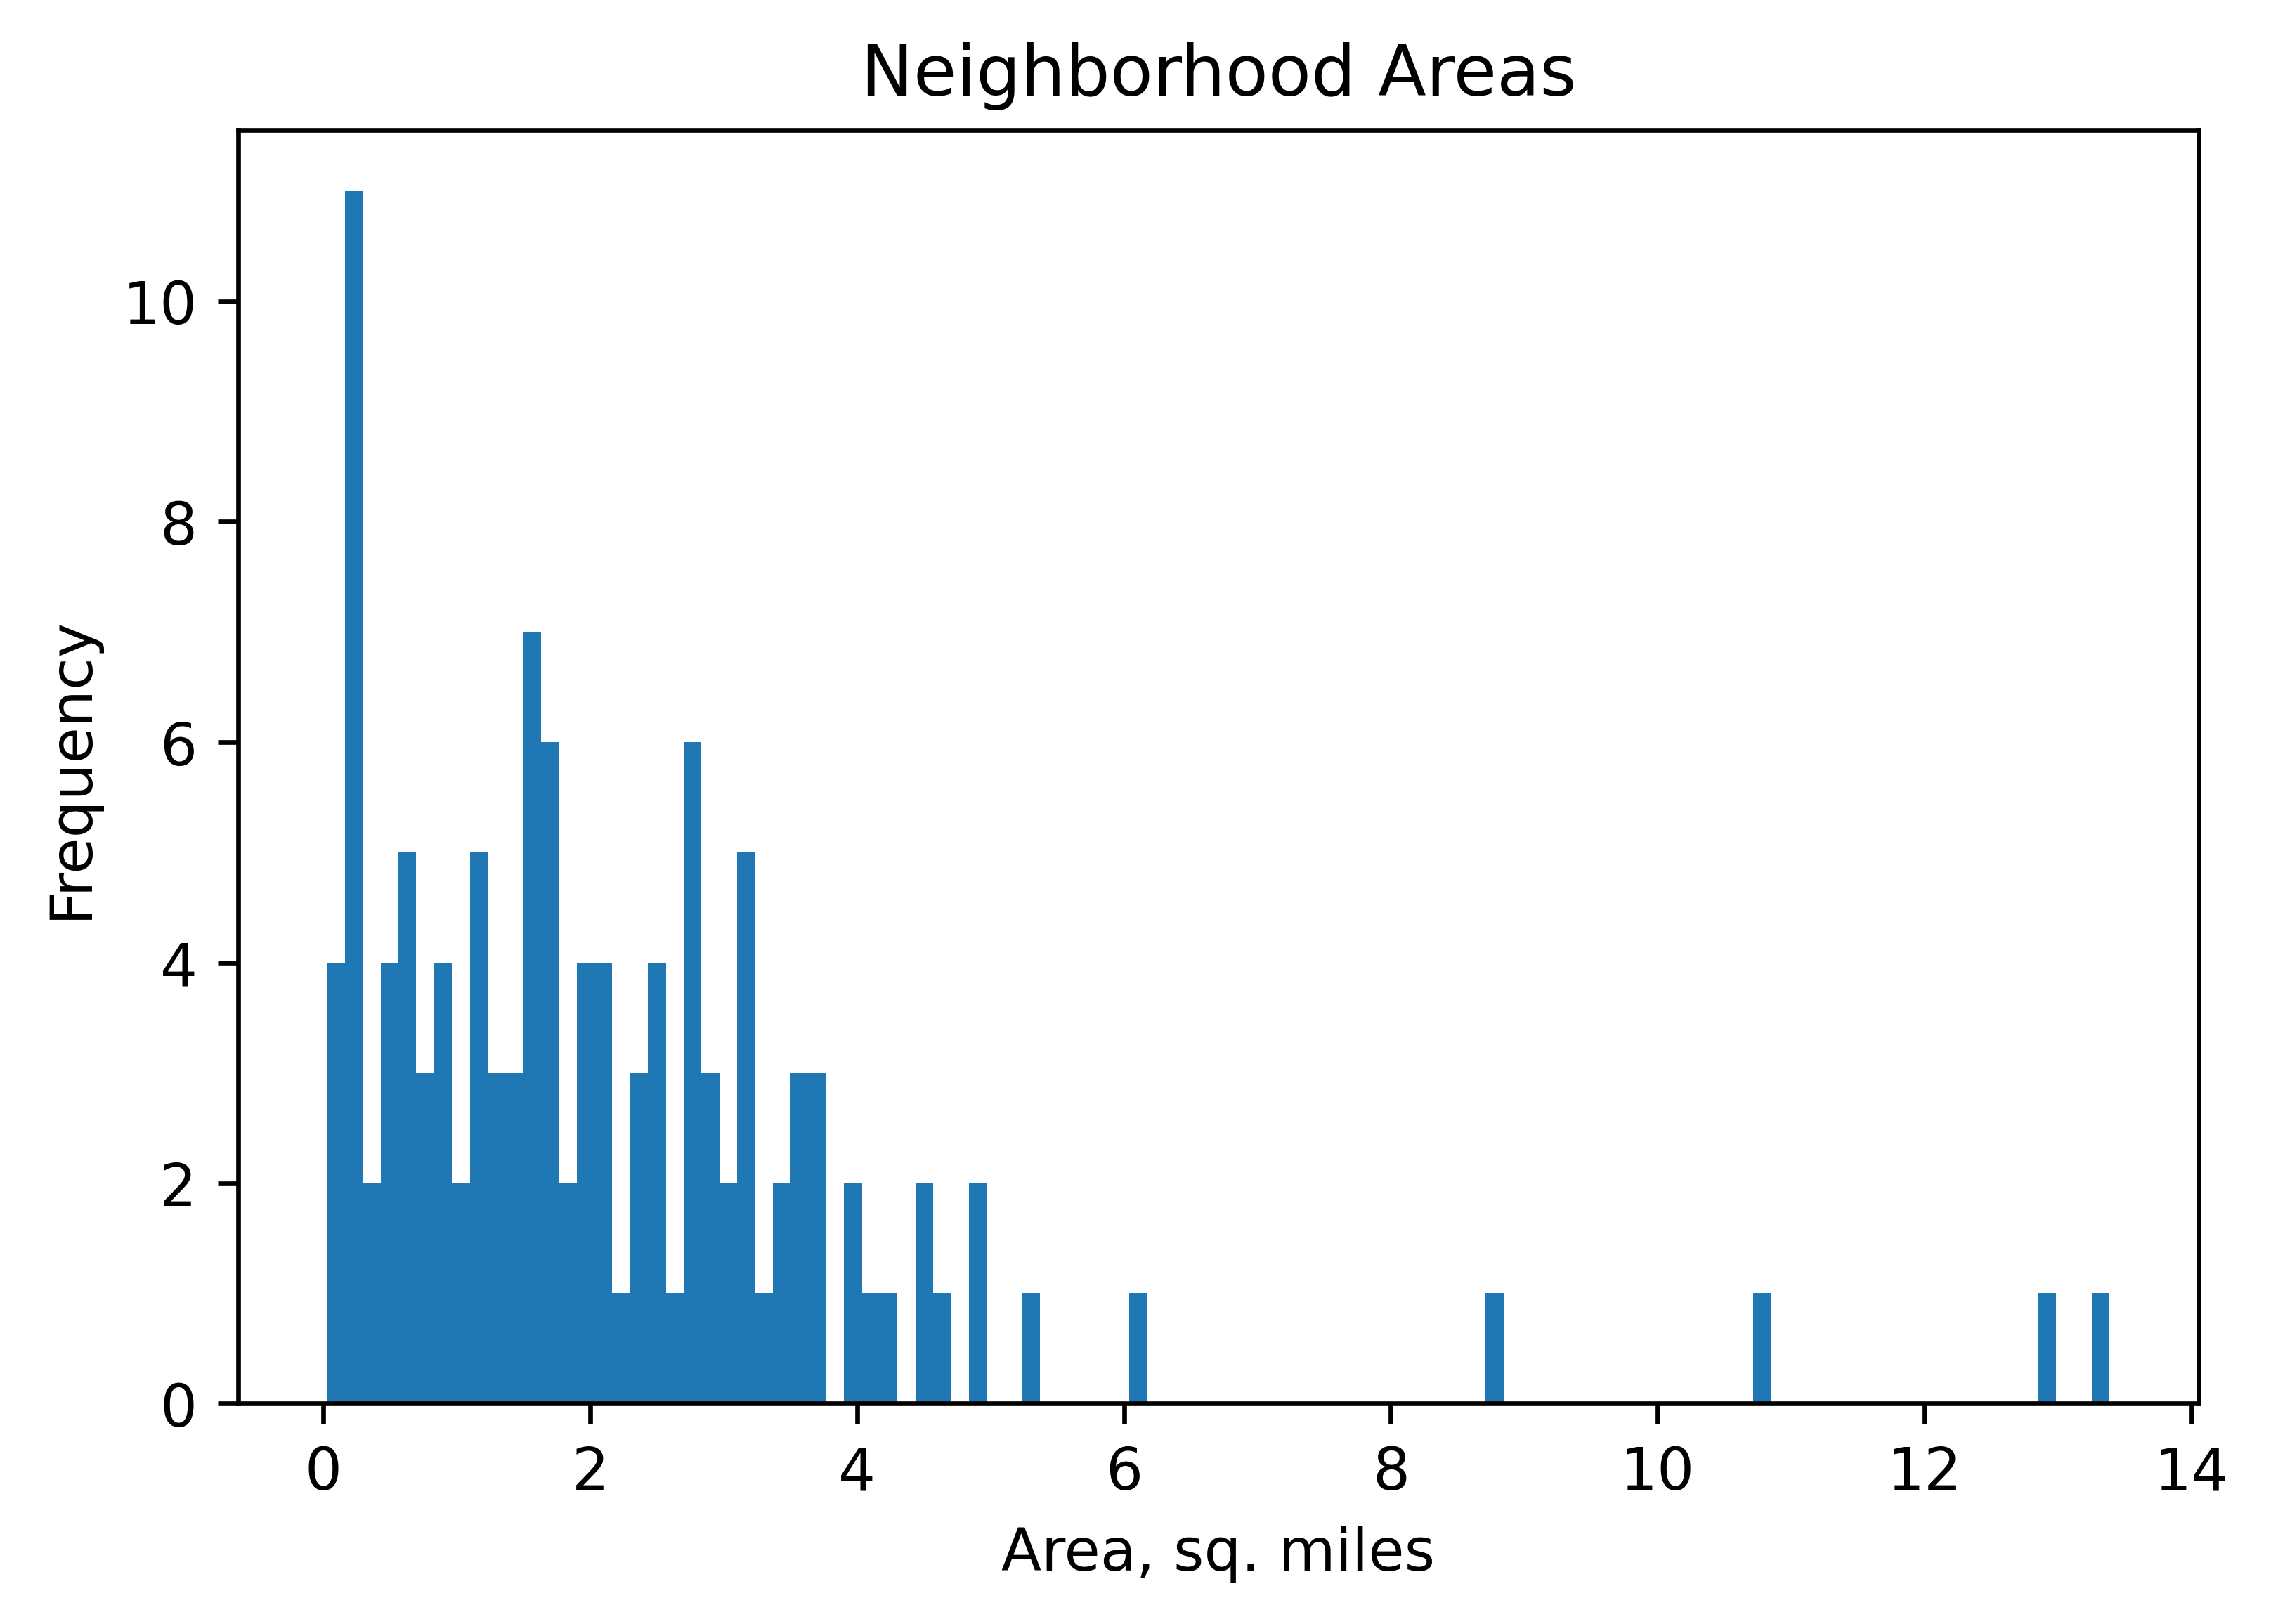

In [111]:
df.area.plot(kind='hist', bins = 100)
plt.title('Neighborhood Areas')
plt.xlabel('Area, sq. miles')
plt.ylabel('Frequency')

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 1.0, 'Neighborhood Areas')

Text(0.5, 0, 'Area, acres')

Text(0, 0.5, 'Frequency')

(0.0, 1.0)

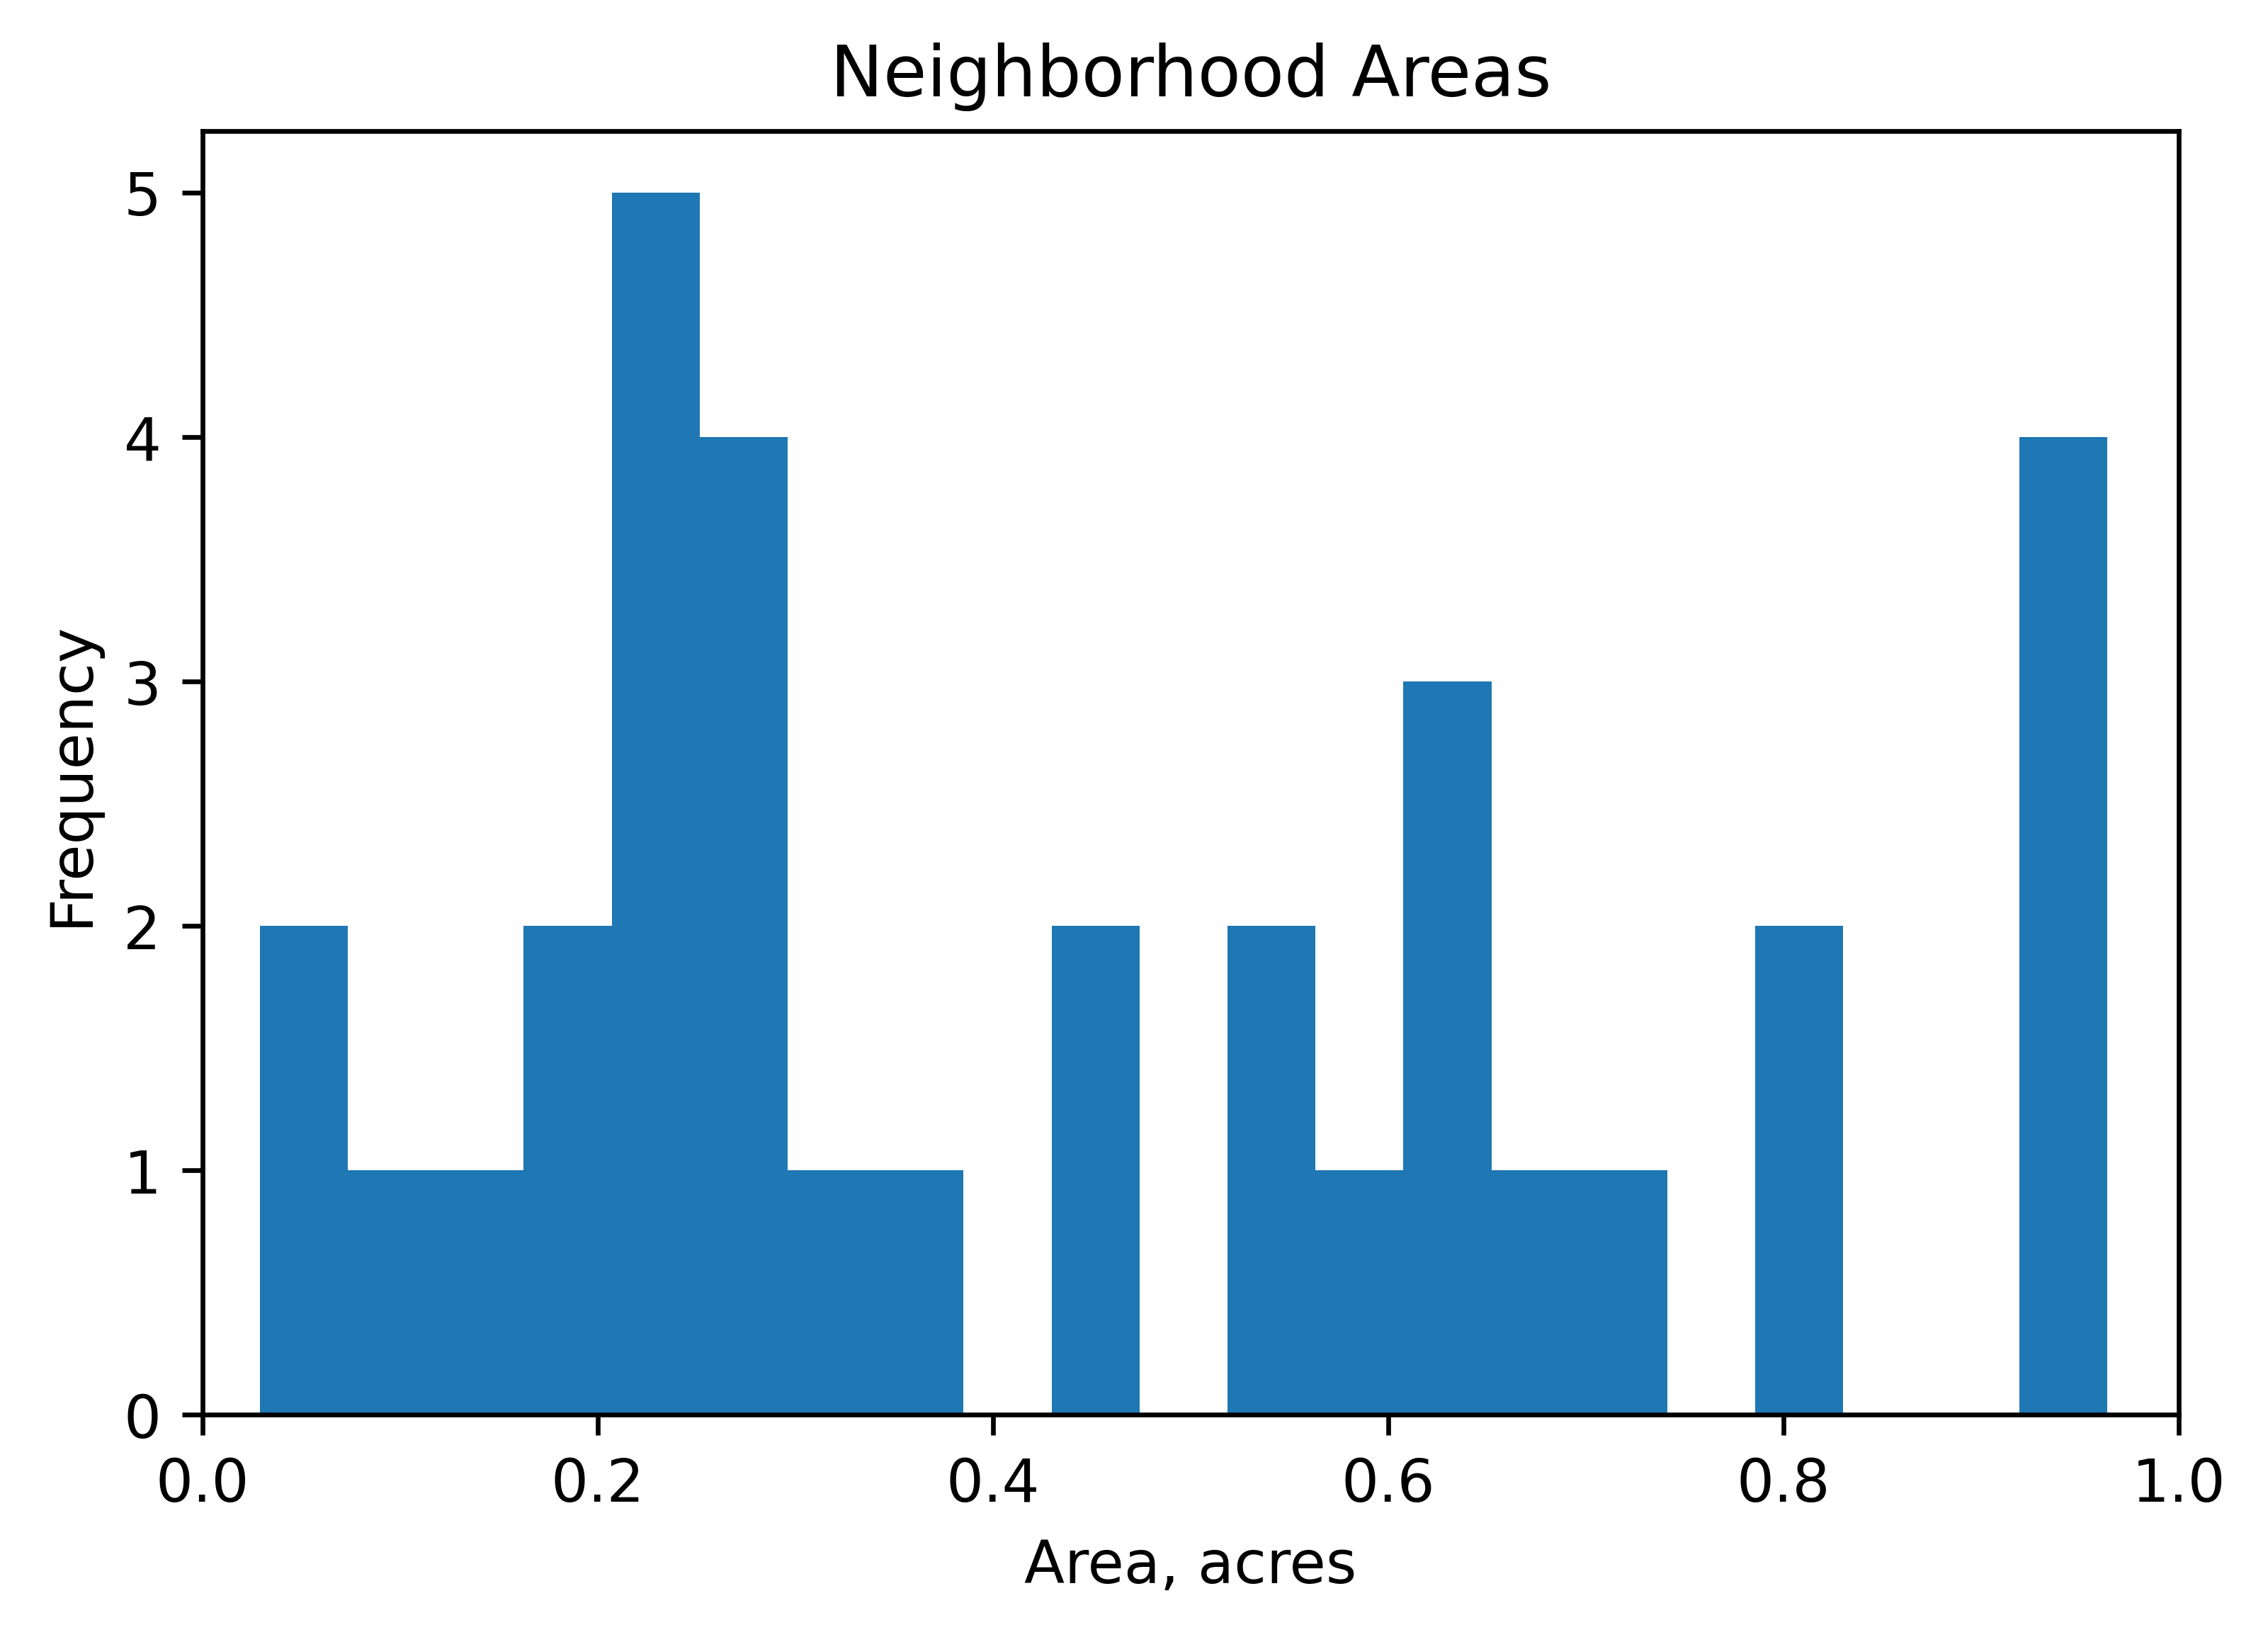

In [112]:
df.area.plot(kind='hist', bins = 300)
plt.title('Neighborhood Areas')
plt.xlabel('Area, acres')
plt.ylabel('Frequency')
plt.xlim([0,1])

+ It appears that area field has outliers. Let's explore it further via boxplot

<AxesSubplot:>

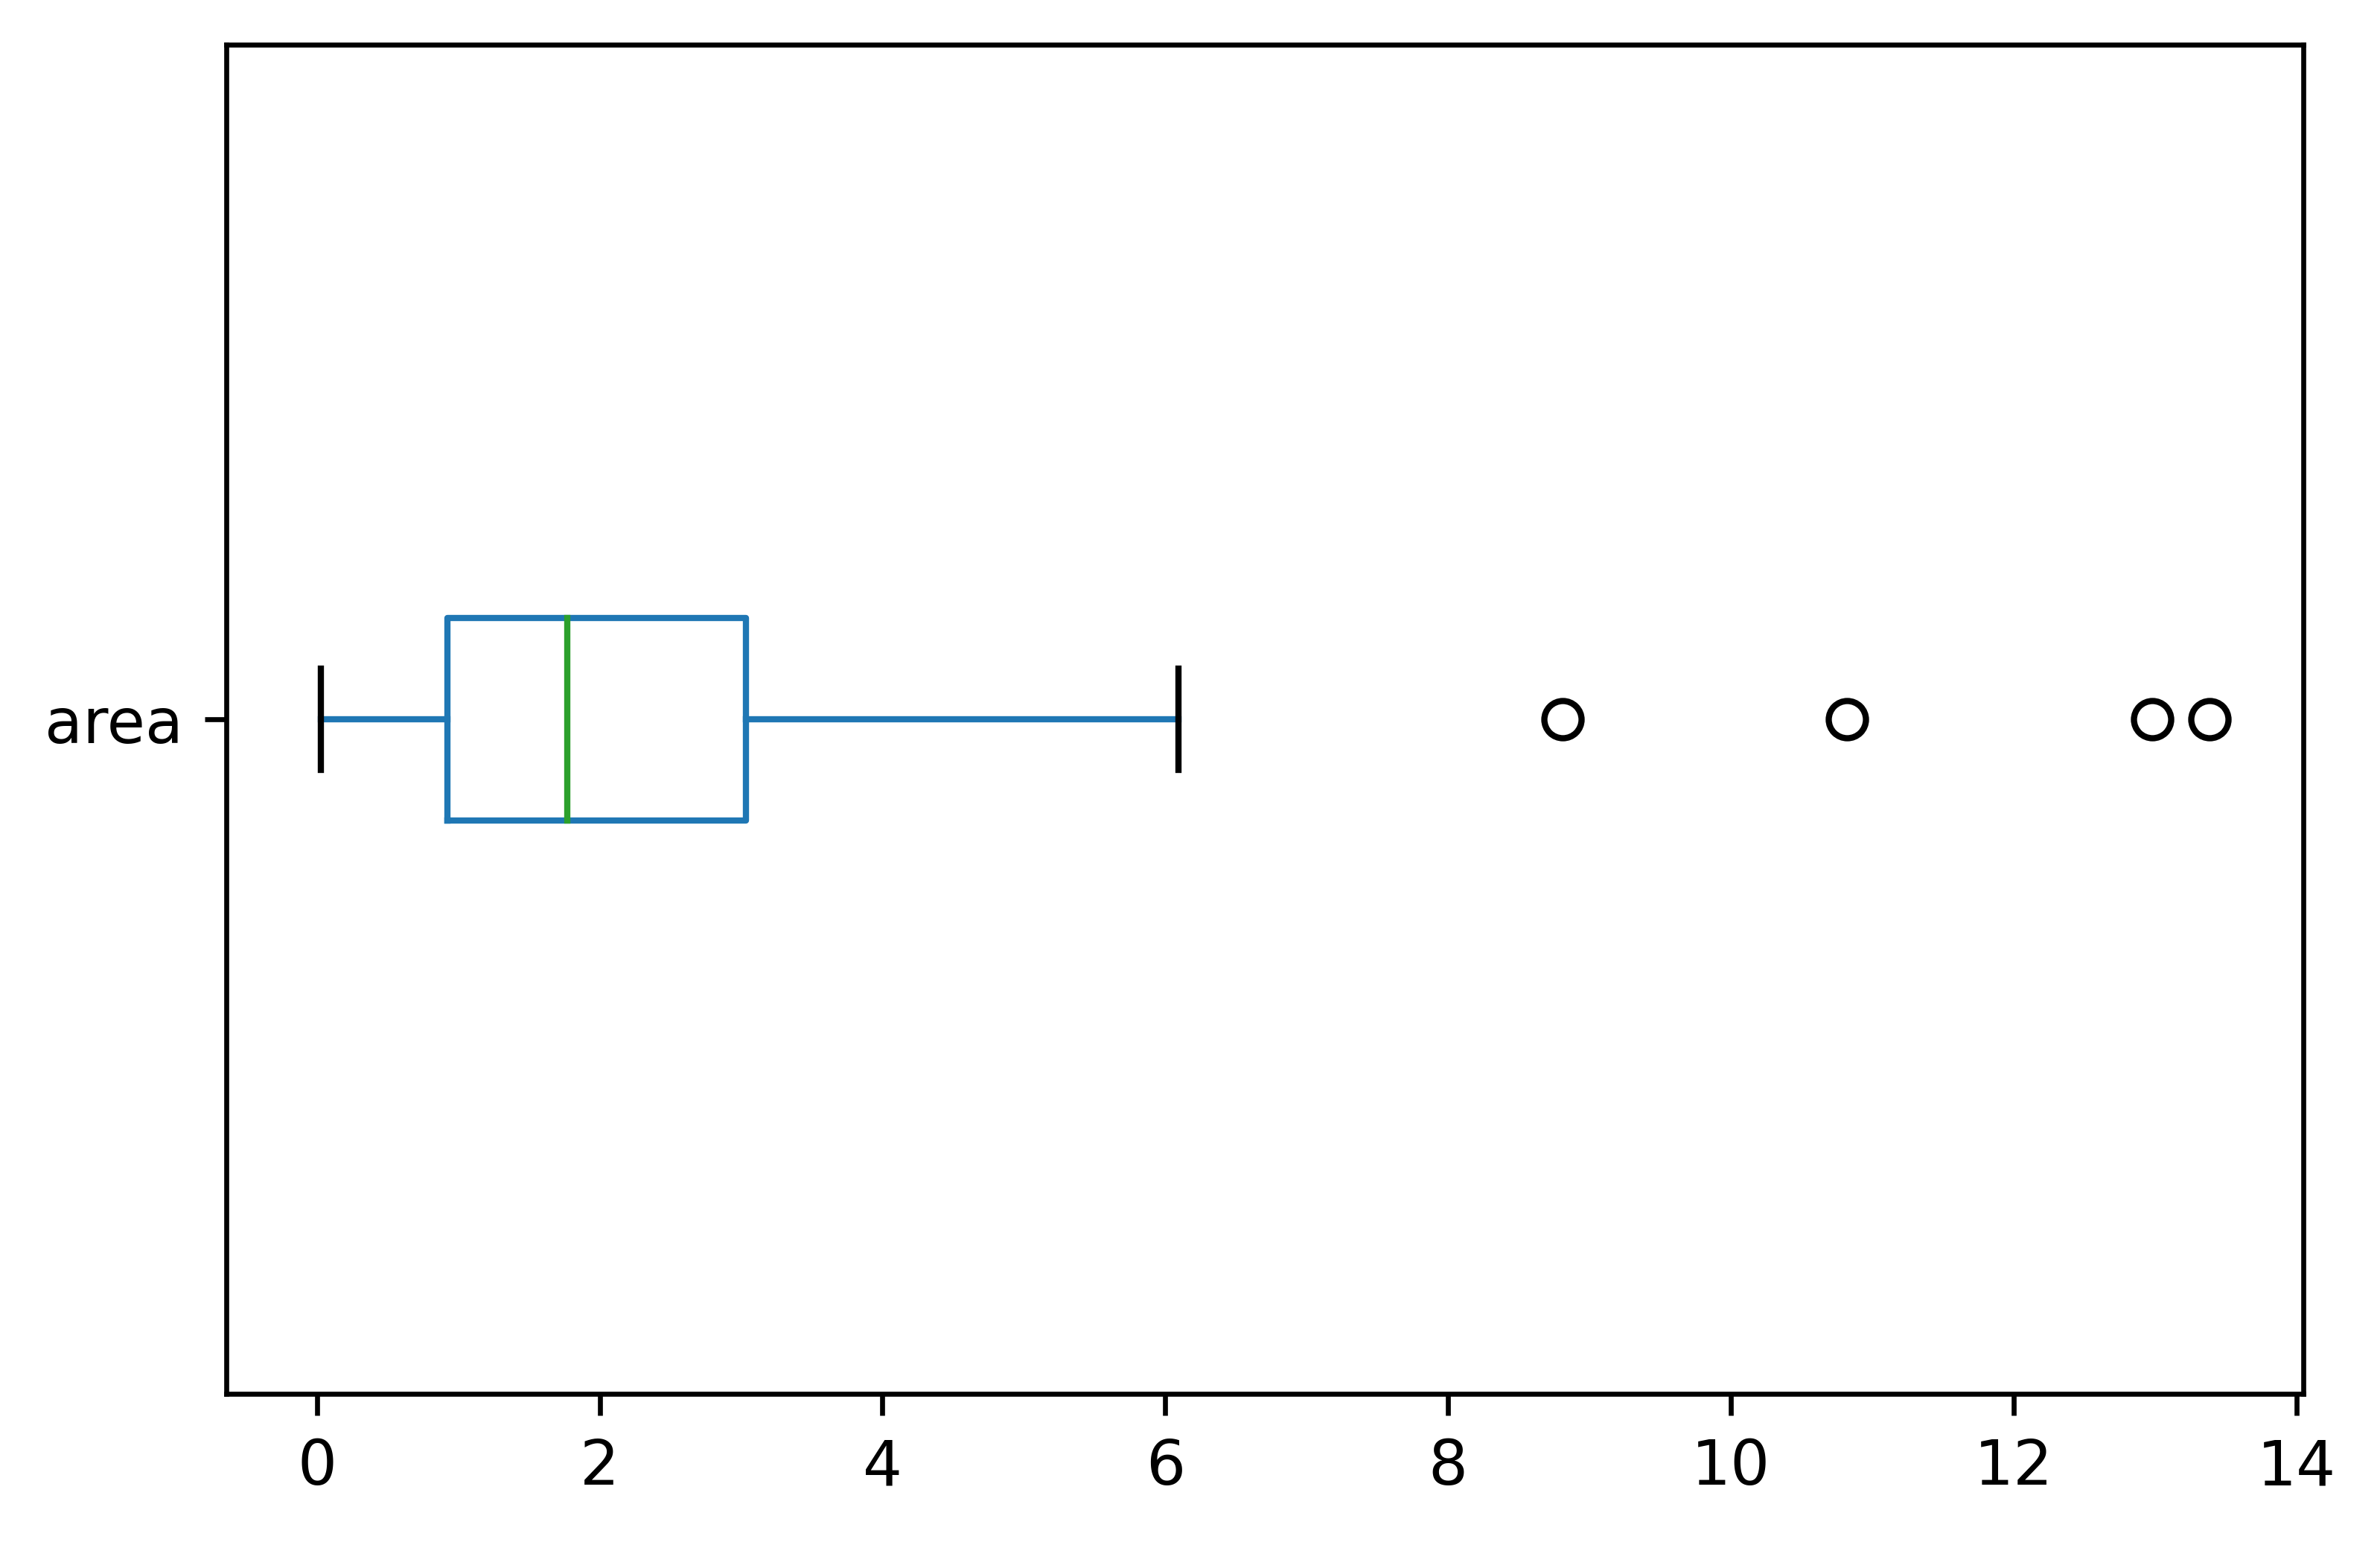

In [113]:
df.area.plot(kind='box', vert = False)

+ There is something going on here. Assuming that one house takes approximately 0.5 acres., let's discard neighborhoods with less than 4 houses (2/122 sq. miles):

In [114]:
df_areas = df[df.area >= 2.0/122]

+ Also, the neighborhood with the largest area is O'Hare in Chicago:

In [115]:
df_areas[df_areas.area > 7]

area  population  avg household size  \
Neighborhood                                                         
Brook Park, Brook Park, OH  12.979       25488                 4.2   
Lawndale, Chicago, IL        8.810      130518                 5.9   
O'Hare, Chicago, IL         13.384        6258                 3.8   
South Deering, Chicago, IL  10.822      124471                 2.8   

                            avg number of cars apts  \
Neighborhood                                          
Brook Park, Brook Park, OH                      1.4   
Lawndale, Chicago, IL                           0.9   
O'Hare, Chicago, IL                             1.6   
South Deering, Chicago, IL                      1.0   

                            avg number of cars houses    males  \
Neighborhood                                                     
Brook Park, Brook Park, OH                        2.3  12744.0   
Lawndale, Chicago, IL                             1.8  65259.0   
O'Hare, Chicago, IL                               2.2   3129.0   
South Deering, Chicago, IL                        1.6  62235.5   

                            med age females  med age males  \
Neighborhood                                                 
Brook Park, Brook Park, OH             46.3           41.7   
Lawndale, Chicago, IL                  33.2           30.1   
O'Hare, Chicago, IL                    40.5           37.2   
South Deering, Chicago, IL             37.1           34.2   

                            med household income  med rent  ...  \
Neighborhood                                                ...   
Brook Park, Brook Park, OH               55566.0     709.0  ...   
Lawndale, Chicago, IL                    39517.0     746.0  ...   
O'Hare, Chicago, IL                      60953.0     932.0  ...   
South Deering, Chicago, IL               42636.0     868.0  ...   

                            Warehouse Store  Waterfront  Whisky Bar  Wine Bar  \
Neighborhood                                                                    
Brook Park, Brook Park, OH             0.01         0.0         0.0      0.01   
Lawndale, Chicago, IL                  0.01         0.0         0.0      0.00   
O'Hare, Chicago, IL                    0.00         0.0         0.0      0.00   
South Deering, Chicago, IL             0.01         0.0         0.0      0.00   

                            Wine Shop  Winery  Wings Joint  Women's Store  \
Neighborhood                                                                
Brook Park, Brook Park, OH        0.0     0.0         0.00           0.00   
Lawndale, Chicago, IL             0.0     0.0         0.00           0.00   
O'Hare, Chicago, IL               0.0     0.0         0.00           0.01   
South Deering, Chicago, IL        0.0     0.0         0.02           0.00   

                            Yoga Studio  Zoo  
Neighborhood                                  
Brook Park, Brook Park, OH         0.00  0.0  
Lawndale, Chicago, IL              0.02  0.0  
O'Hare, Chicago, IL                0.01  0.0  
South Deering, Chicago, IL         0.00  0.0  

[4 rows x 315 columns]

<AxesSubplot:>

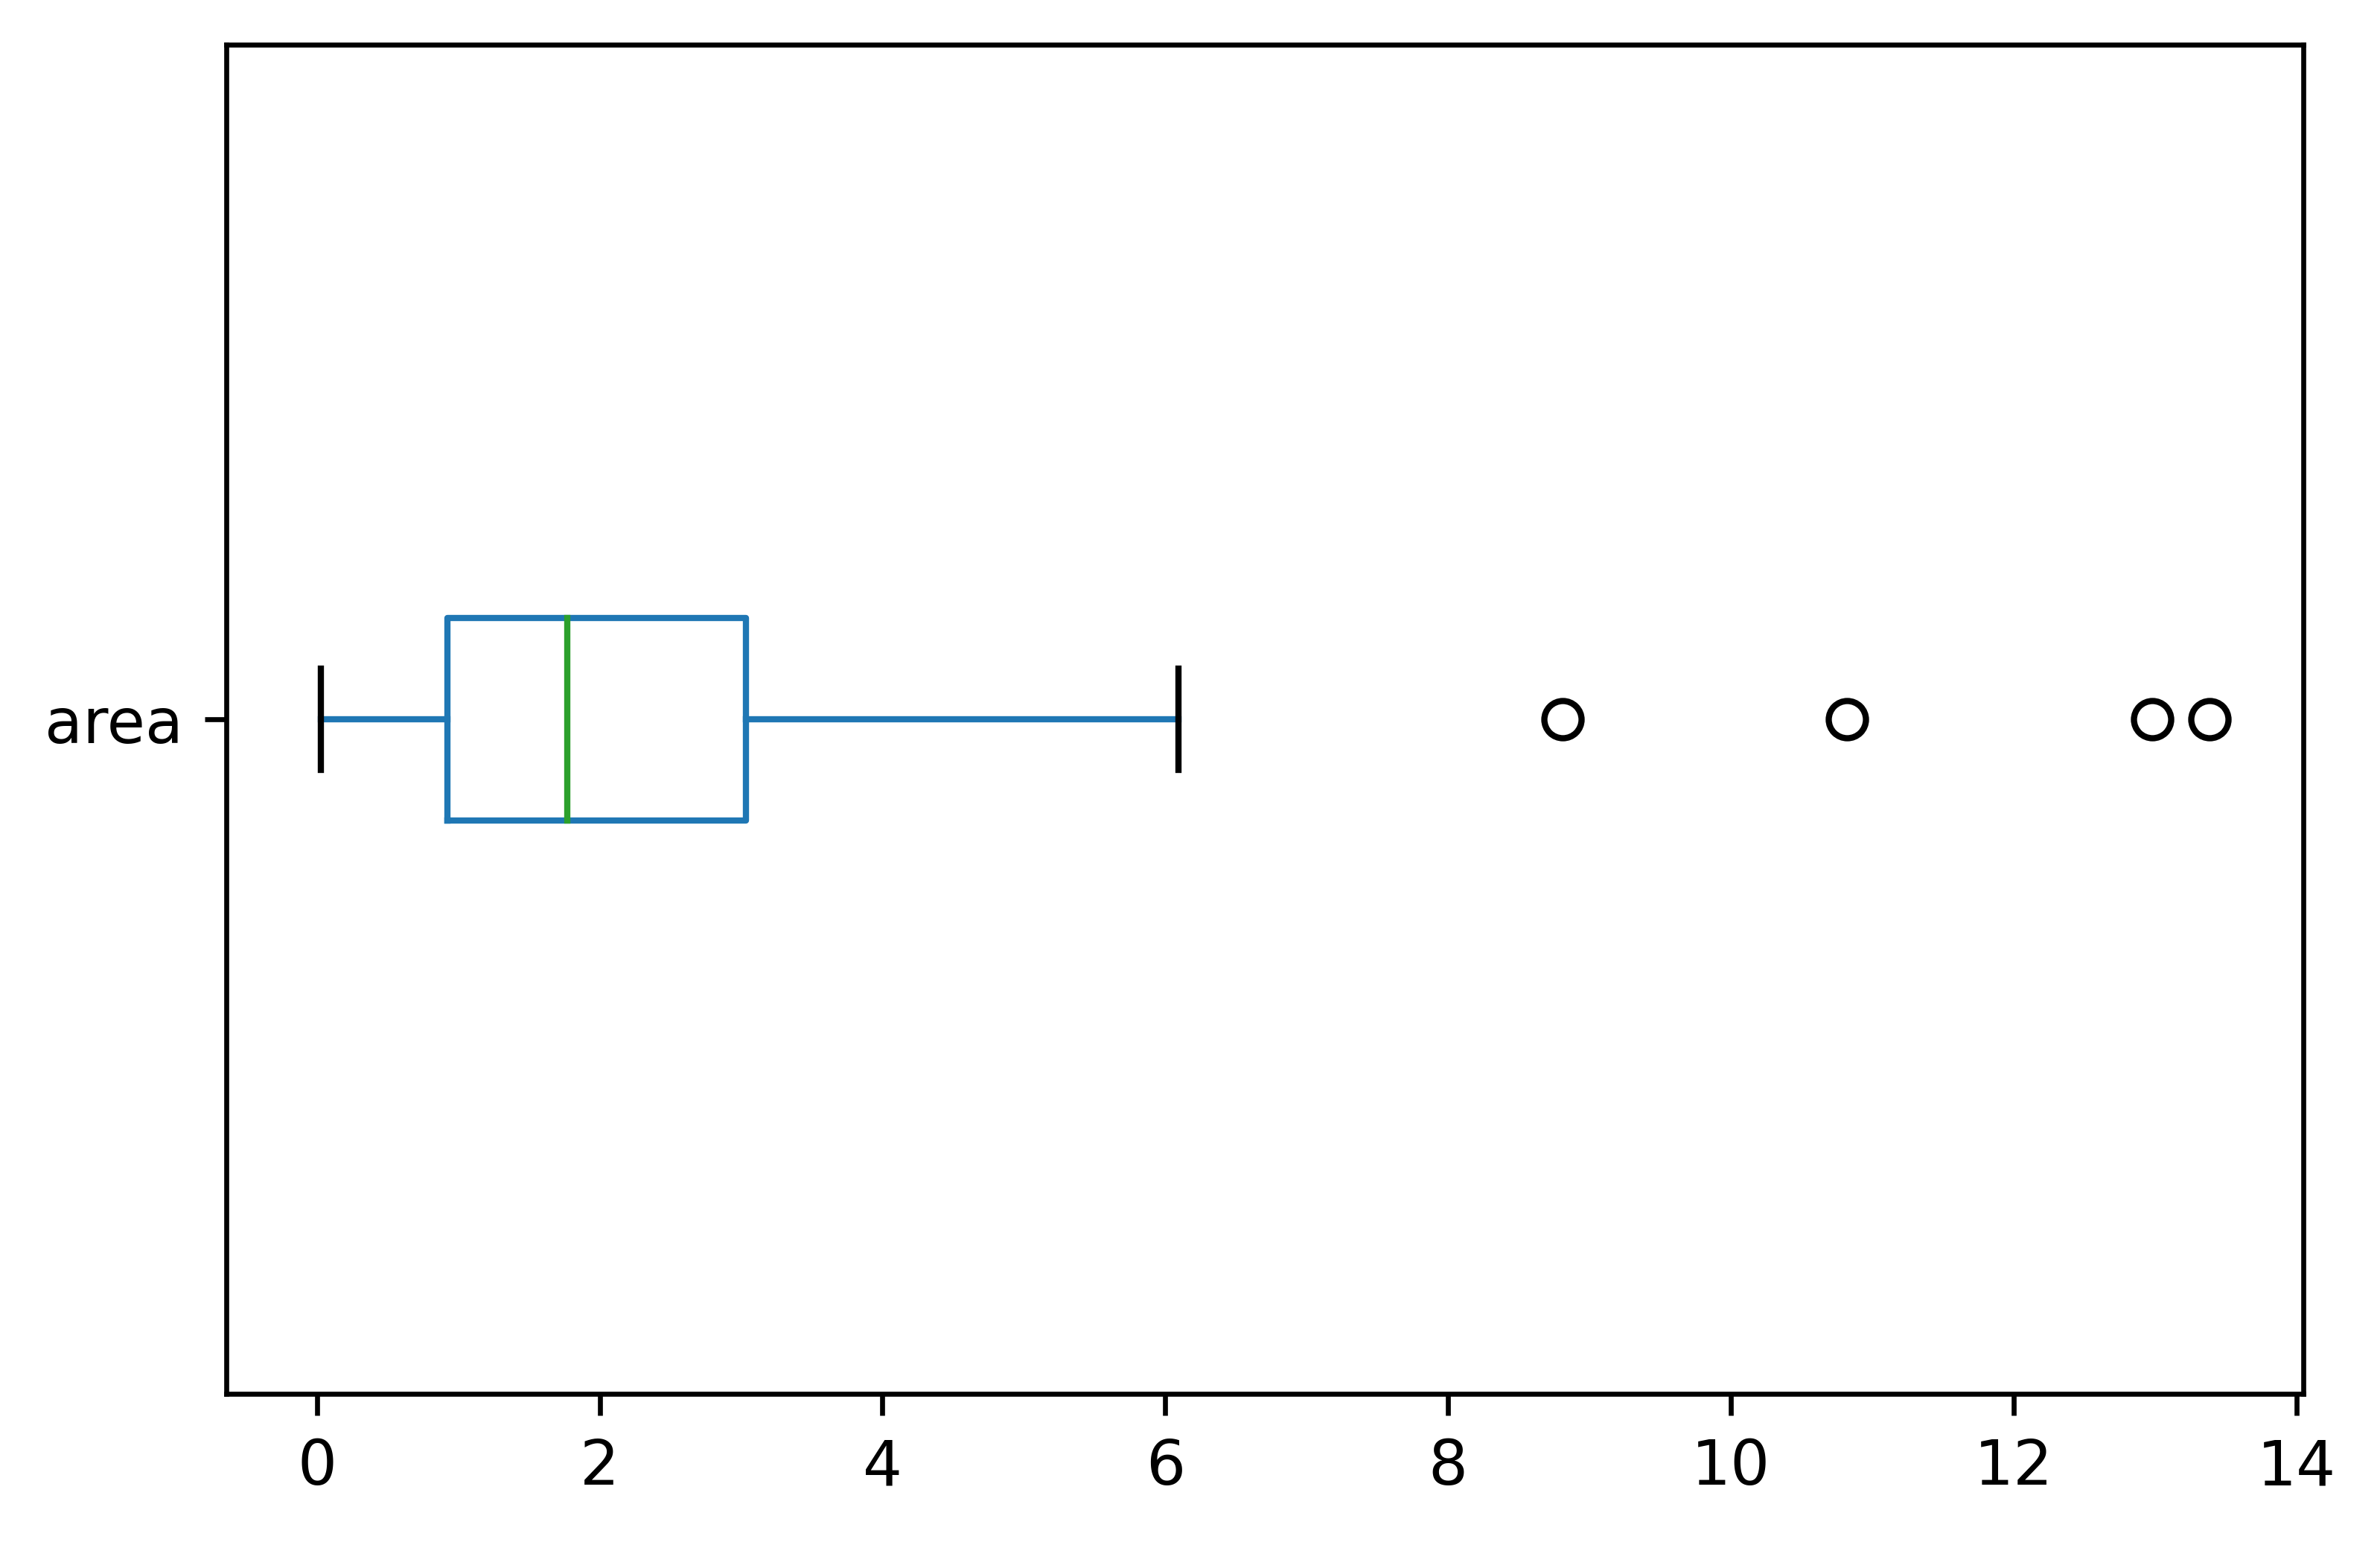

In [116]:
df_areas.area.plot(kind='box', vert = False)
# plt.xlim([0,0.5])

<AxesSubplot:>

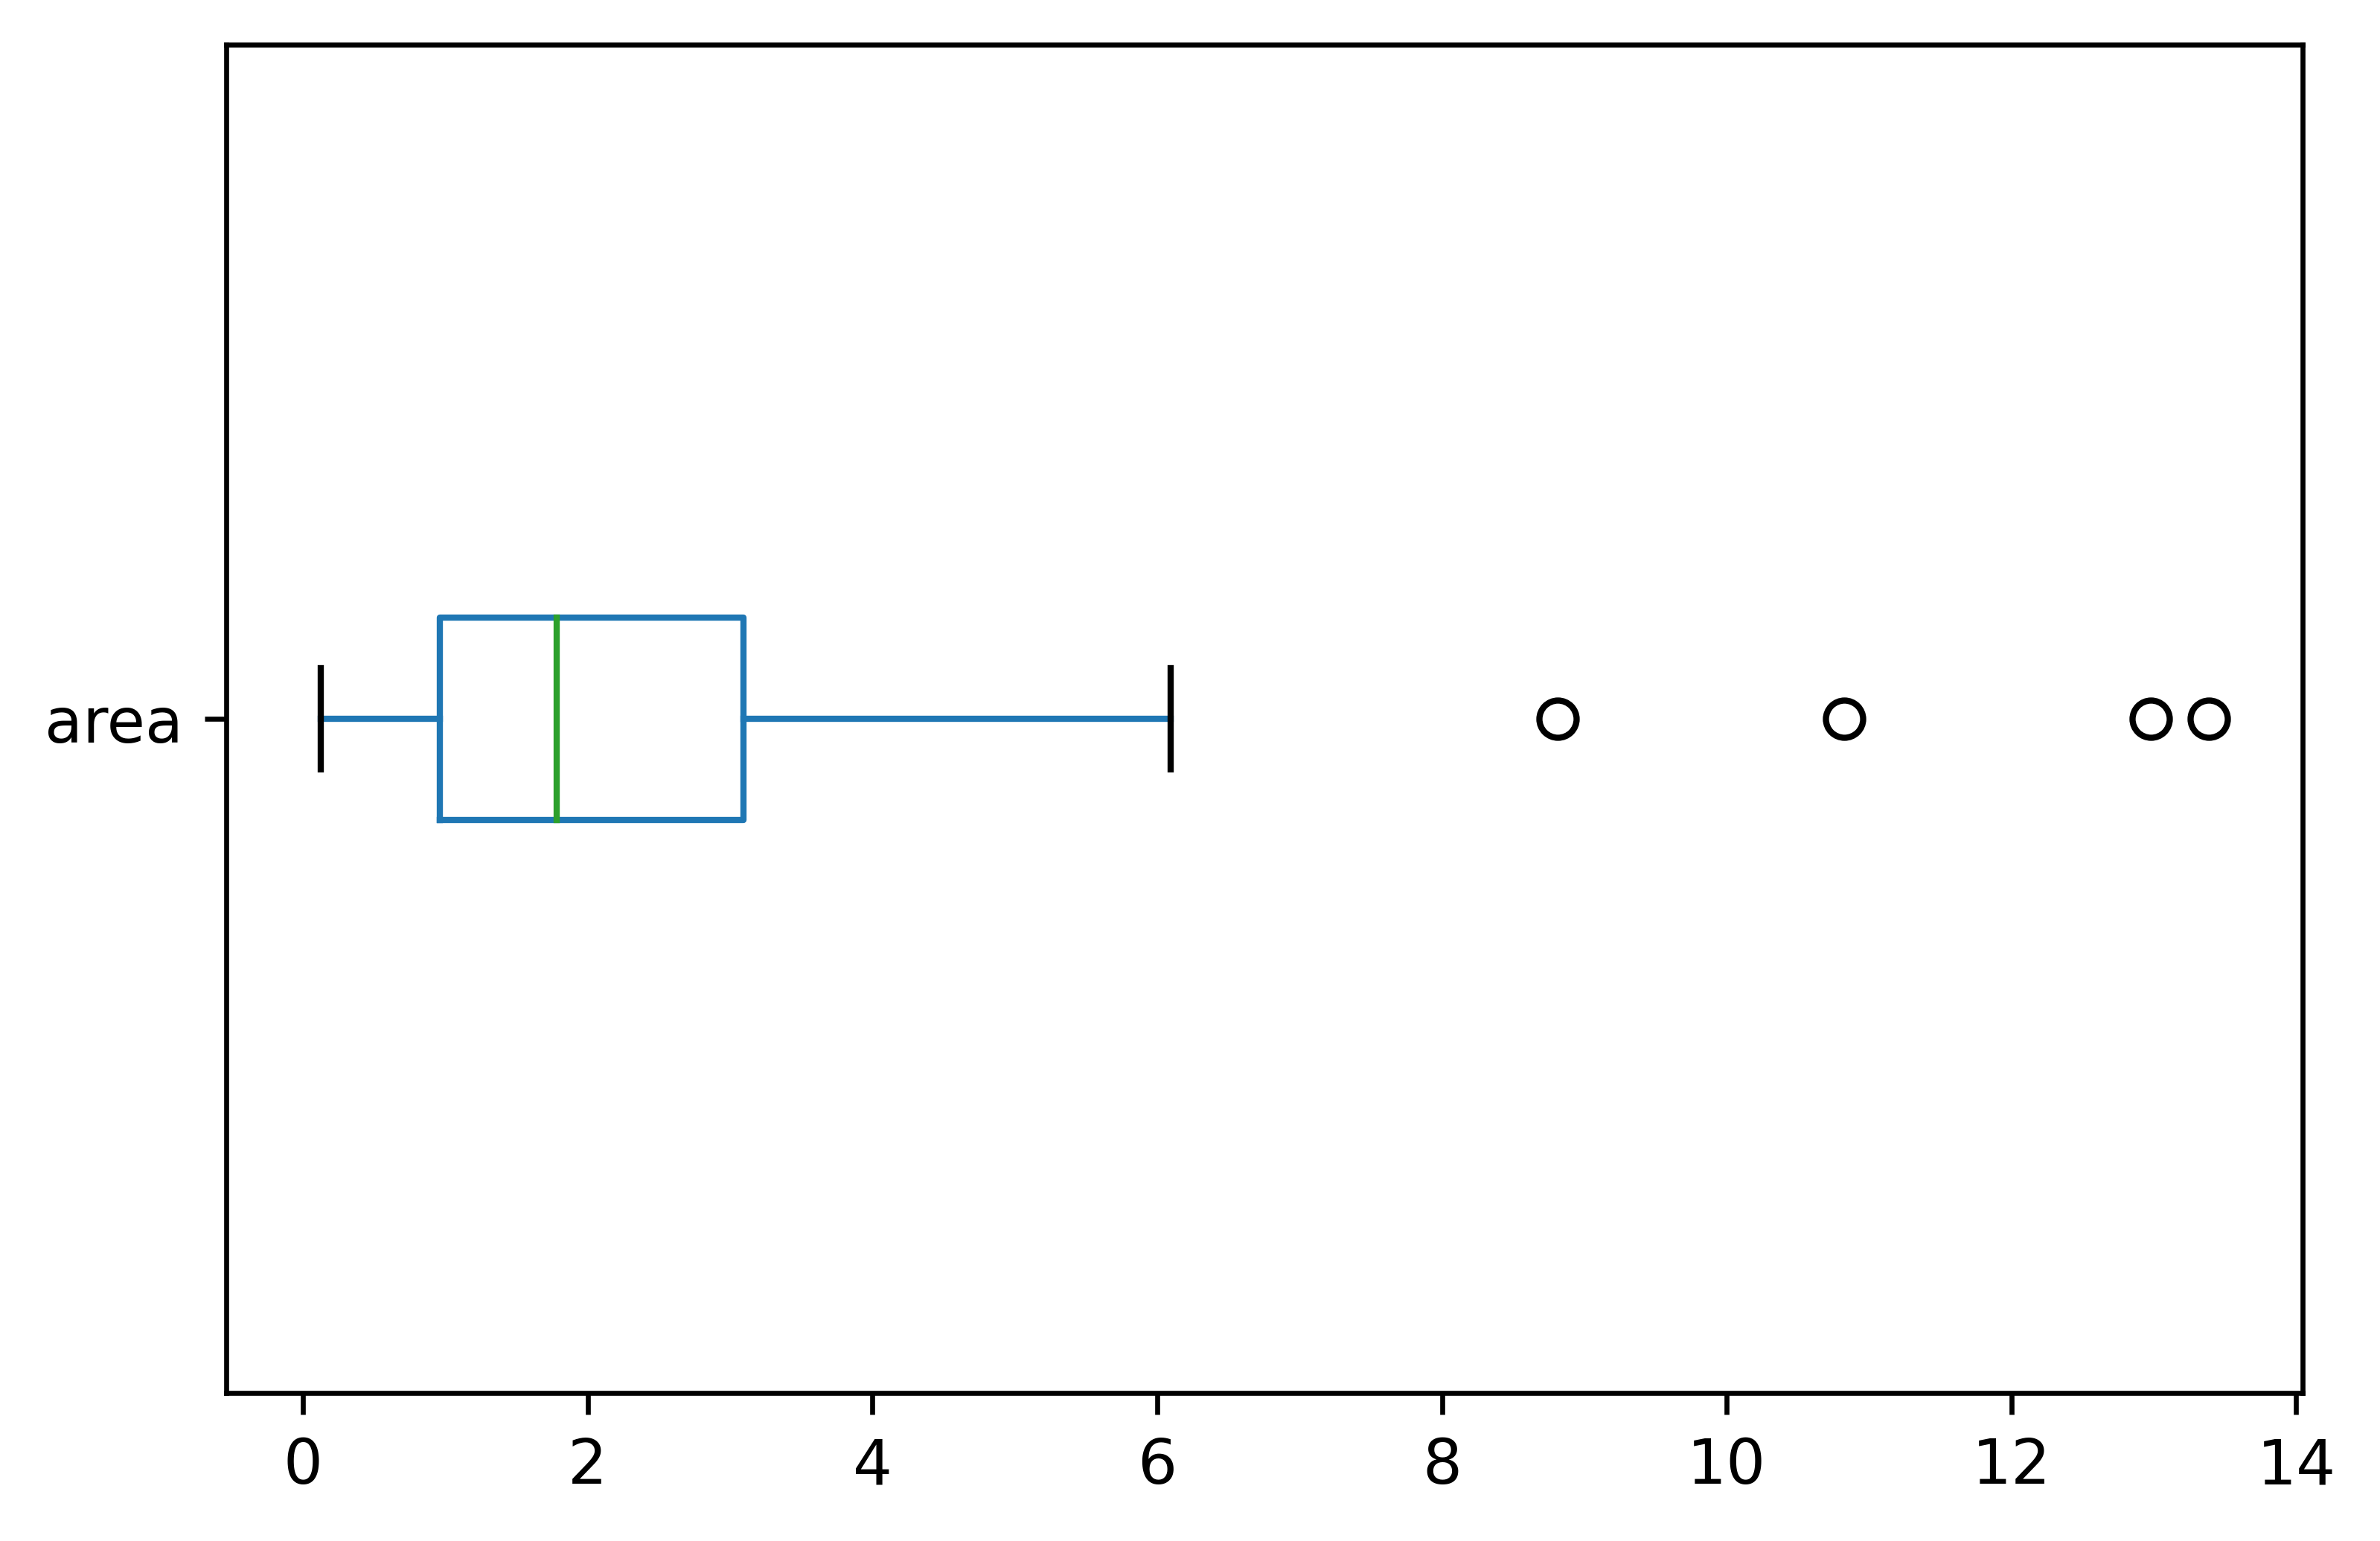

In [117]:
df_areas[df_areas.area > 0.1].area.plot(kind='box', vert = False)

+ Brook Park neighborhood is the top outlier and majority of neighborhoods in Chicago have way smaller area. One possible reason is that neighborhoods in the dataset are 'split', i.e. multiple rows represent the same neighborhood. Area will be excluded from further analysis

---
### Average household size

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 0, 'Average household size')

Text(0.5, 1.0, 'Average household size')

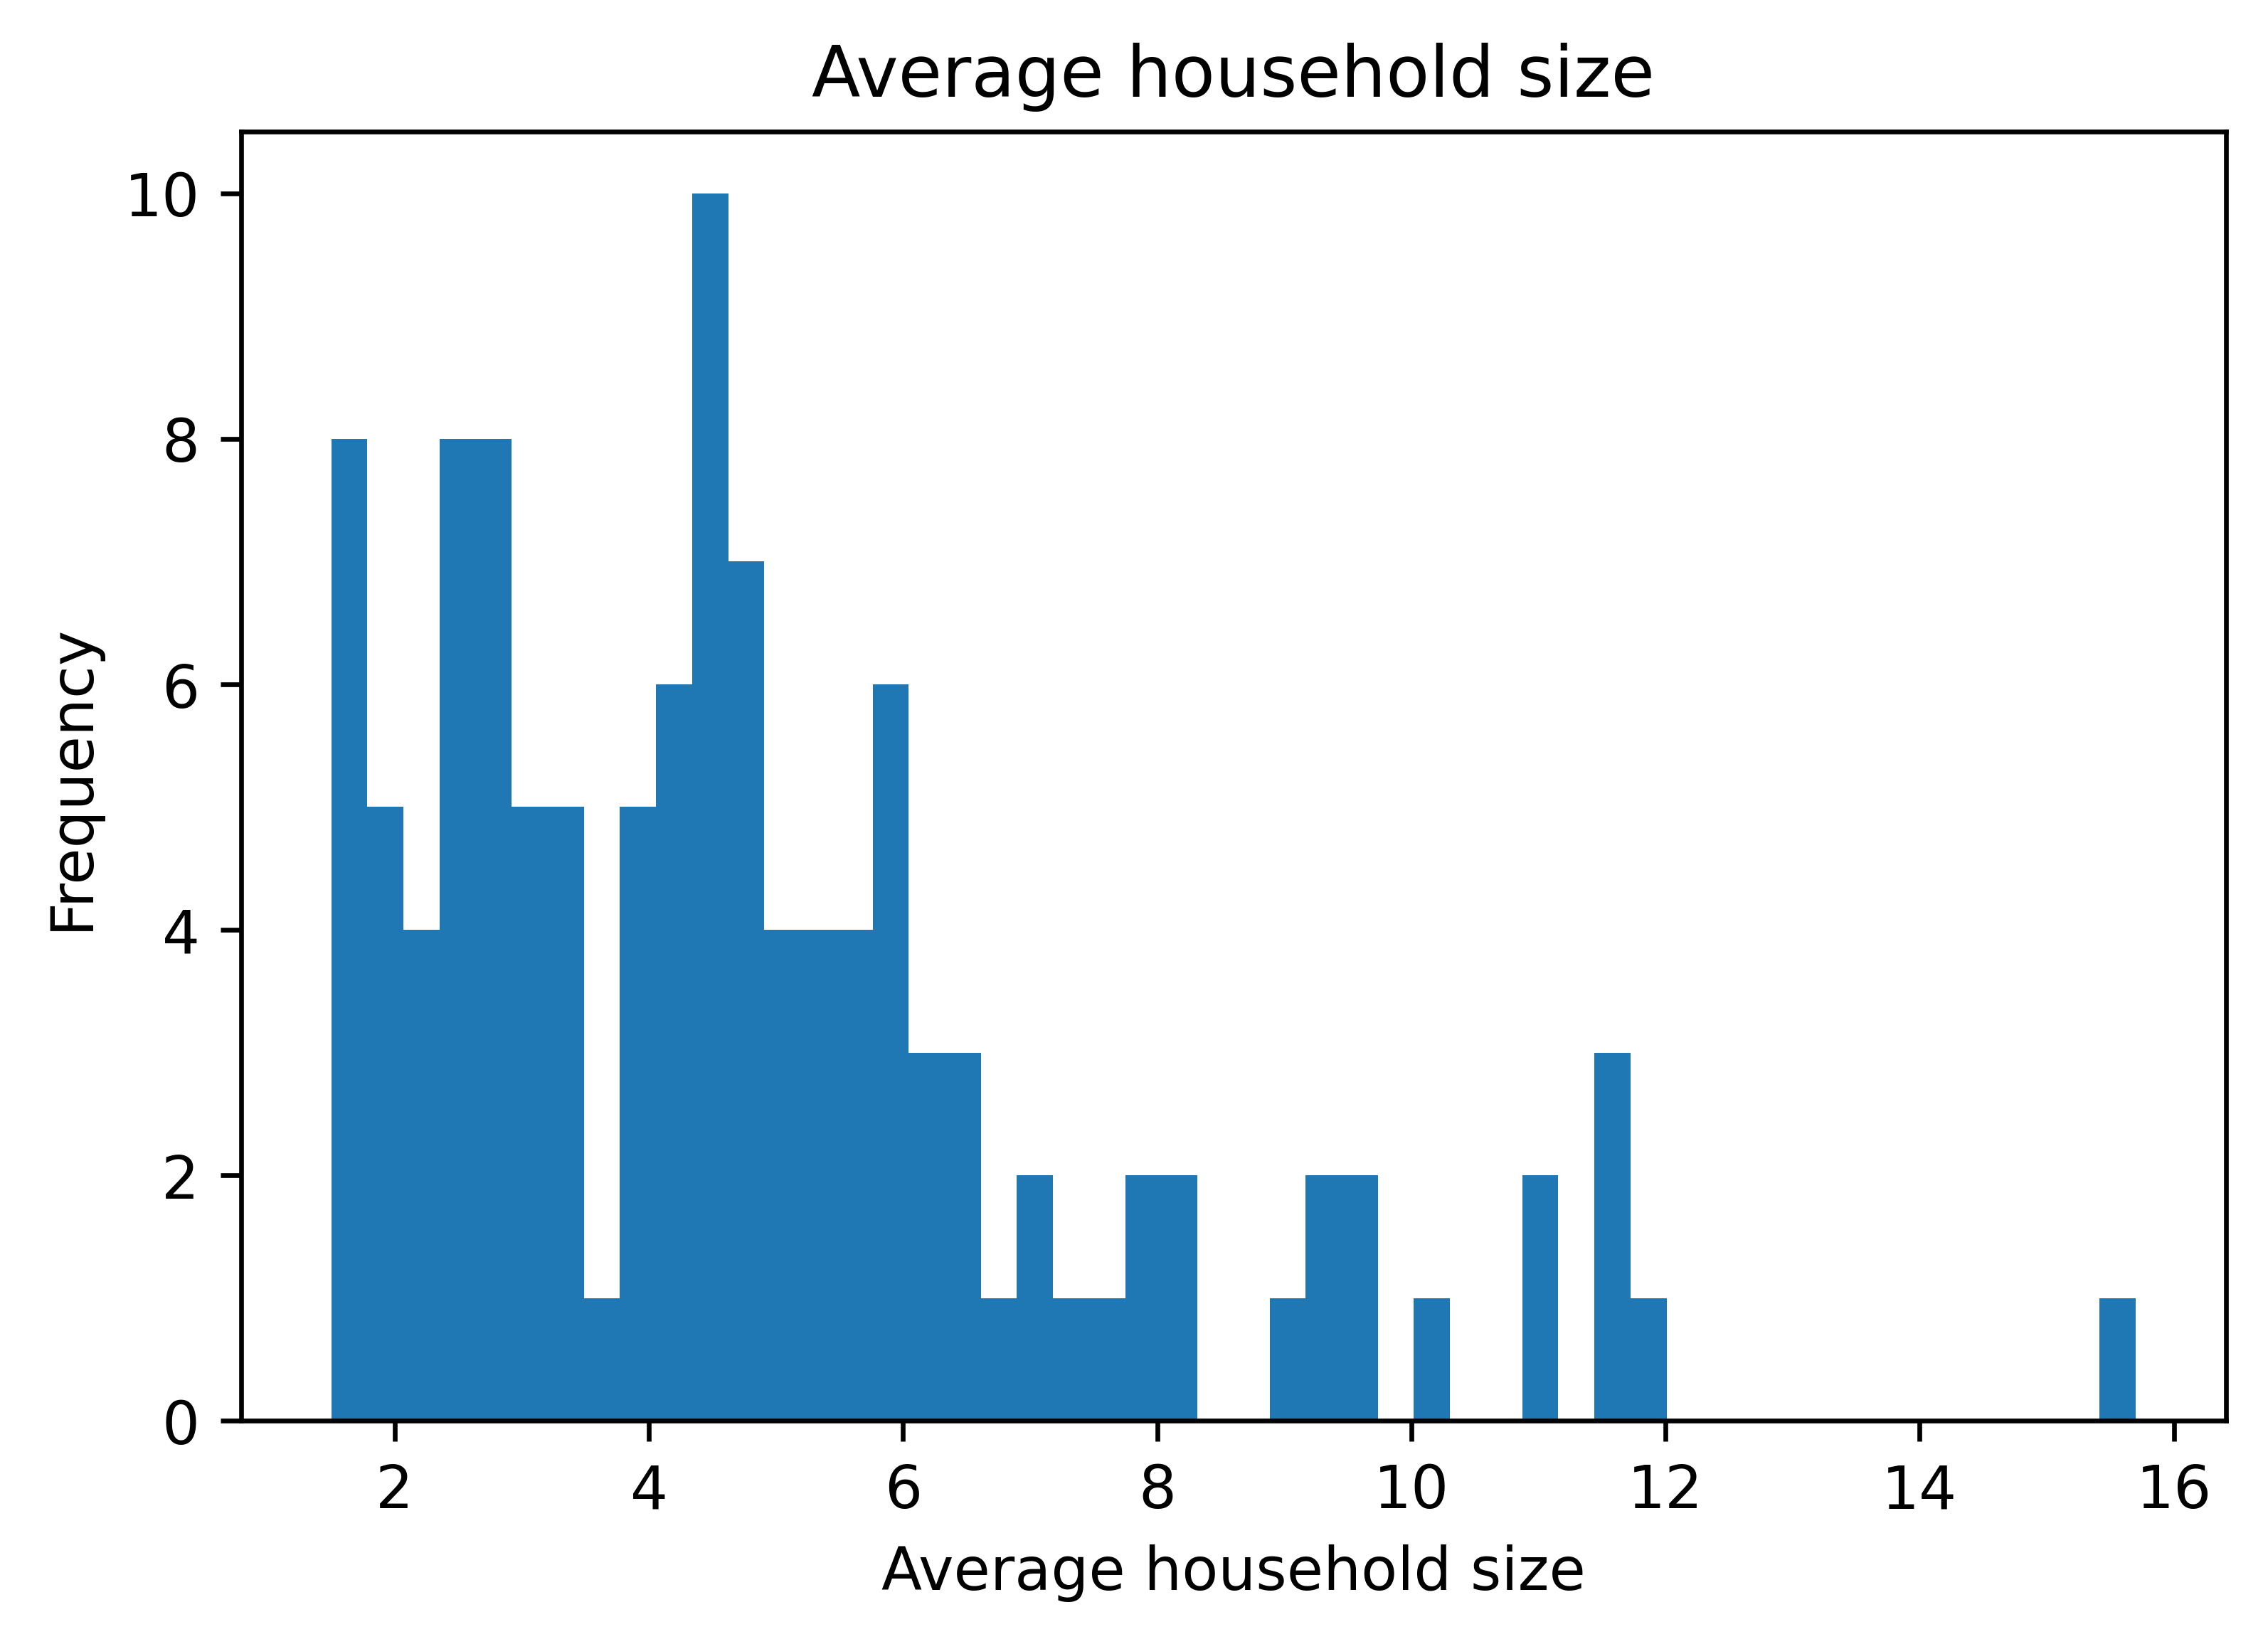

In [118]:
df['avg household size'].plot(kind='hist', bins = 50)
plt.xlabel('Average household size')
plt.title('Average household size')

In [119]:
df[df['avg household size'] > 10]

area  population  avg household size  \
Neighborhood                                                             
Archer Heights, Chicago, IL      1.966       20099                10.9   
Ashburn, Chicago, IL             4.900       41856                10.9   
Bucktown, Chicago, IL            1.021       26964                11.7   
Canaryville, Chicago, IL         0.672       15620                15.7   
East Garfield Park, Chicago, IL  1.915       30769                11.7   
Gage Park, Chicago, IL           2.200       39014                11.8   
Noble Square, Chicago, IL        1.781       56916                10.2   
Wicker Park, Chicago, IL         0.958       27038                11.5   

                                 avg number of cars apts  \
Neighborhood                                               
Archer Heights, Chicago, IL                          1.1   
Ashburn, Chicago, IL                                 1.9   
Bucktown, Chicago, IL                                1.1   
Canaryville, Chicago, IL                             1.1   
East Garfield Park, Chicago, IL                      0.5   
Gage Park, Chicago, IL                               1.1   
Noble Square, Chicago, IL                            1.0   
Wicker Park, Chicago, IL                             1.0   

                                 avg number of cars houses    males  \
Neighborhood                                                          
Archer Heights, Chicago, IL                            1.9  10049.5   
Ashburn, Chicago, IL                                   2.2  20928.0   
Bucktown, Chicago, IL                                  1.4  13482.0   
Canaryville, Chicago, IL                               1.9   7810.0   
East Garfield Park, Chicago, IL                        1.6  15384.5   
Gage Park, Chicago, IL                                 1.9  19507.0   
Noble Square, Chicago, IL                              1.3  28458.0   
Wicker Park, Chicago, IL                               1.3  13519.0   

                                 med age females  med age males  \
Neighborhood                                                      
Archer Heights, Chicago, IL                 32.5           31.8   
Ashburn, Chicago, IL                        36.9           32.2   
Bucktown, Chicago, IL                       32.0           31.4   
Canaryville, Chicago, IL                    38.6           34.6   
East Garfield Park, Chicago, IL             34.6           29.3   
Gage Park, Chicago, IL                      29.0           30.6   
Noble Square, Chicago, IL                   31.3           32.1   
Wicker Park, Chicago, IL                    32.0           32.2   

                                 med household income  med rent  ...  \
Neighborhood                                                     ...   
Archer Heights, Chicago, IL                   53024.0     799.0  ...   
Ashburn, Chicago, IL                          60532.0    1103.0  ...   
Bucktown, Chicago, IL                        128536.0    1668.0  ...   
Canaryville, Chicago, IL                      38663.0     742.0  ...   
East Garfield Park, Chicago, IL               33512.0     716.0  ...   
Gage Park, Chicago, IL                        46215.0     718.0  ...   
Noble Square, Chicago, IL                    124093.0    1549.0  ...   
Wicker Park, Chicago, IL                     125726.0    1665.0  ...   

                                 Warehouse Store  Waterfront  Whisky Bar  \
Neighborhood                                                               
Archer Heights, Chicago, IL                 0.01        0.00         0.0   
Ashburn, Chicago, IL                        0.01        0.00         0.0   
Bucktown, Chicago, IL                       0.00        0.00         0.0   
Canaryville, Chicago, IL                    0.01        0.02         0.0   
East Garfield Park, Chicago, IL             0.00        0.00         0.0   
Gage Park, Chicago, IL                      0.00        0

+ Neighborhoods with more than 10 people on average per household do not appear legit. Let's clean them

In [120]:
df_household = df[(df['avg household size'] < 10)]
df_household.shape
df_household

(110, 315)

area  population  avg household size  \
Neighborhood                                                         
Albany Park, Chicago, IL     1.915       45575                 4.8   
Andersonville, Chicago, IL   0.634       14913                 5.0   
Appletree, West Chicago, IL  0.126          25                 3.8   
Armour Square, Chicago, IL   0.526        8279                 2.4   
Auburn Gresham, Chicago, IL  3.740       56648                 6.4   
...                            ...         ...                 ...   
West Park, Chicago, IL       1.461       36865                 6.0   
West Pullman, Chicago, IL    3.642       29099                 4.9   
West Town, Chicago, IL       4.553      121991                 7.4   
Woodland, West Chicago, IL   0.294         545                 2.9   
Woodlawn, Chicago, IL        2.132       31178                 4.6   

                             avg number of cars apts  \
Neighborhood                                           
Albany Park, Chicago, IL                         1.1   
Andersonville, Chicago, IL                       0.8   
Appletree, West Chicago, IL                      1.8   
Armour Square, Chicago, IL                       0.5   
Auburn Gresham, Chicago, IL                      0.7   
...                                              ...   
West Park, Chicago, IL                           0.9   
West Pullman, Chicago, IL                        1.0   
West Town, Chicago, IL                           1.0   
Woodland, West Chicago, IL                       2.5   
Woodlawn, Chicago, IL                            0.6   

                             avg number of cars houses    males  \
Neighborhood                                                      
Albany Park, Chicago, IL                           1.4  22787.5   
Andersonville, Chicago, IL                         1.4   7456.5   
Appletree, West Chicago, IL                        2.3     13.0   
Armour Square, Chicago, IL                         1.4   4139.5   
Auburn Gresham, Chicago, IL                        1.6  28324.0   
...                                                ...      ...   
West Park, Chicago, IL                             1.4  18432.5   
West Pullman, Chicago, IL                          1.6  14549.5   
West Town, Chicago, IL                             1.4  60995.5   
Woodland, West Chicago, IL                         2.5    270.0   
Woodlawn, Chicago, IL                              1.3  15589.0   

                             med age females  med age males  \
Neighborhood                                                  
Albany Park, Chicago, IL                38.6           35.5   
Andersonville, Chicago, IL              39.0           40.2   
Appletree, West Chicago, IL             34.5           29.6   
Armour Square, Chicago, IL              47.1           39.2   
Auburn Gresham, Chicago, IL             43.7           35.2   
...                                      ...            ...   
West Park, Chicago, IL                  32.2           32.8   
West Pullman, Chicago, IL               41.0           36.1   
West Town, Chicago, IL                  32.2           32.7   
Woodland, West Chicago, IL              42.5           41.6   
Woodlawn, Chicago, IL                   38.1           32.6   

                             med household income  med rent  ...  \
Neighborhood                                                 ...   
Albany Park, Chicago, IL                  65737.0     983.0  ...   
Andersonville, Chicago, IL                85830.0    1264.0  ...   
Appletree, West Chicago, IL               81237.0    1107.0  ...   
Armour Square, Chicago, IL                32295.0     518.0  ...   
Auburn Gresham, Chicago, IL               40185.0     770.0  ...   
...                                           ...       ...  ...   
West Park, Chicago, IL                    84336.0    1251.0  ...   
West Pullman, Chicago, IL                 42551.0     803.0  ...   
West Town, Chicago

Text(0.5, 0, 'Average household size')

Text(0.5, 1.0, 'Average household size')

<AxesSubplot:title={'center':'Average household size'}, xlabel='Average household size', ylabel='Frequency'>

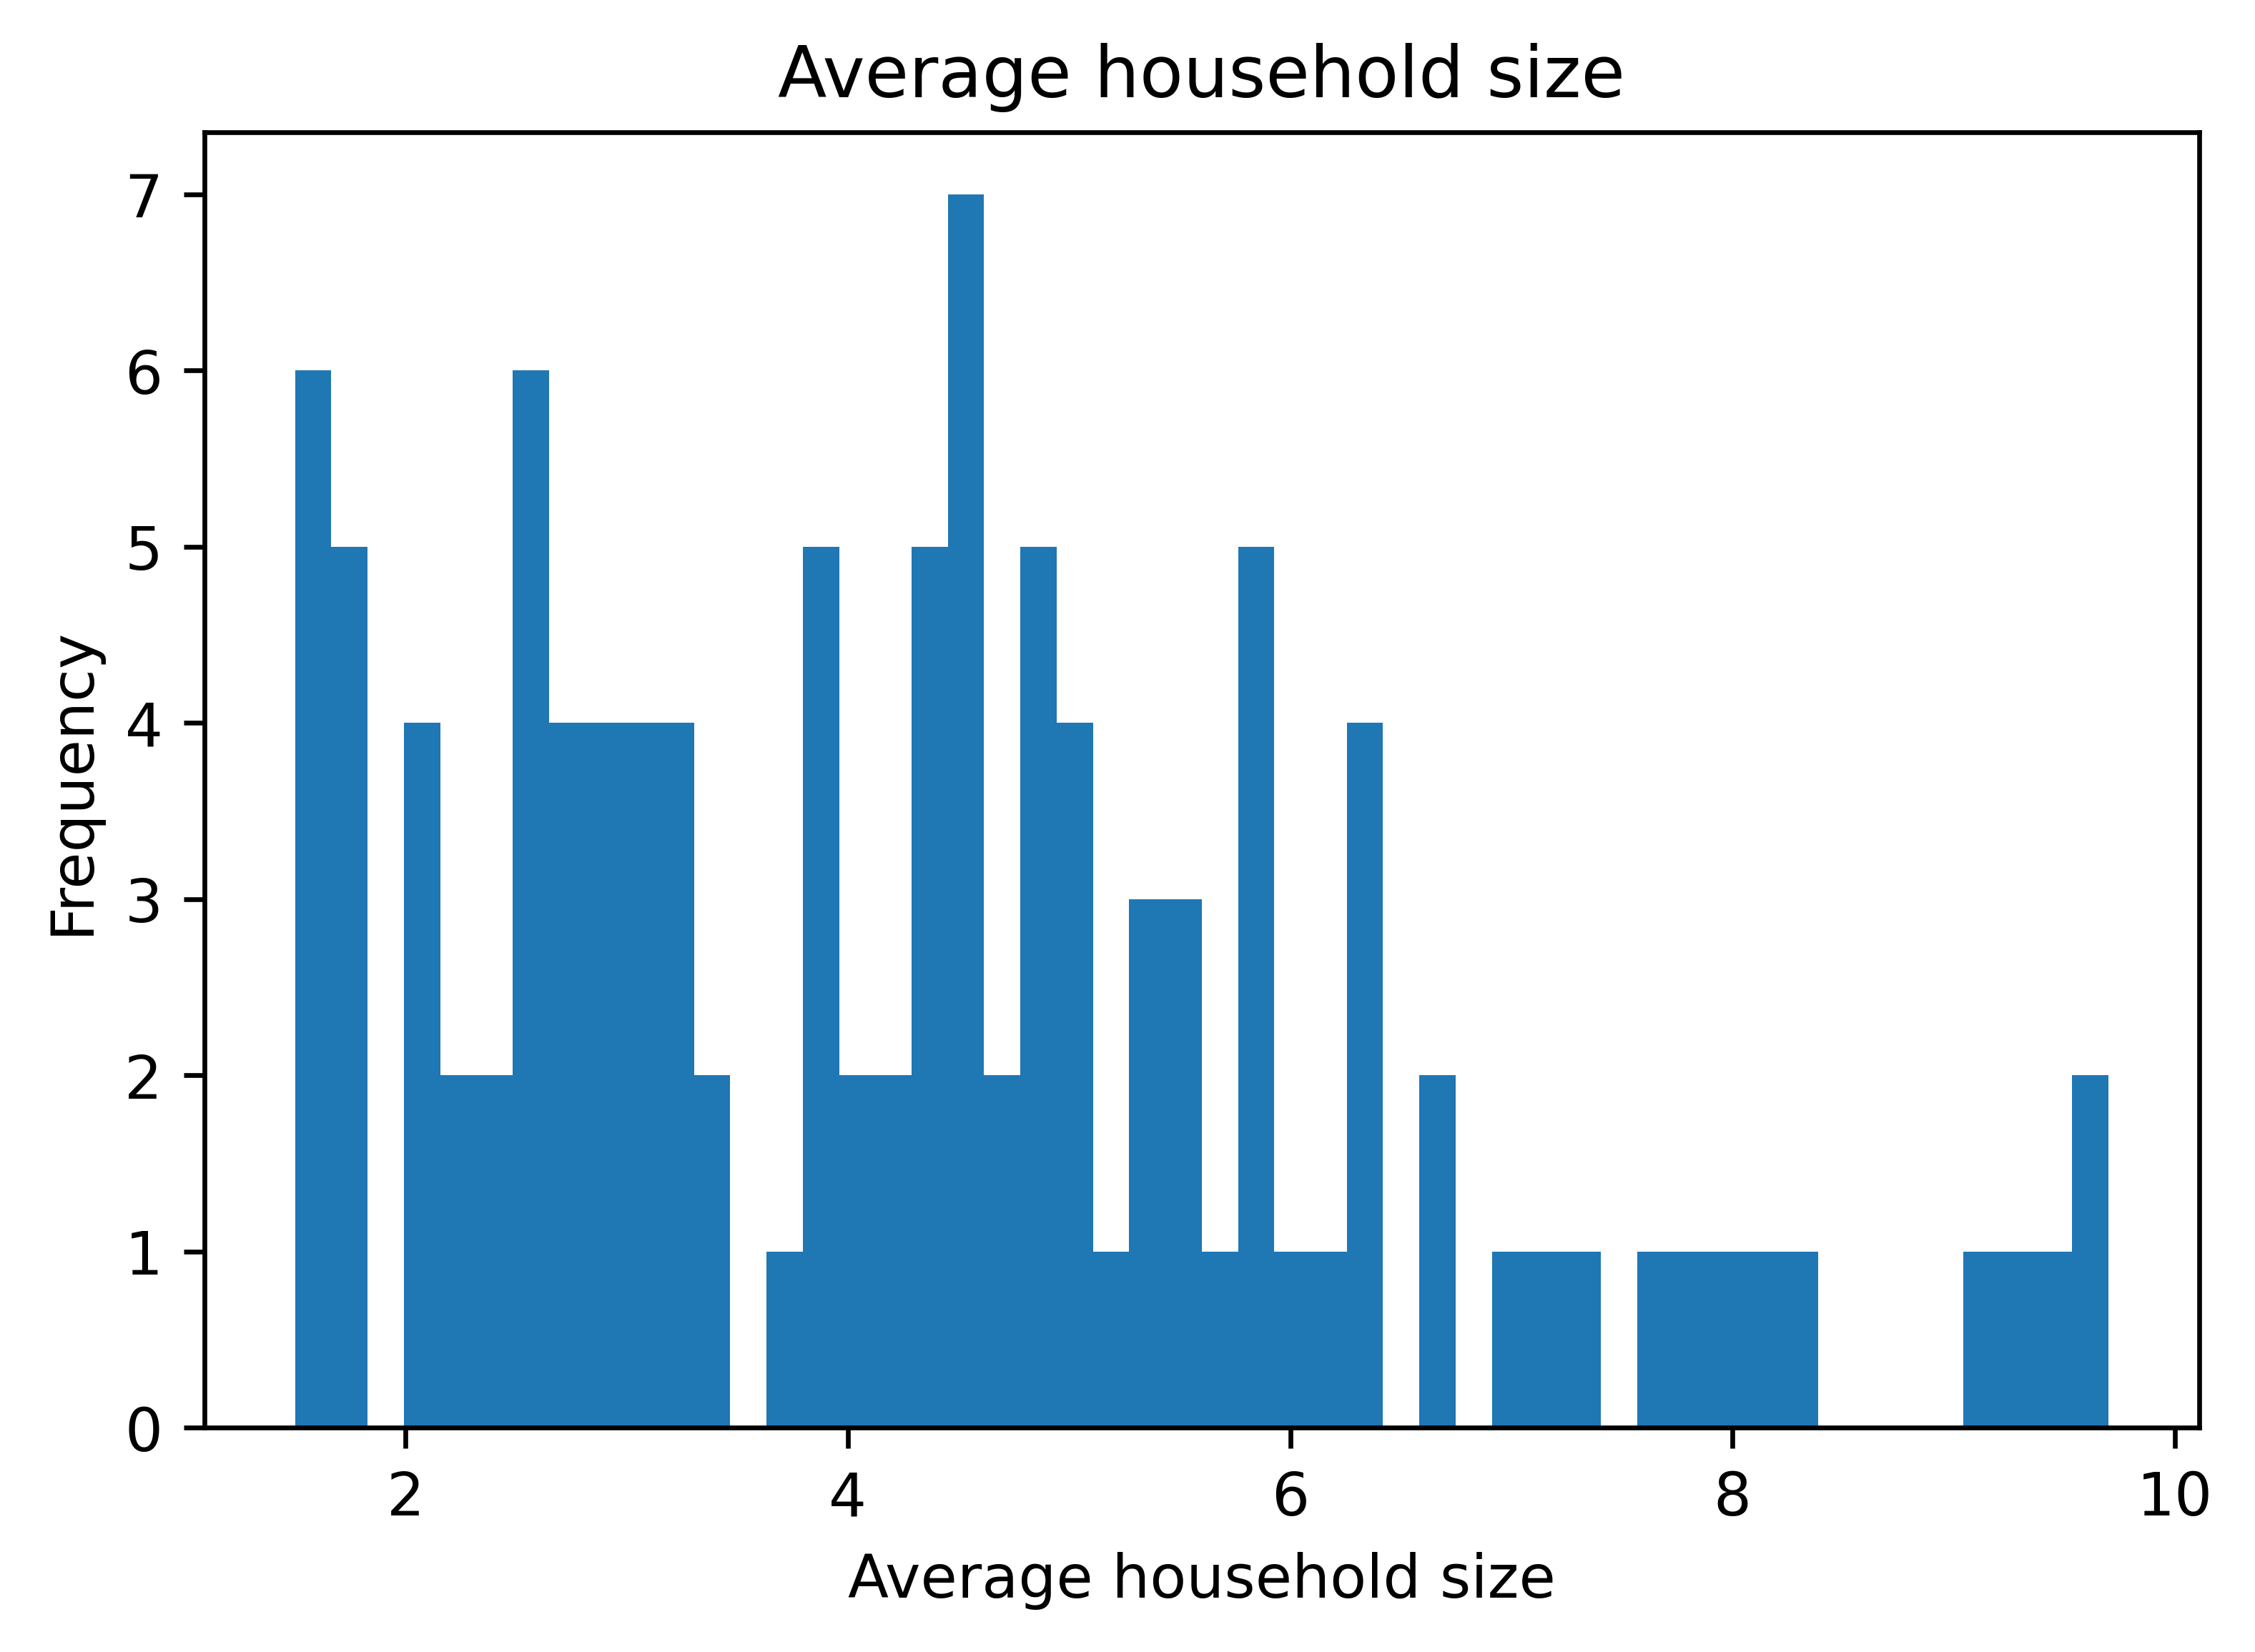

In [121]:
plt.xlabel('Average household size')
plt.title('Average household size')
df_household['avg household size'].plot(kind='hist', bins = 50)

---
### Average number of cars in appartments and houses

In [122]:
df_household.loc[:,'avg number of cars'] = (df_household['avg number of cars apts'] + df_household['avg number of cars apts'])/2.0

c:\users\hamdanjuma\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\hamdanjuma\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<AxesSubplot:ylabel='Frequency'>

Text(0.5, 0, 'Average Number of Cars')

Text(0.5, 1.0, 'Average Number of Cars')

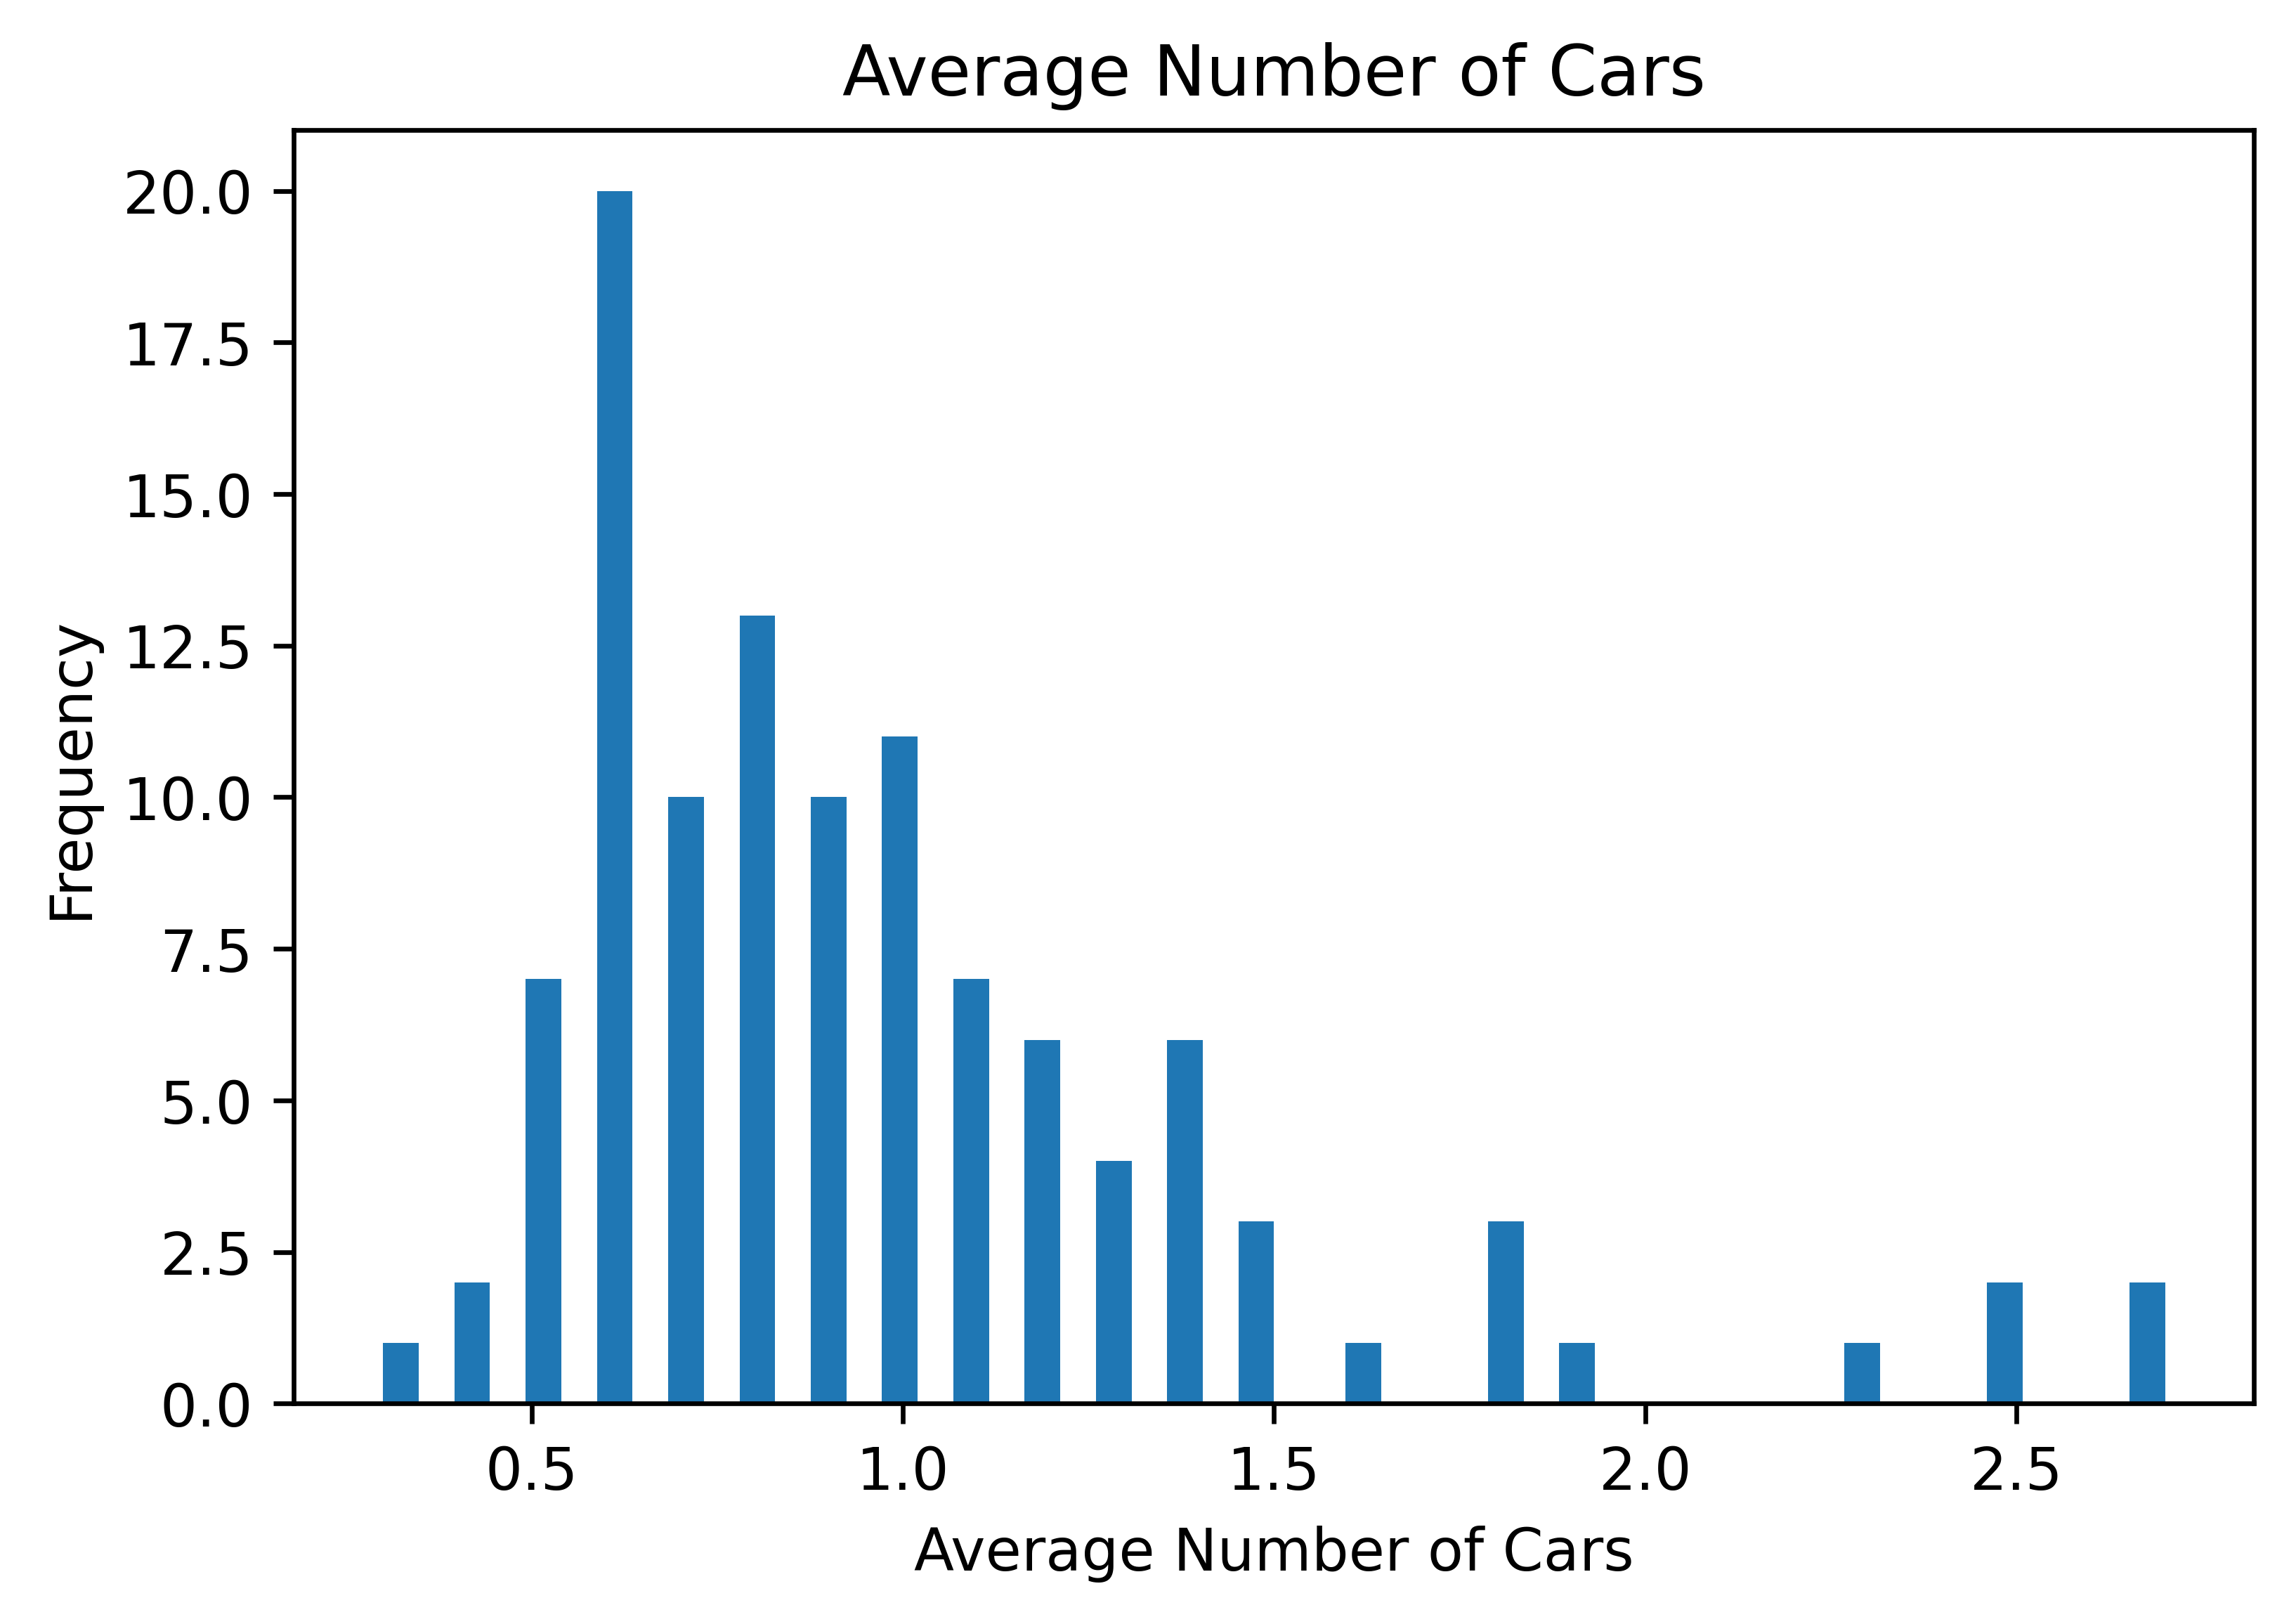

In [123]:
df_household['avg number of cars'].plot(kind='hist', bins = 50)
plt.xlabel('Average Number of Cars')
plt.title('Average Number of Cars')

<AxesSubplot:ylabel='Frequency'>

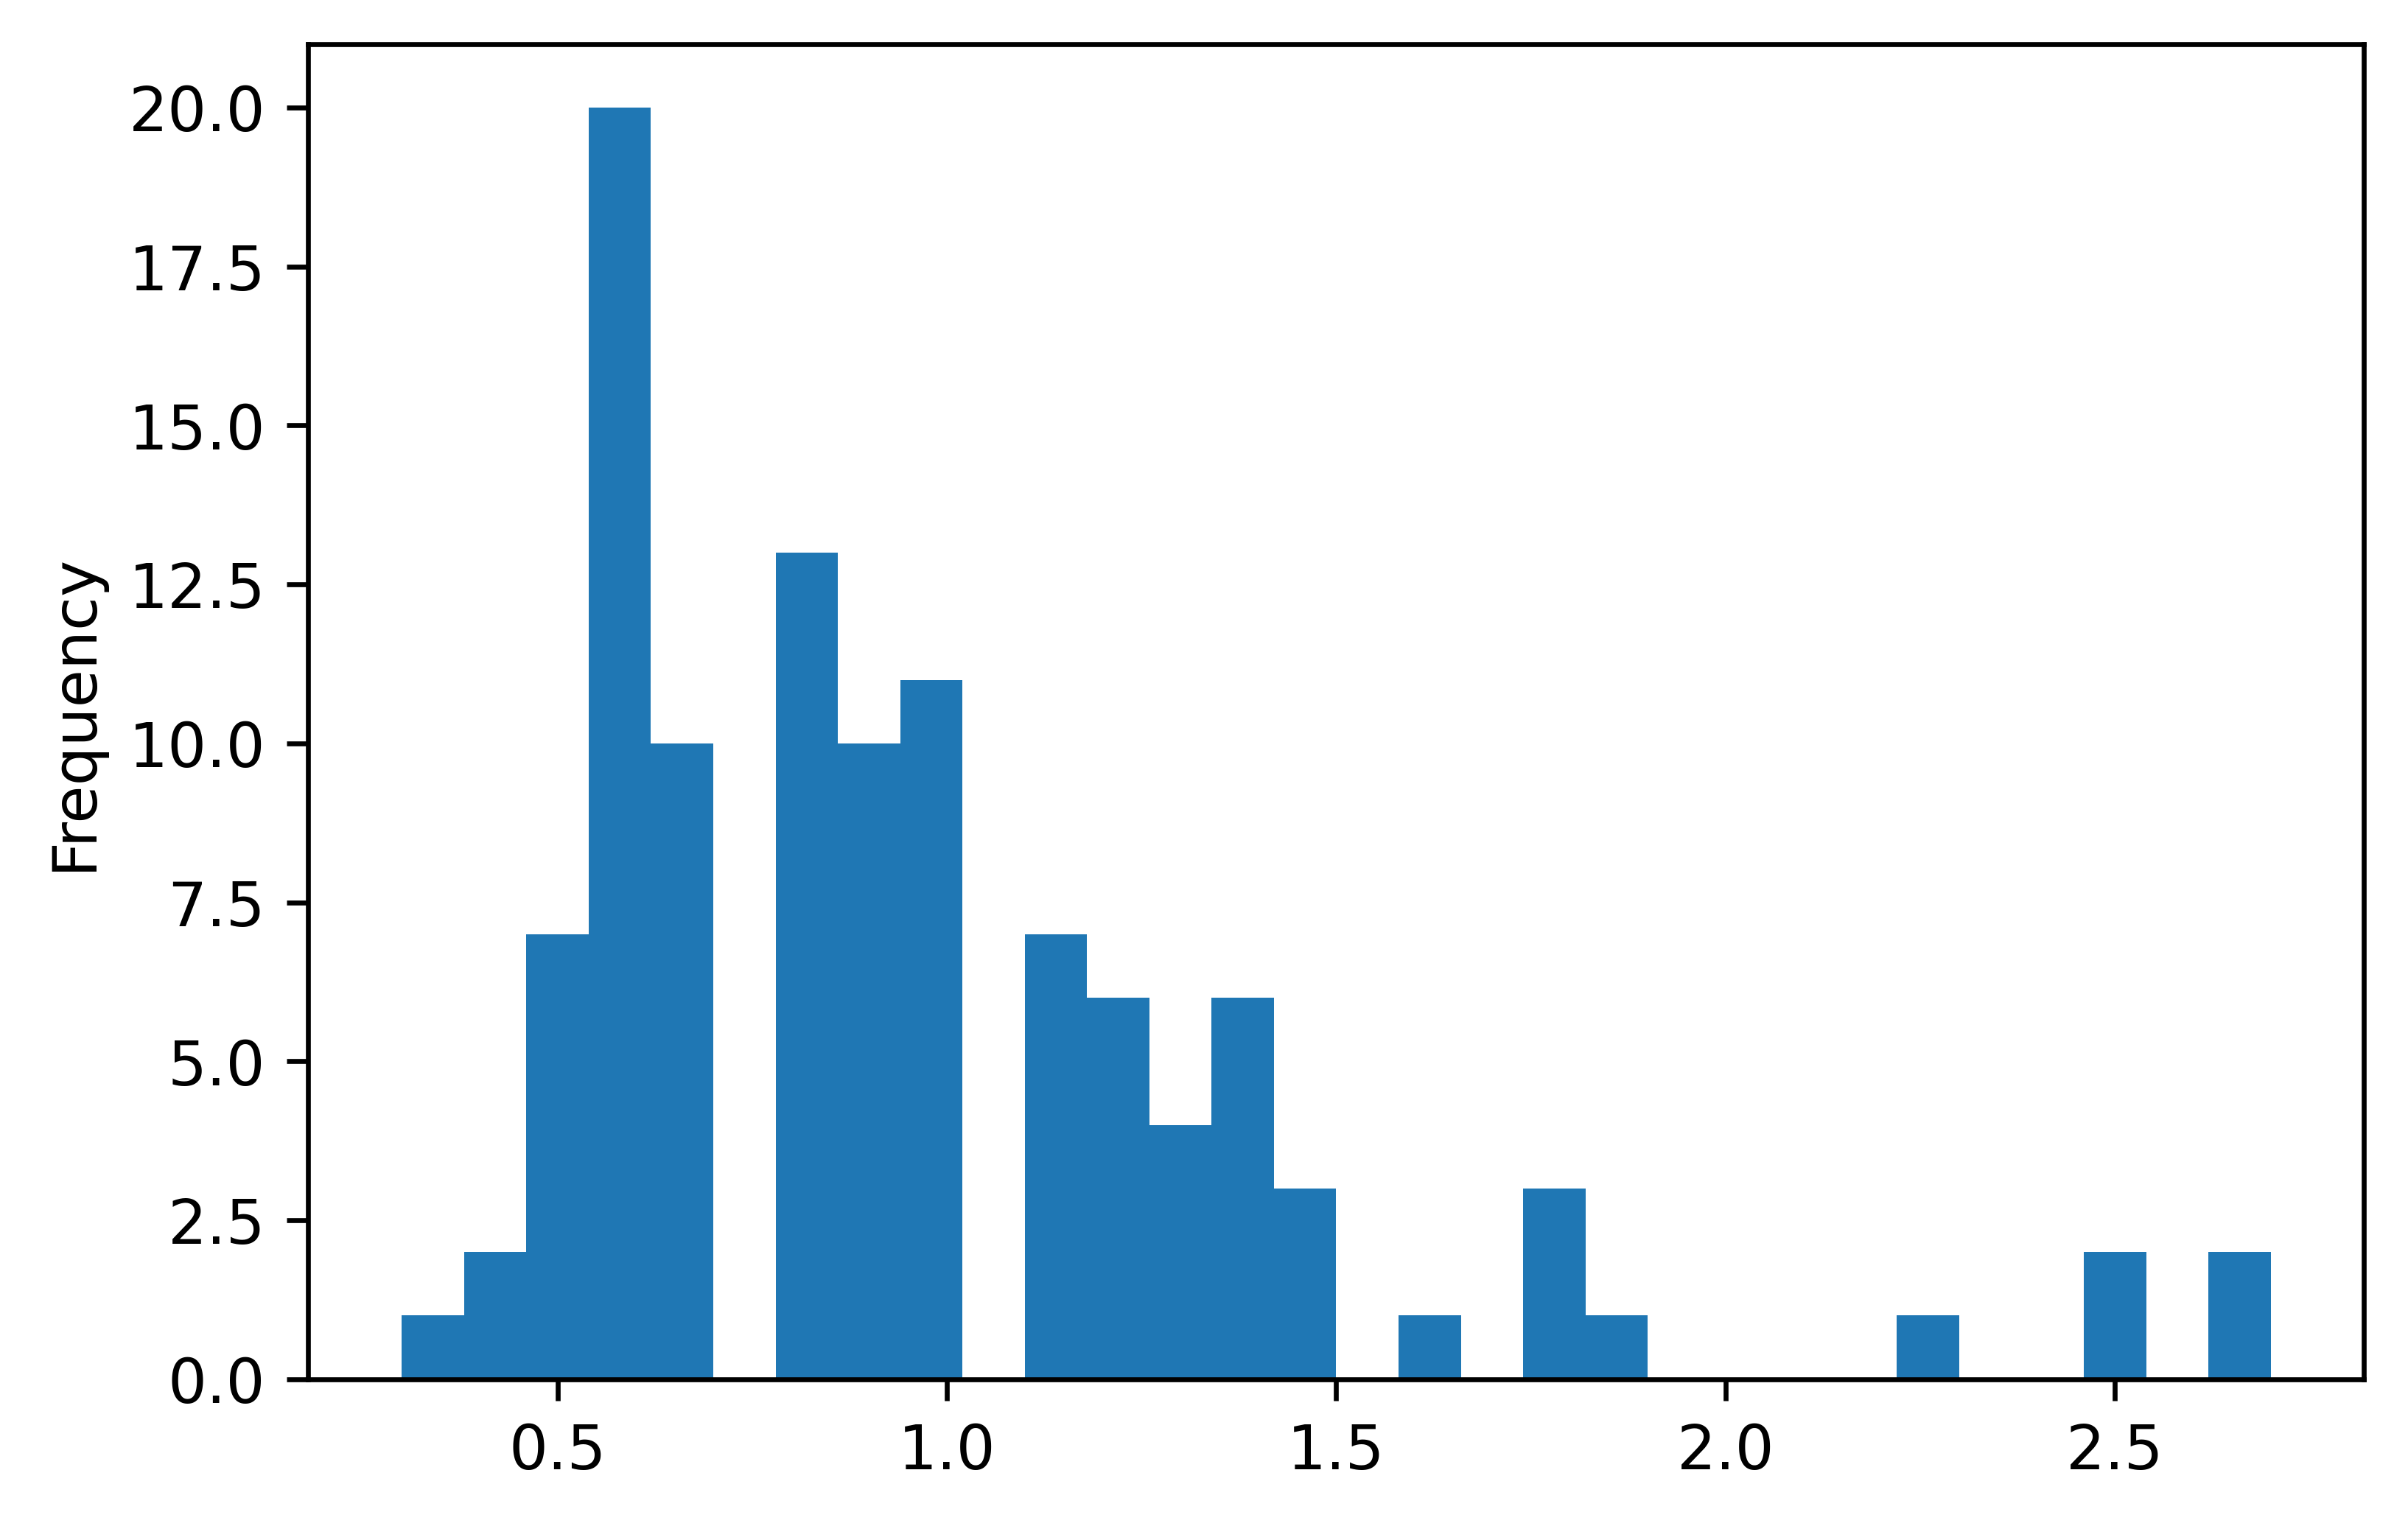

In [124]:
df_cars = df_household[df_household['avg number of cars'] < 5]
df_cars['avg number of cars'].plot(kind='hist', bins = 30)

---
### Medium Age

In [125]:
df_cars['med age'] = (df_cars['med age females'] + df_cars['med age males'])/2.0

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 0, 'Median Age')

Text(0.5, 1.0, 'Median Age')

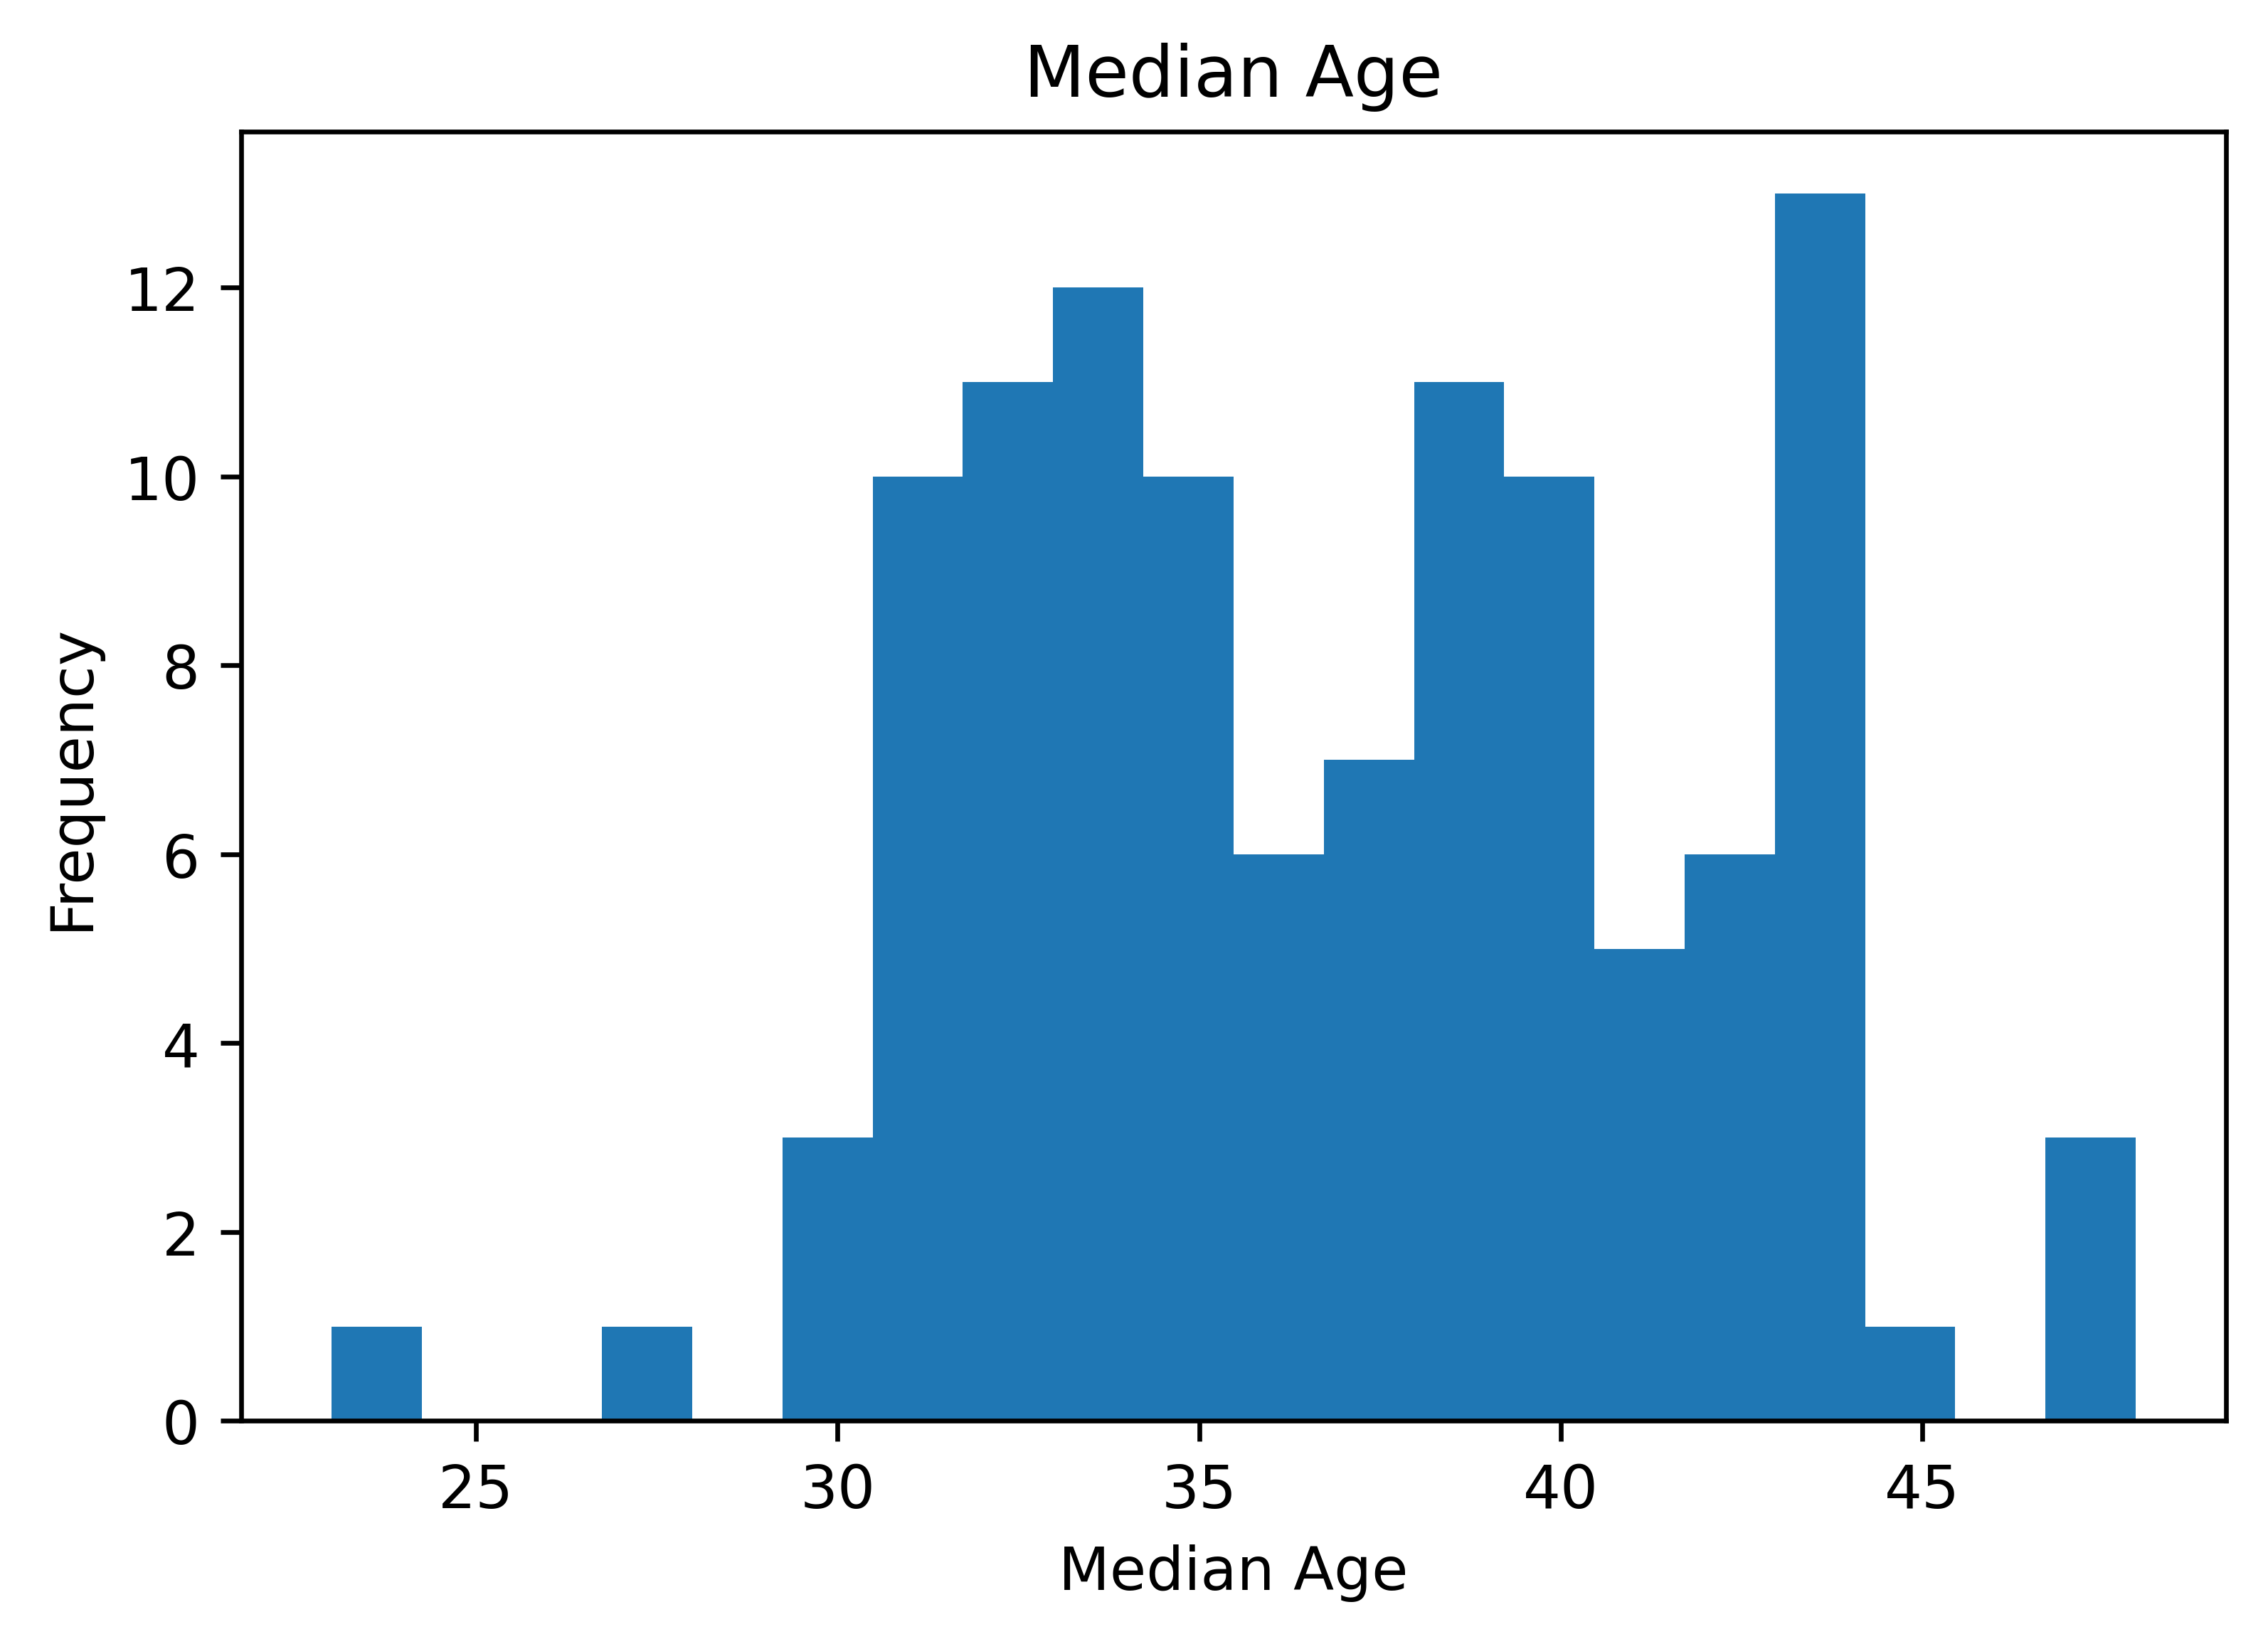

In [126]:
df_cars['med age'].plot(kind='hist', bins = 20)
plt.xlabel('Median Age')
plt.title('Median Age')

+ A few neighborhoods appear to have suspiciously young residents. Perhaps in some neighborhoods, the number of children is higher than the number of adults?

---
### Median Household income and rent

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 0, 'Income')

Text(0.5, 1.0, 'Median Household Income')

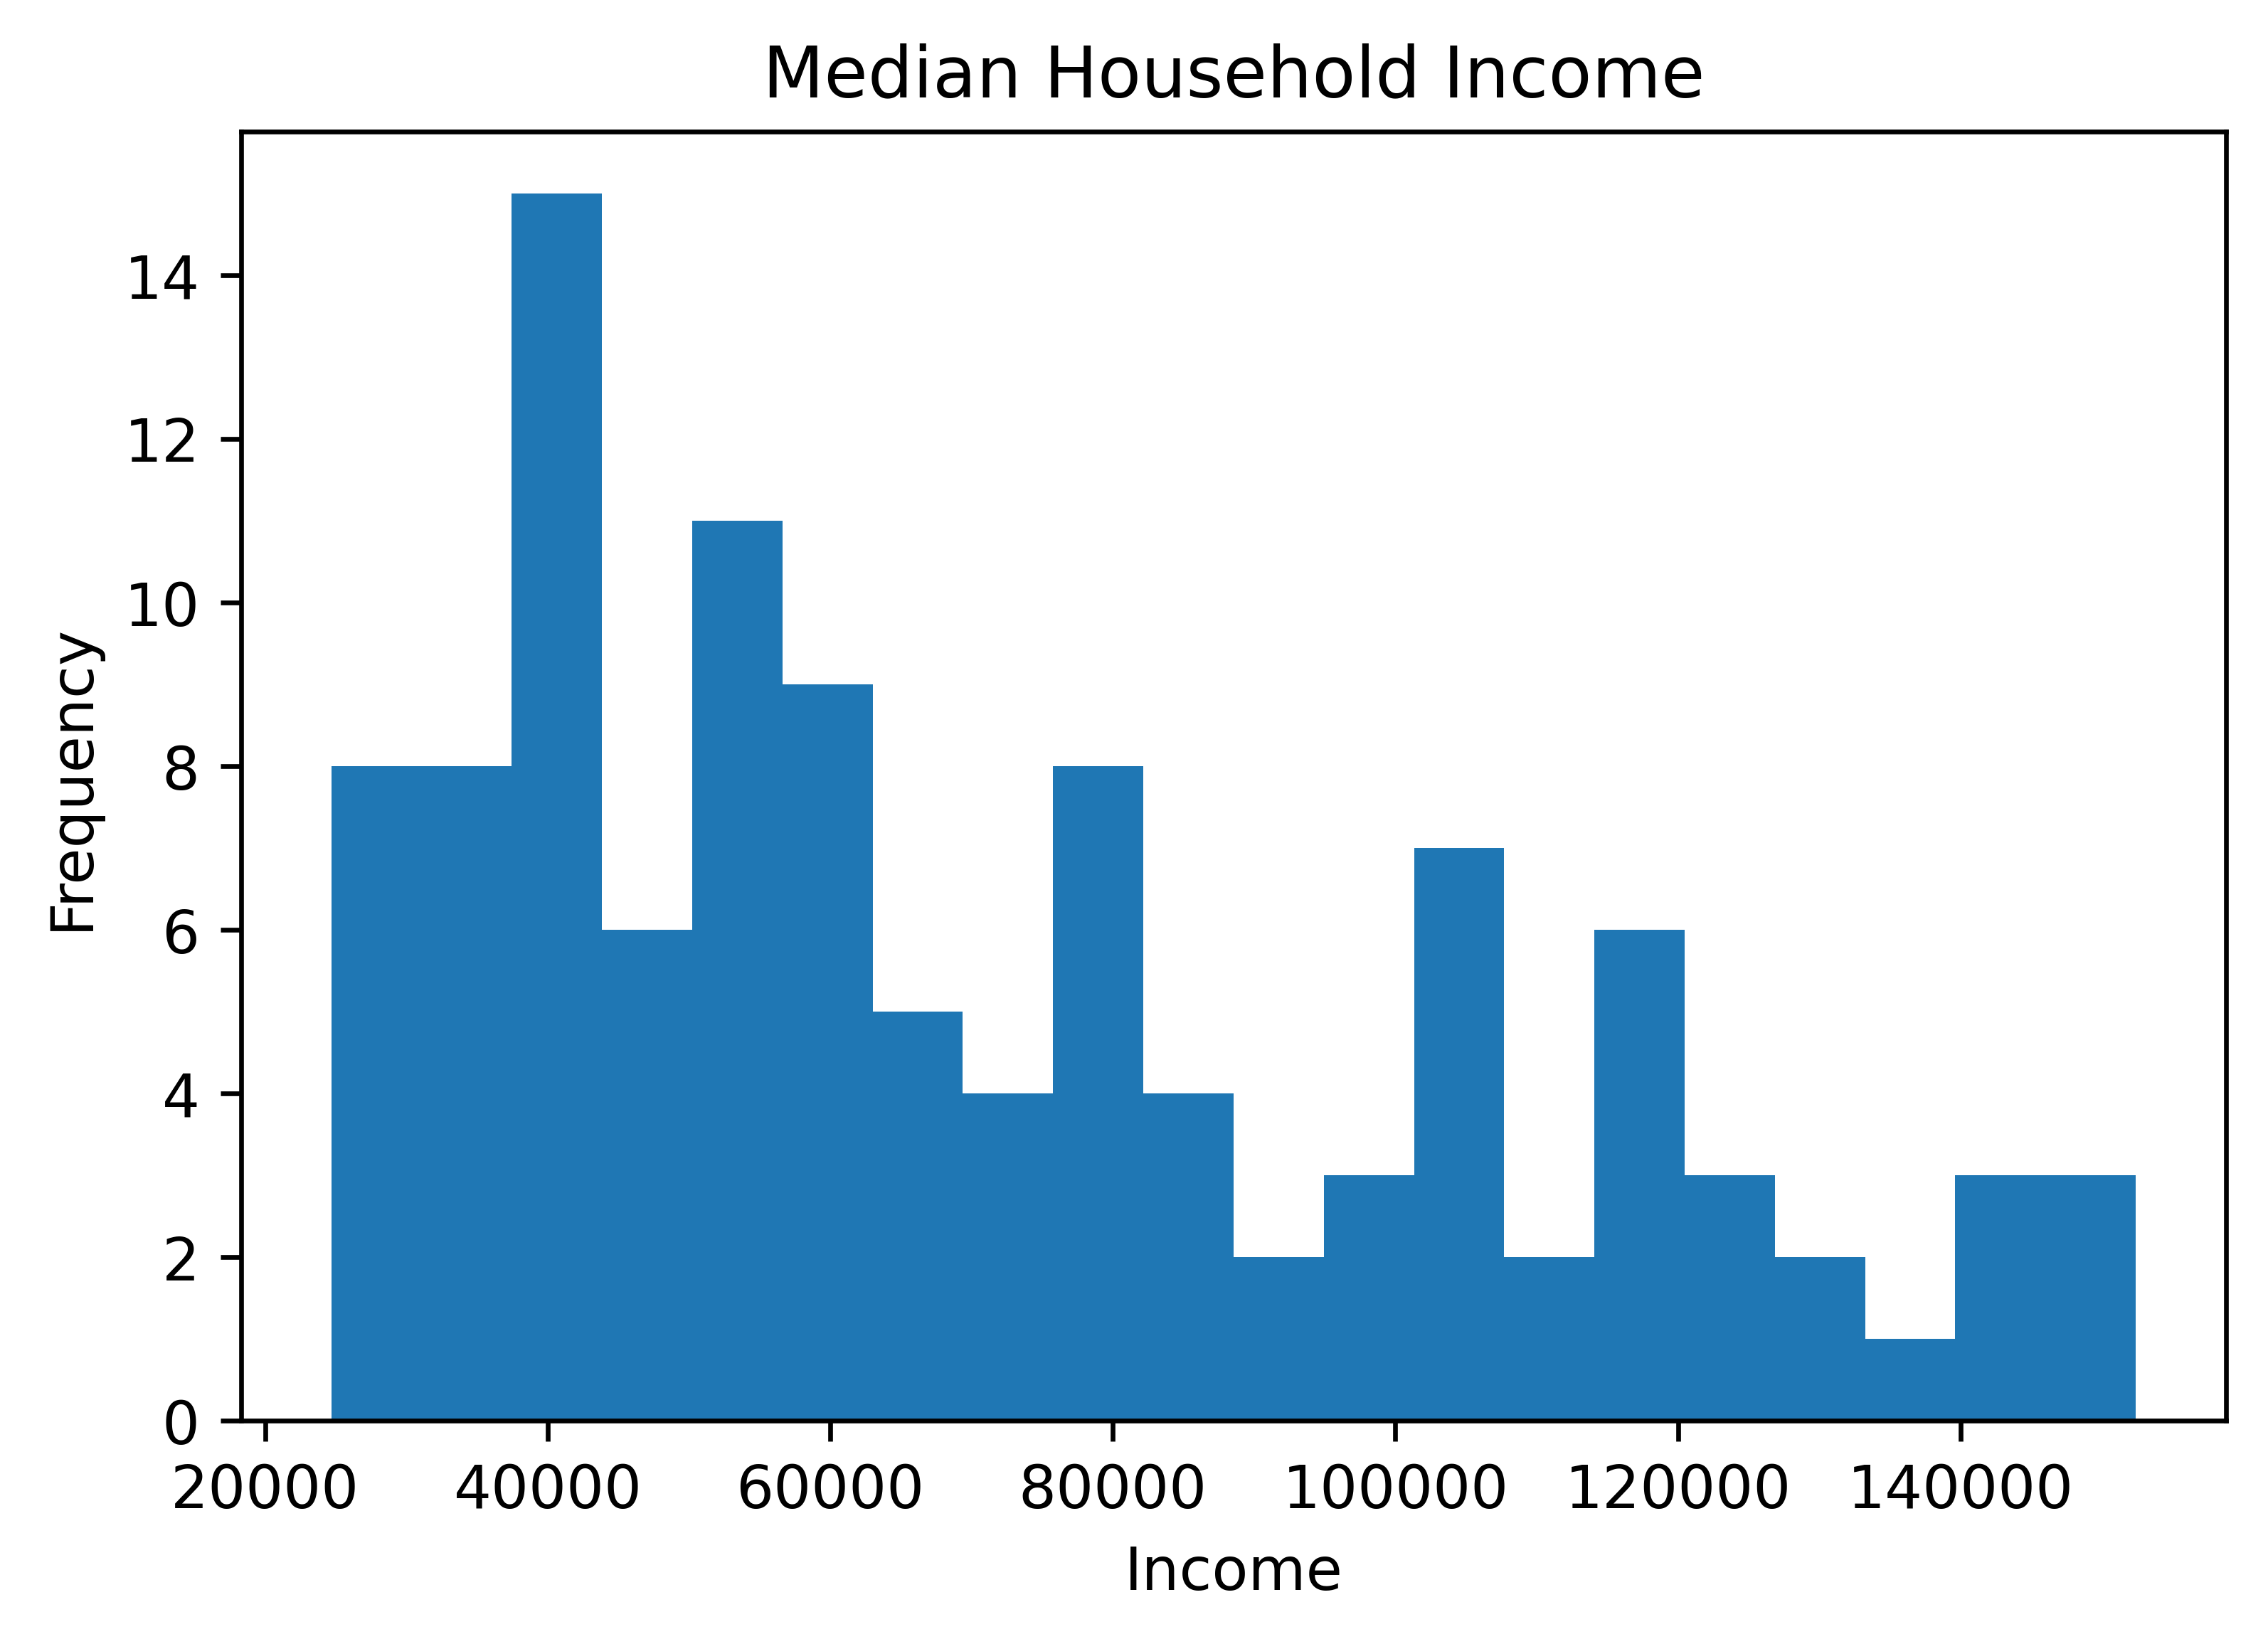

In [127]:
df_cars['med household income'].plot(kind='hist', bins = 20)
plt.xlabel('Income')
plt.title('Median Household Income')

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 0, 'Rent')

Text(0.5, 1.0, 'Median Rent')

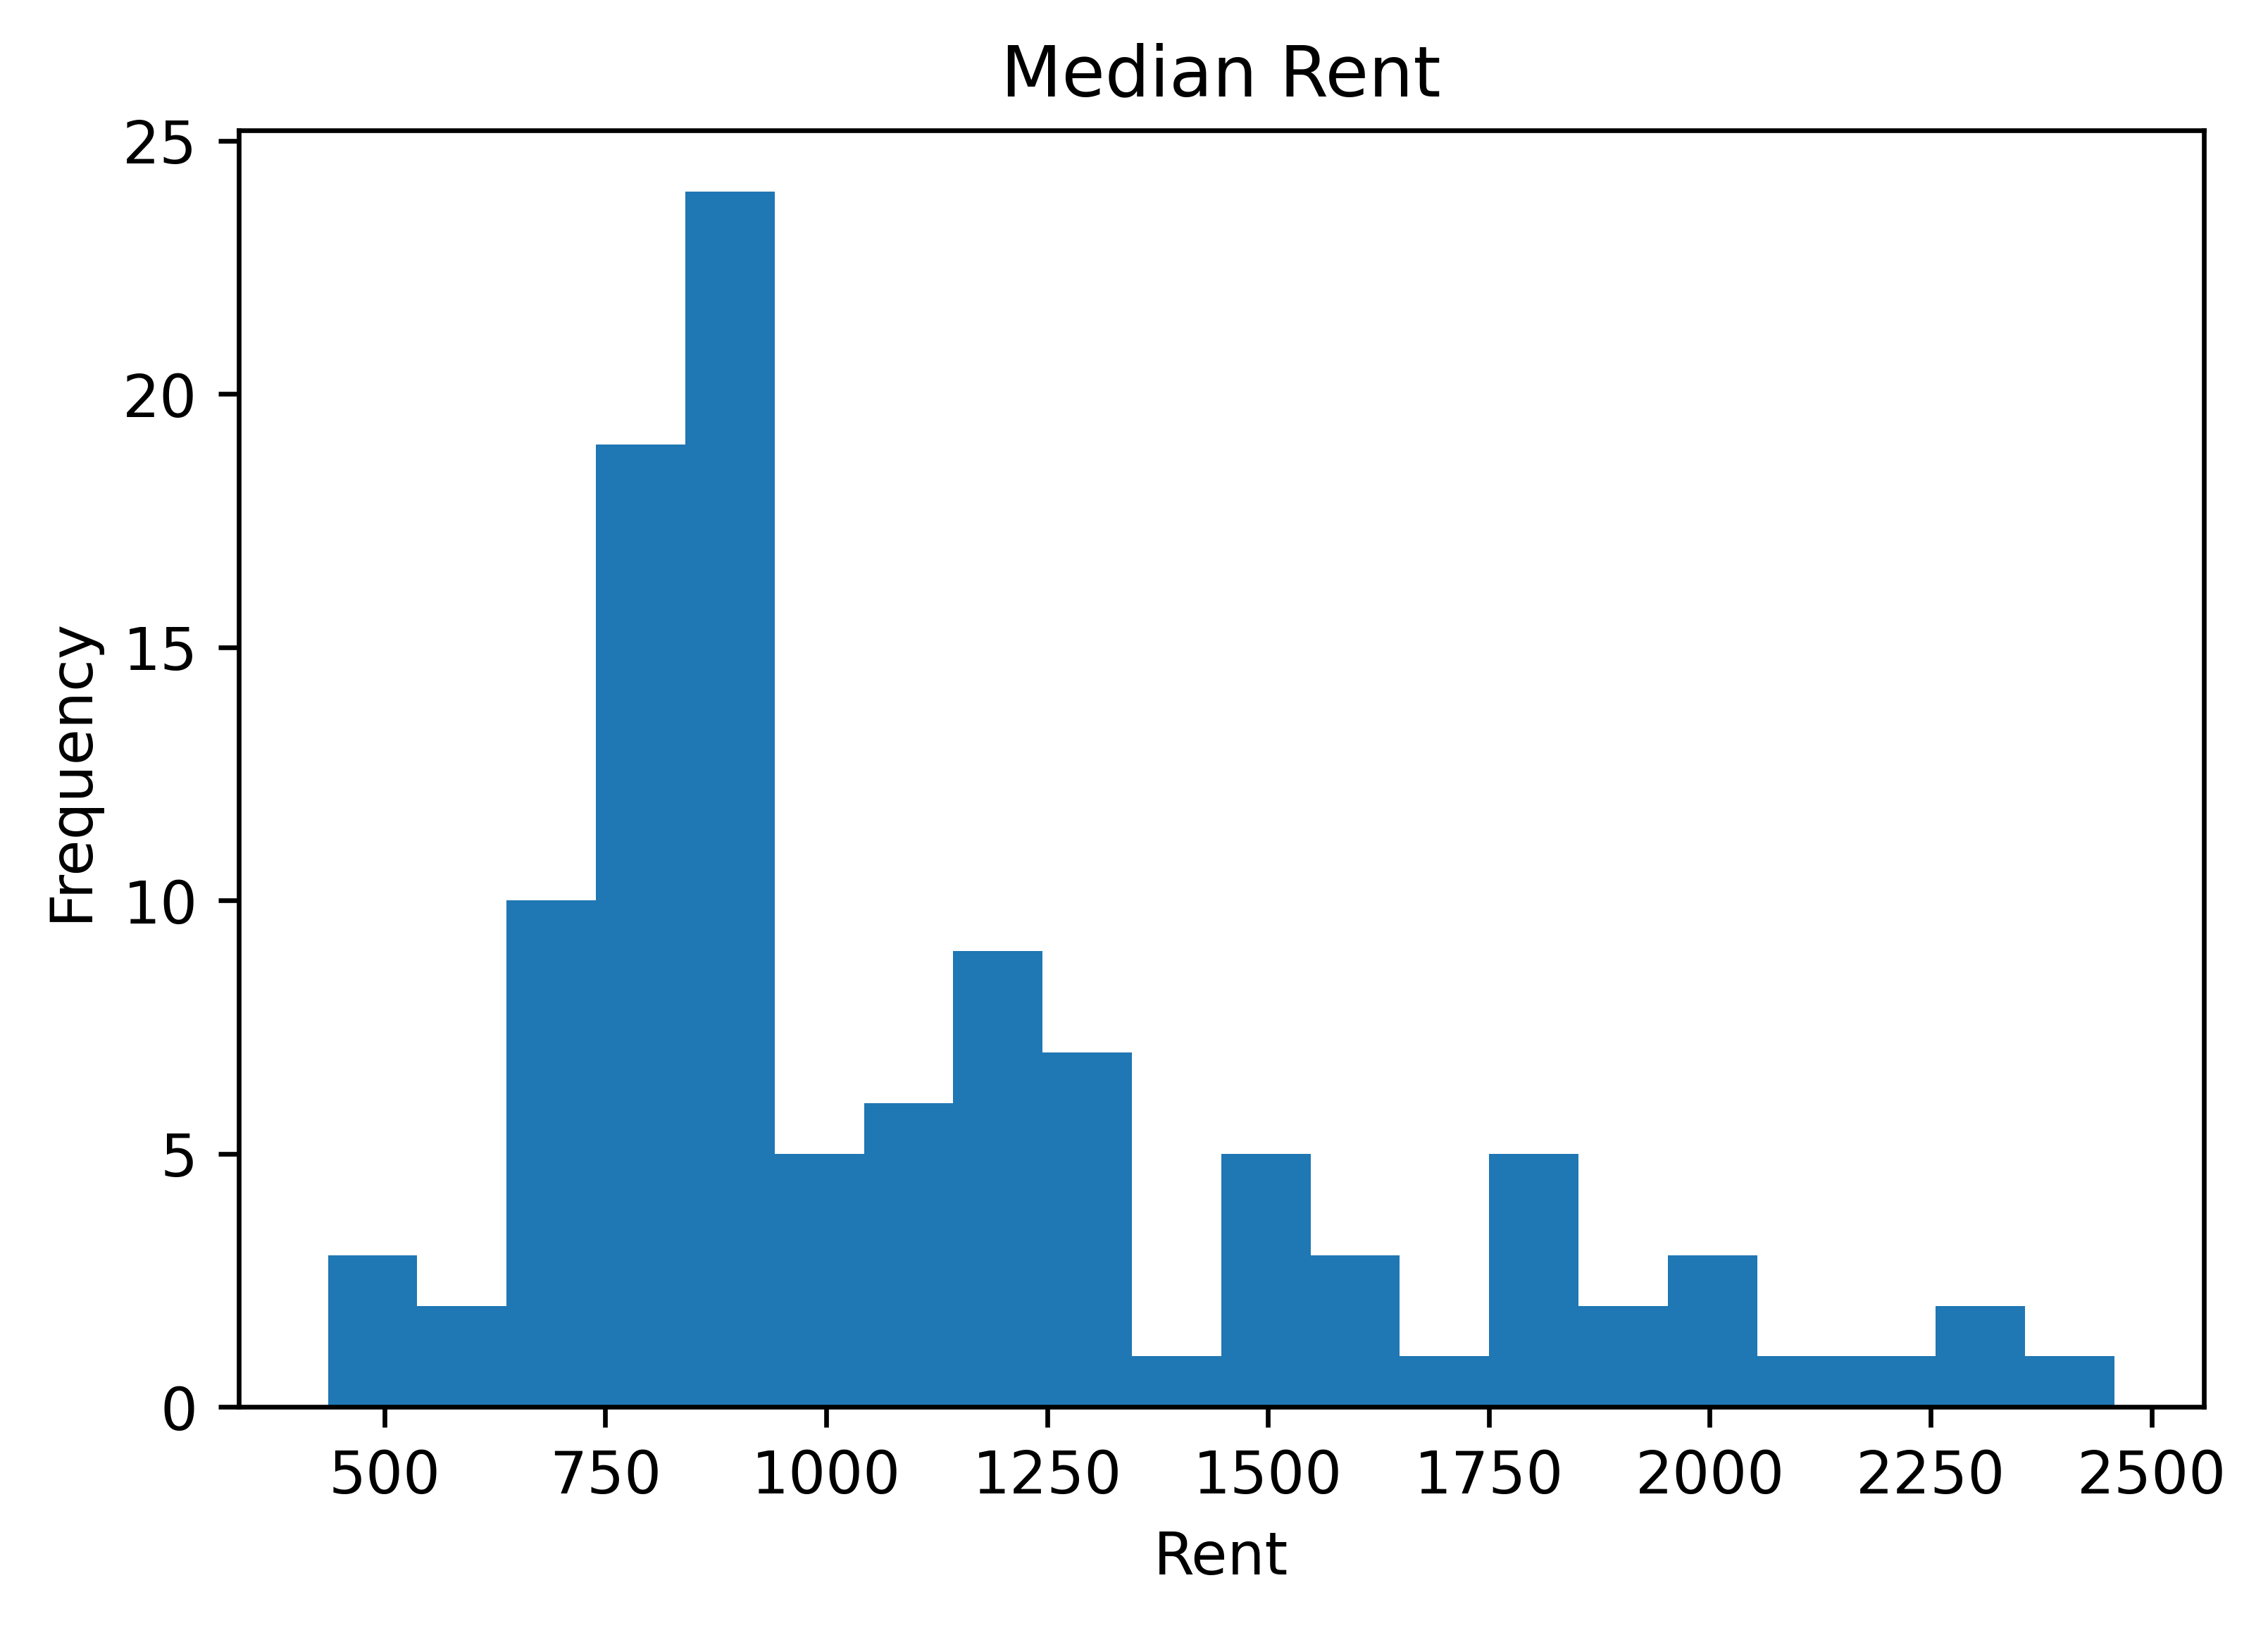

In [128]:
df_cars['med rent'].plot(kind='hist', bins = 20)
plt.xlabel('Rent')
plt.title('Median Rent')

---
### Families with children, family household, married couples

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 0, 'percent')

Text(0.5, 1.0, 'Percent families with children')

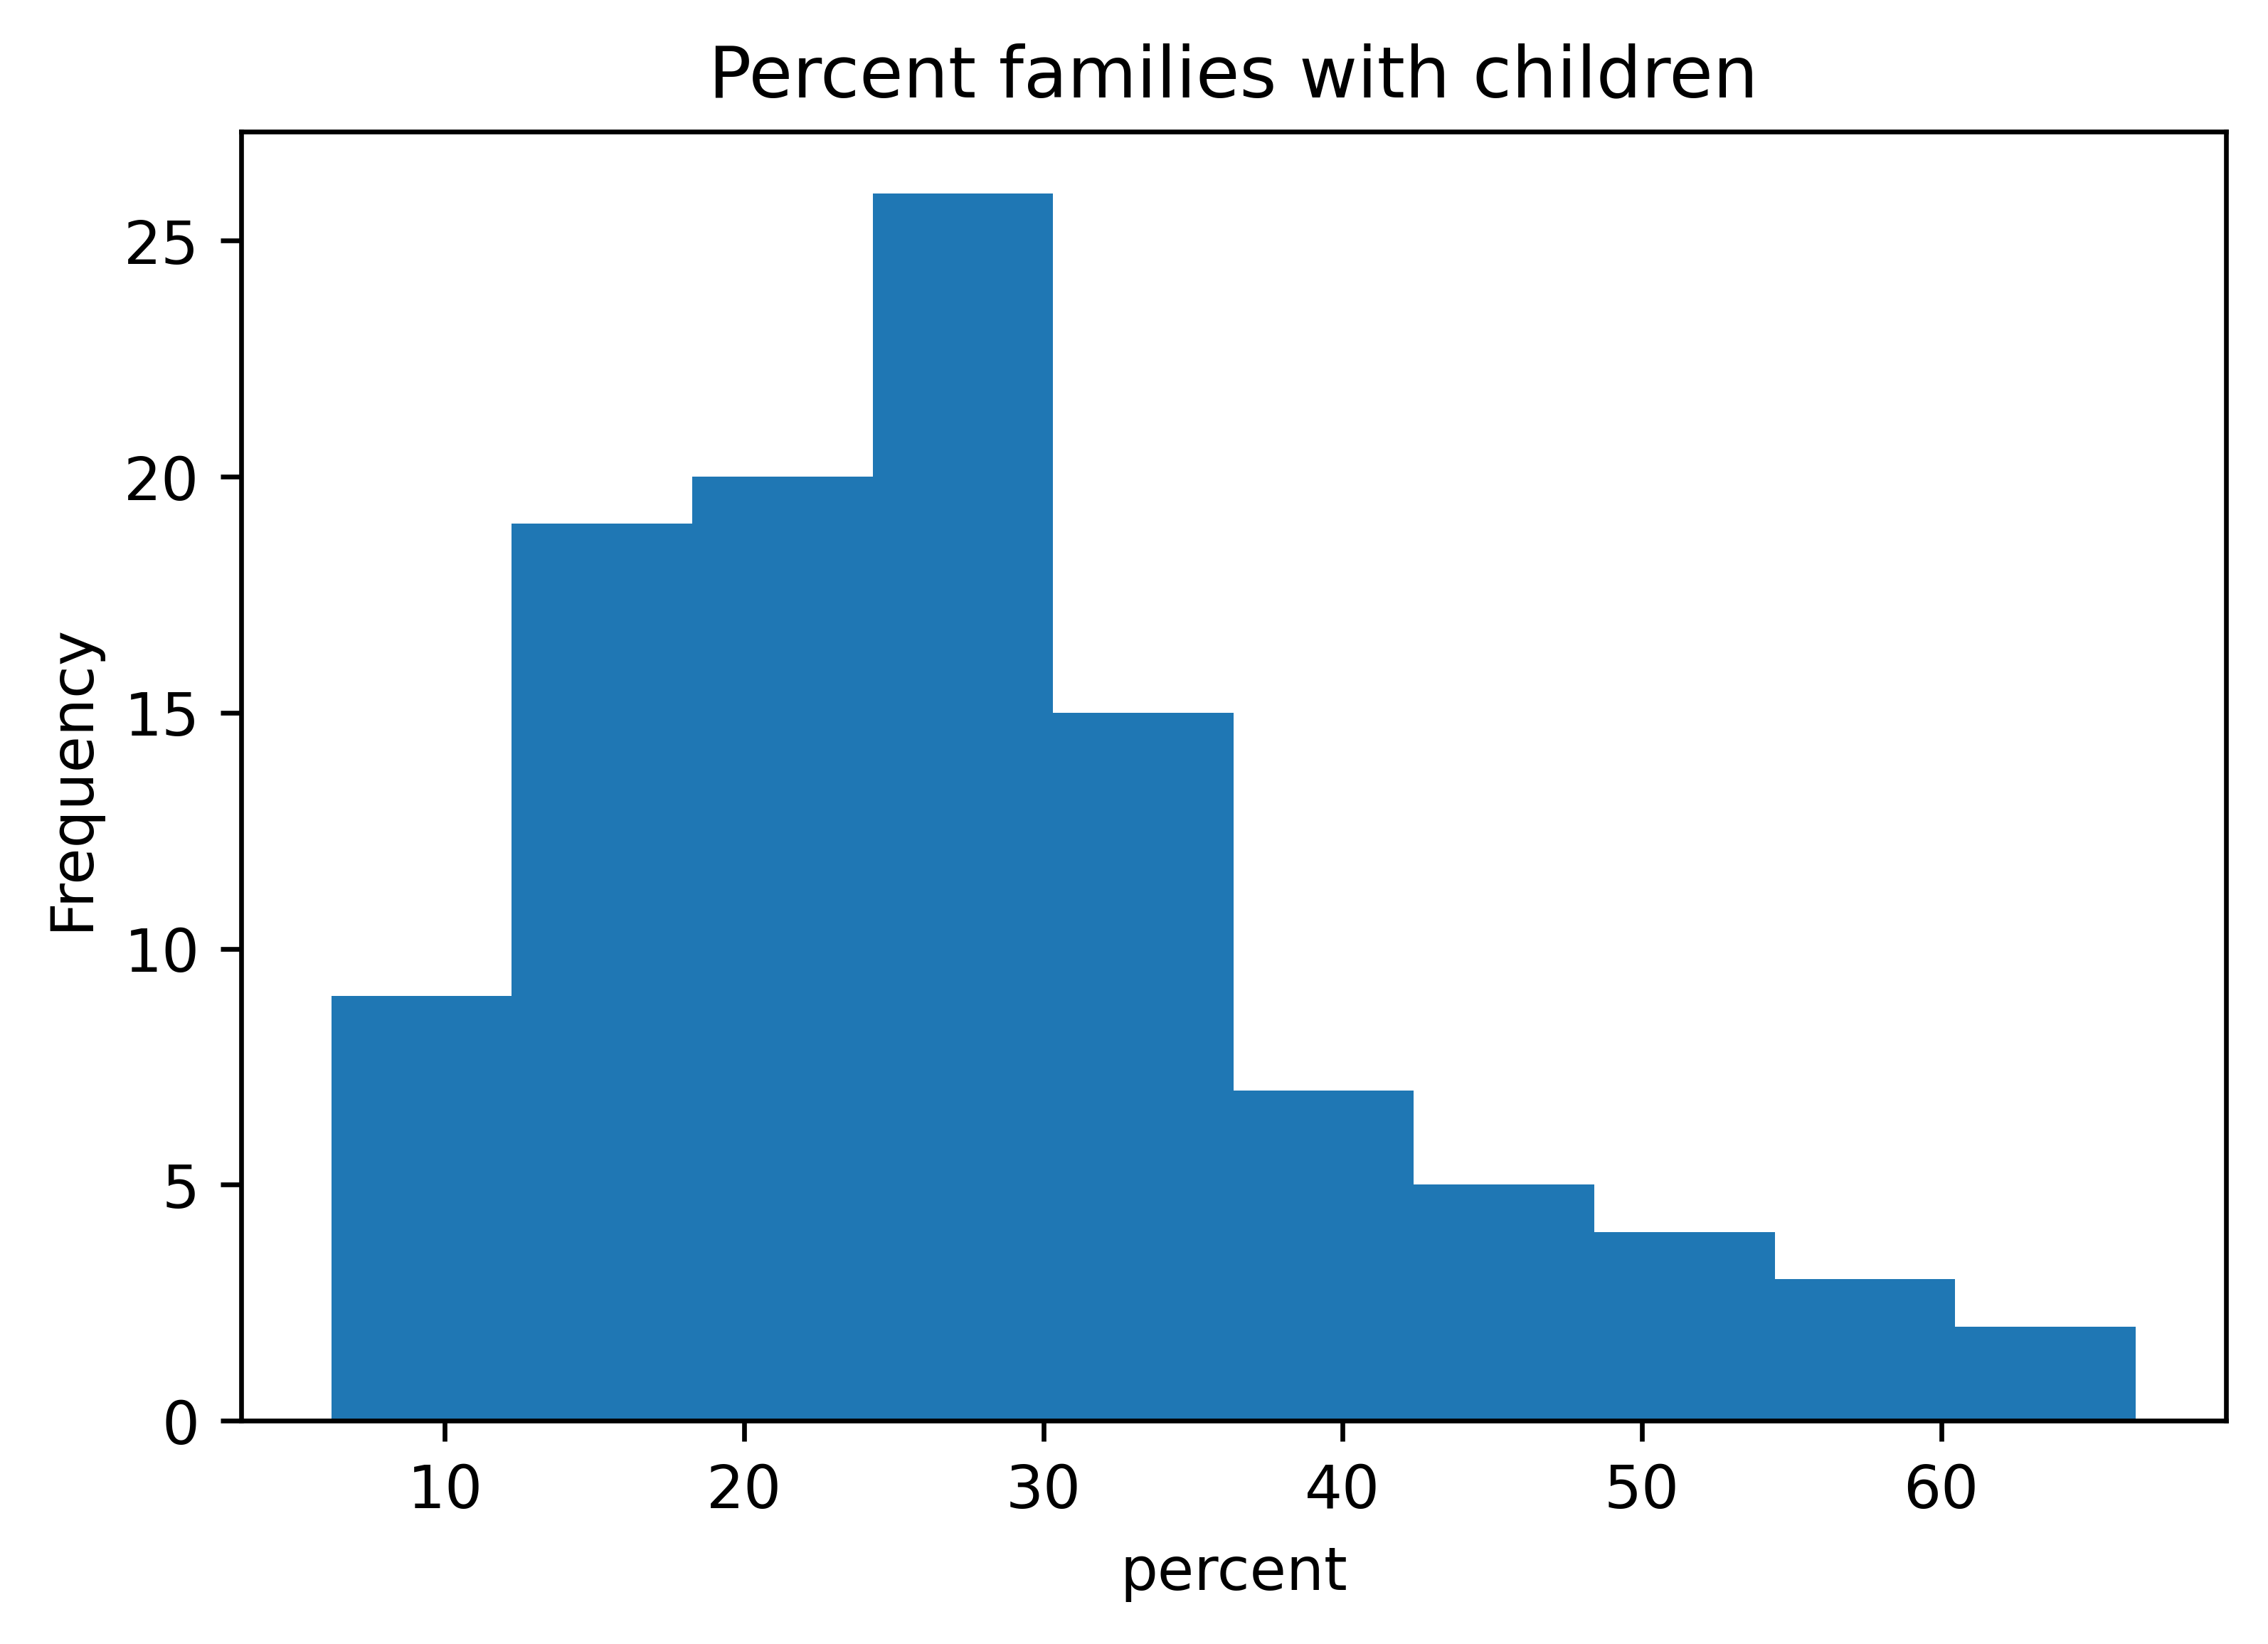

In [129]:
df_cars['pct families with children'].plot(kind='hist', bins = 10)
plt.xlabel('percent')
plt.title('Percent families with children')

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 0, 'percent')

Text(0.5, 1.0, 'Percent family household')

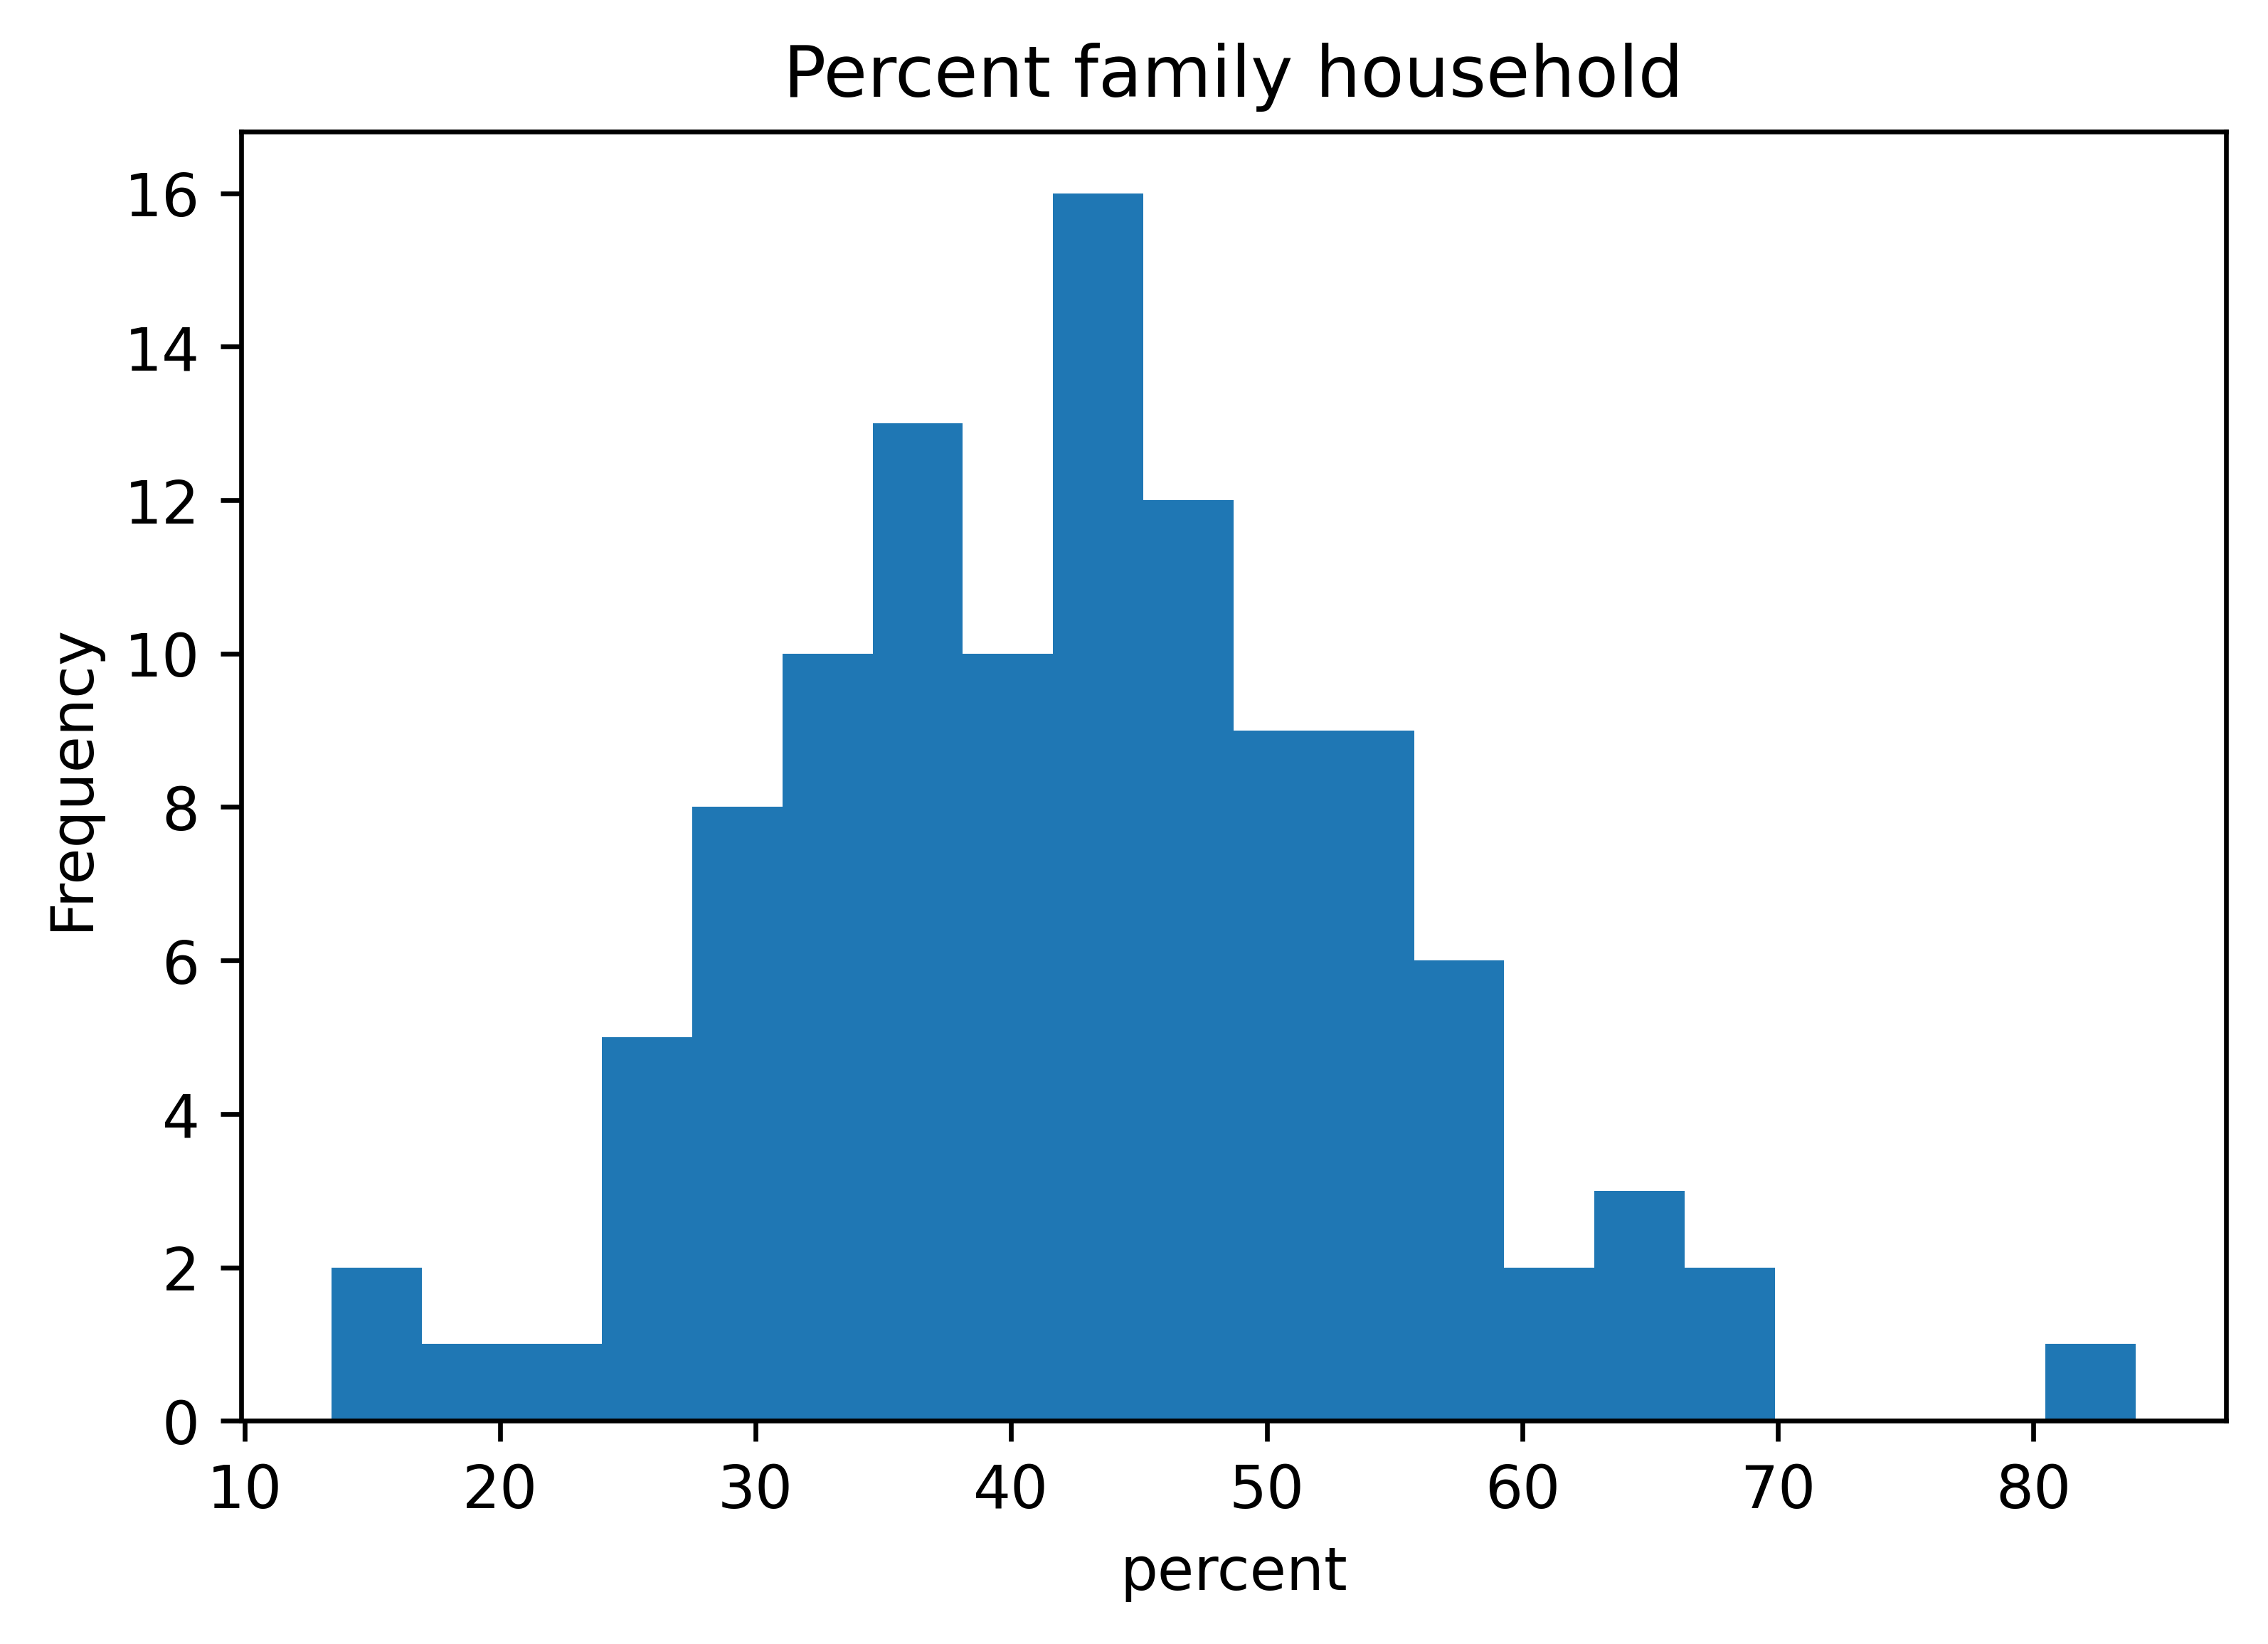

In [130]:
df_cars['pct family household'].plot(kind='hist', bins = 20)
plt.xlabel('percent')
plt.title('Percent family household')

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 0, 'percent')

Text(0.5, 1.0, 'Percent married couple')

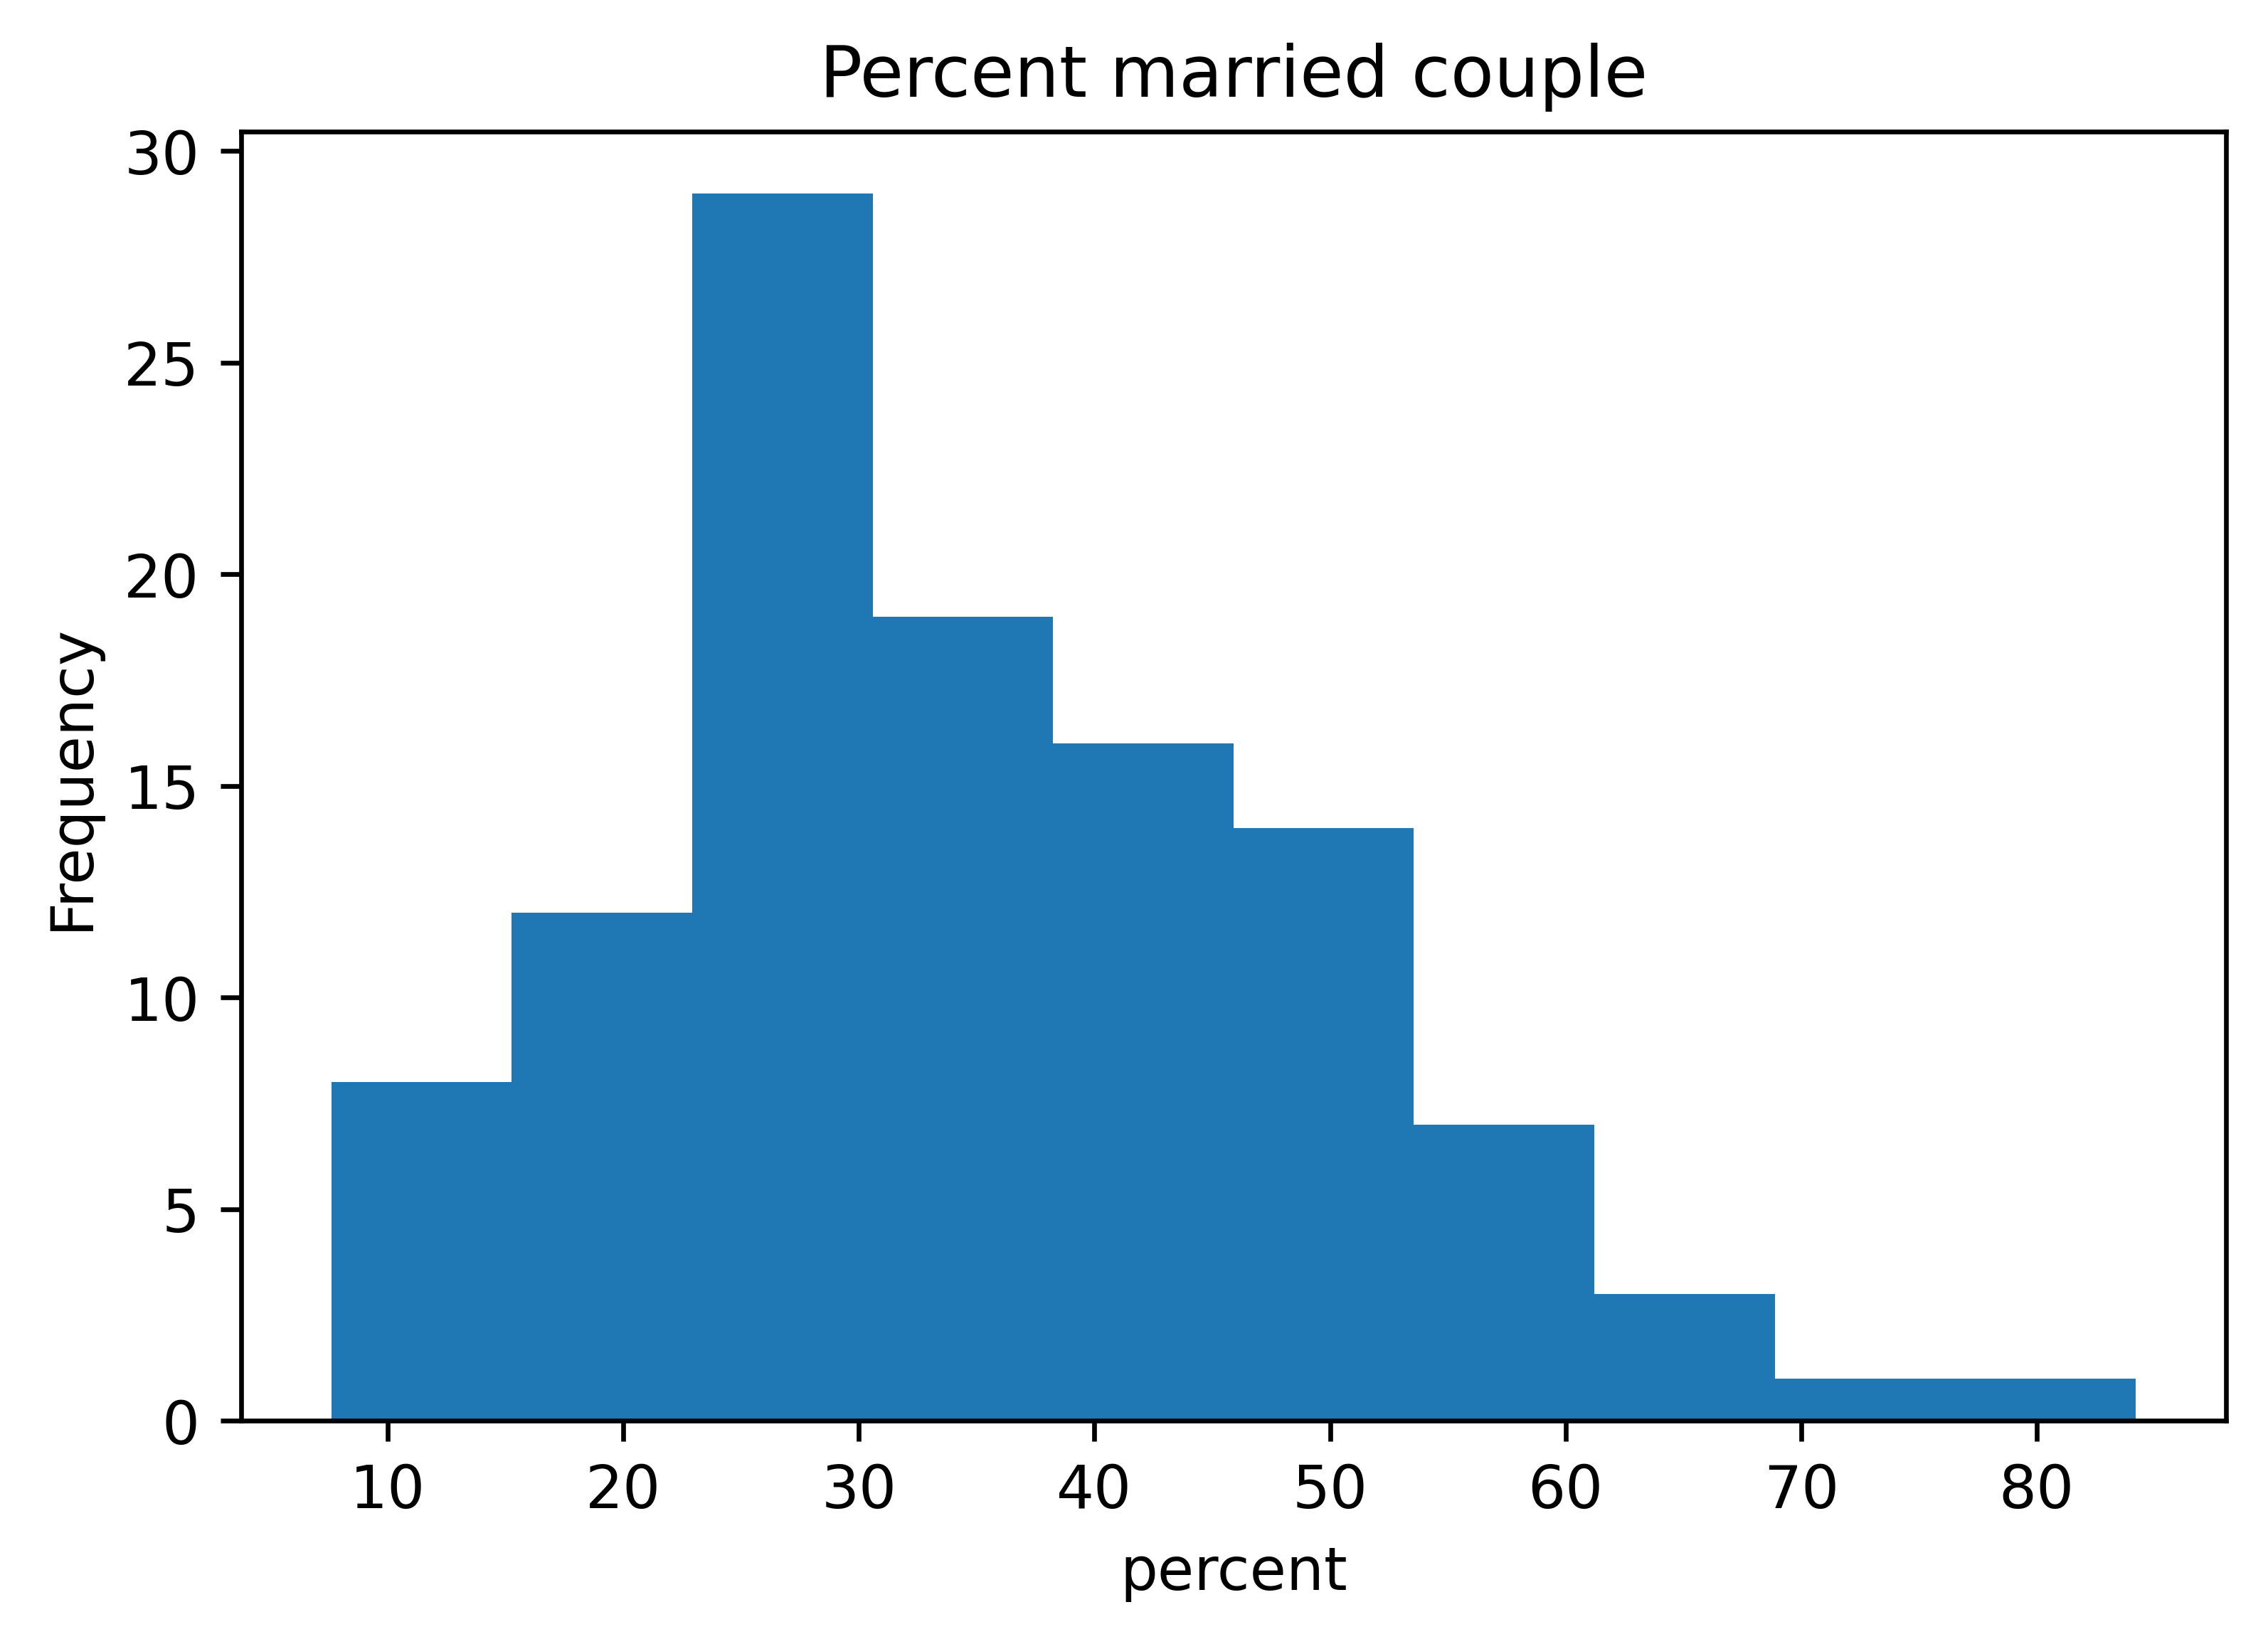

In [131]:
df_cars['pct married couple'].plot(kind='hist', bins = 10)
plt.xlabel('percent')
plt.title('Percent married couple')

+ Percents should not exceed 100

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 0, 'percent')

Text(0.5, 1.0, 'Percent never married females older than 15')

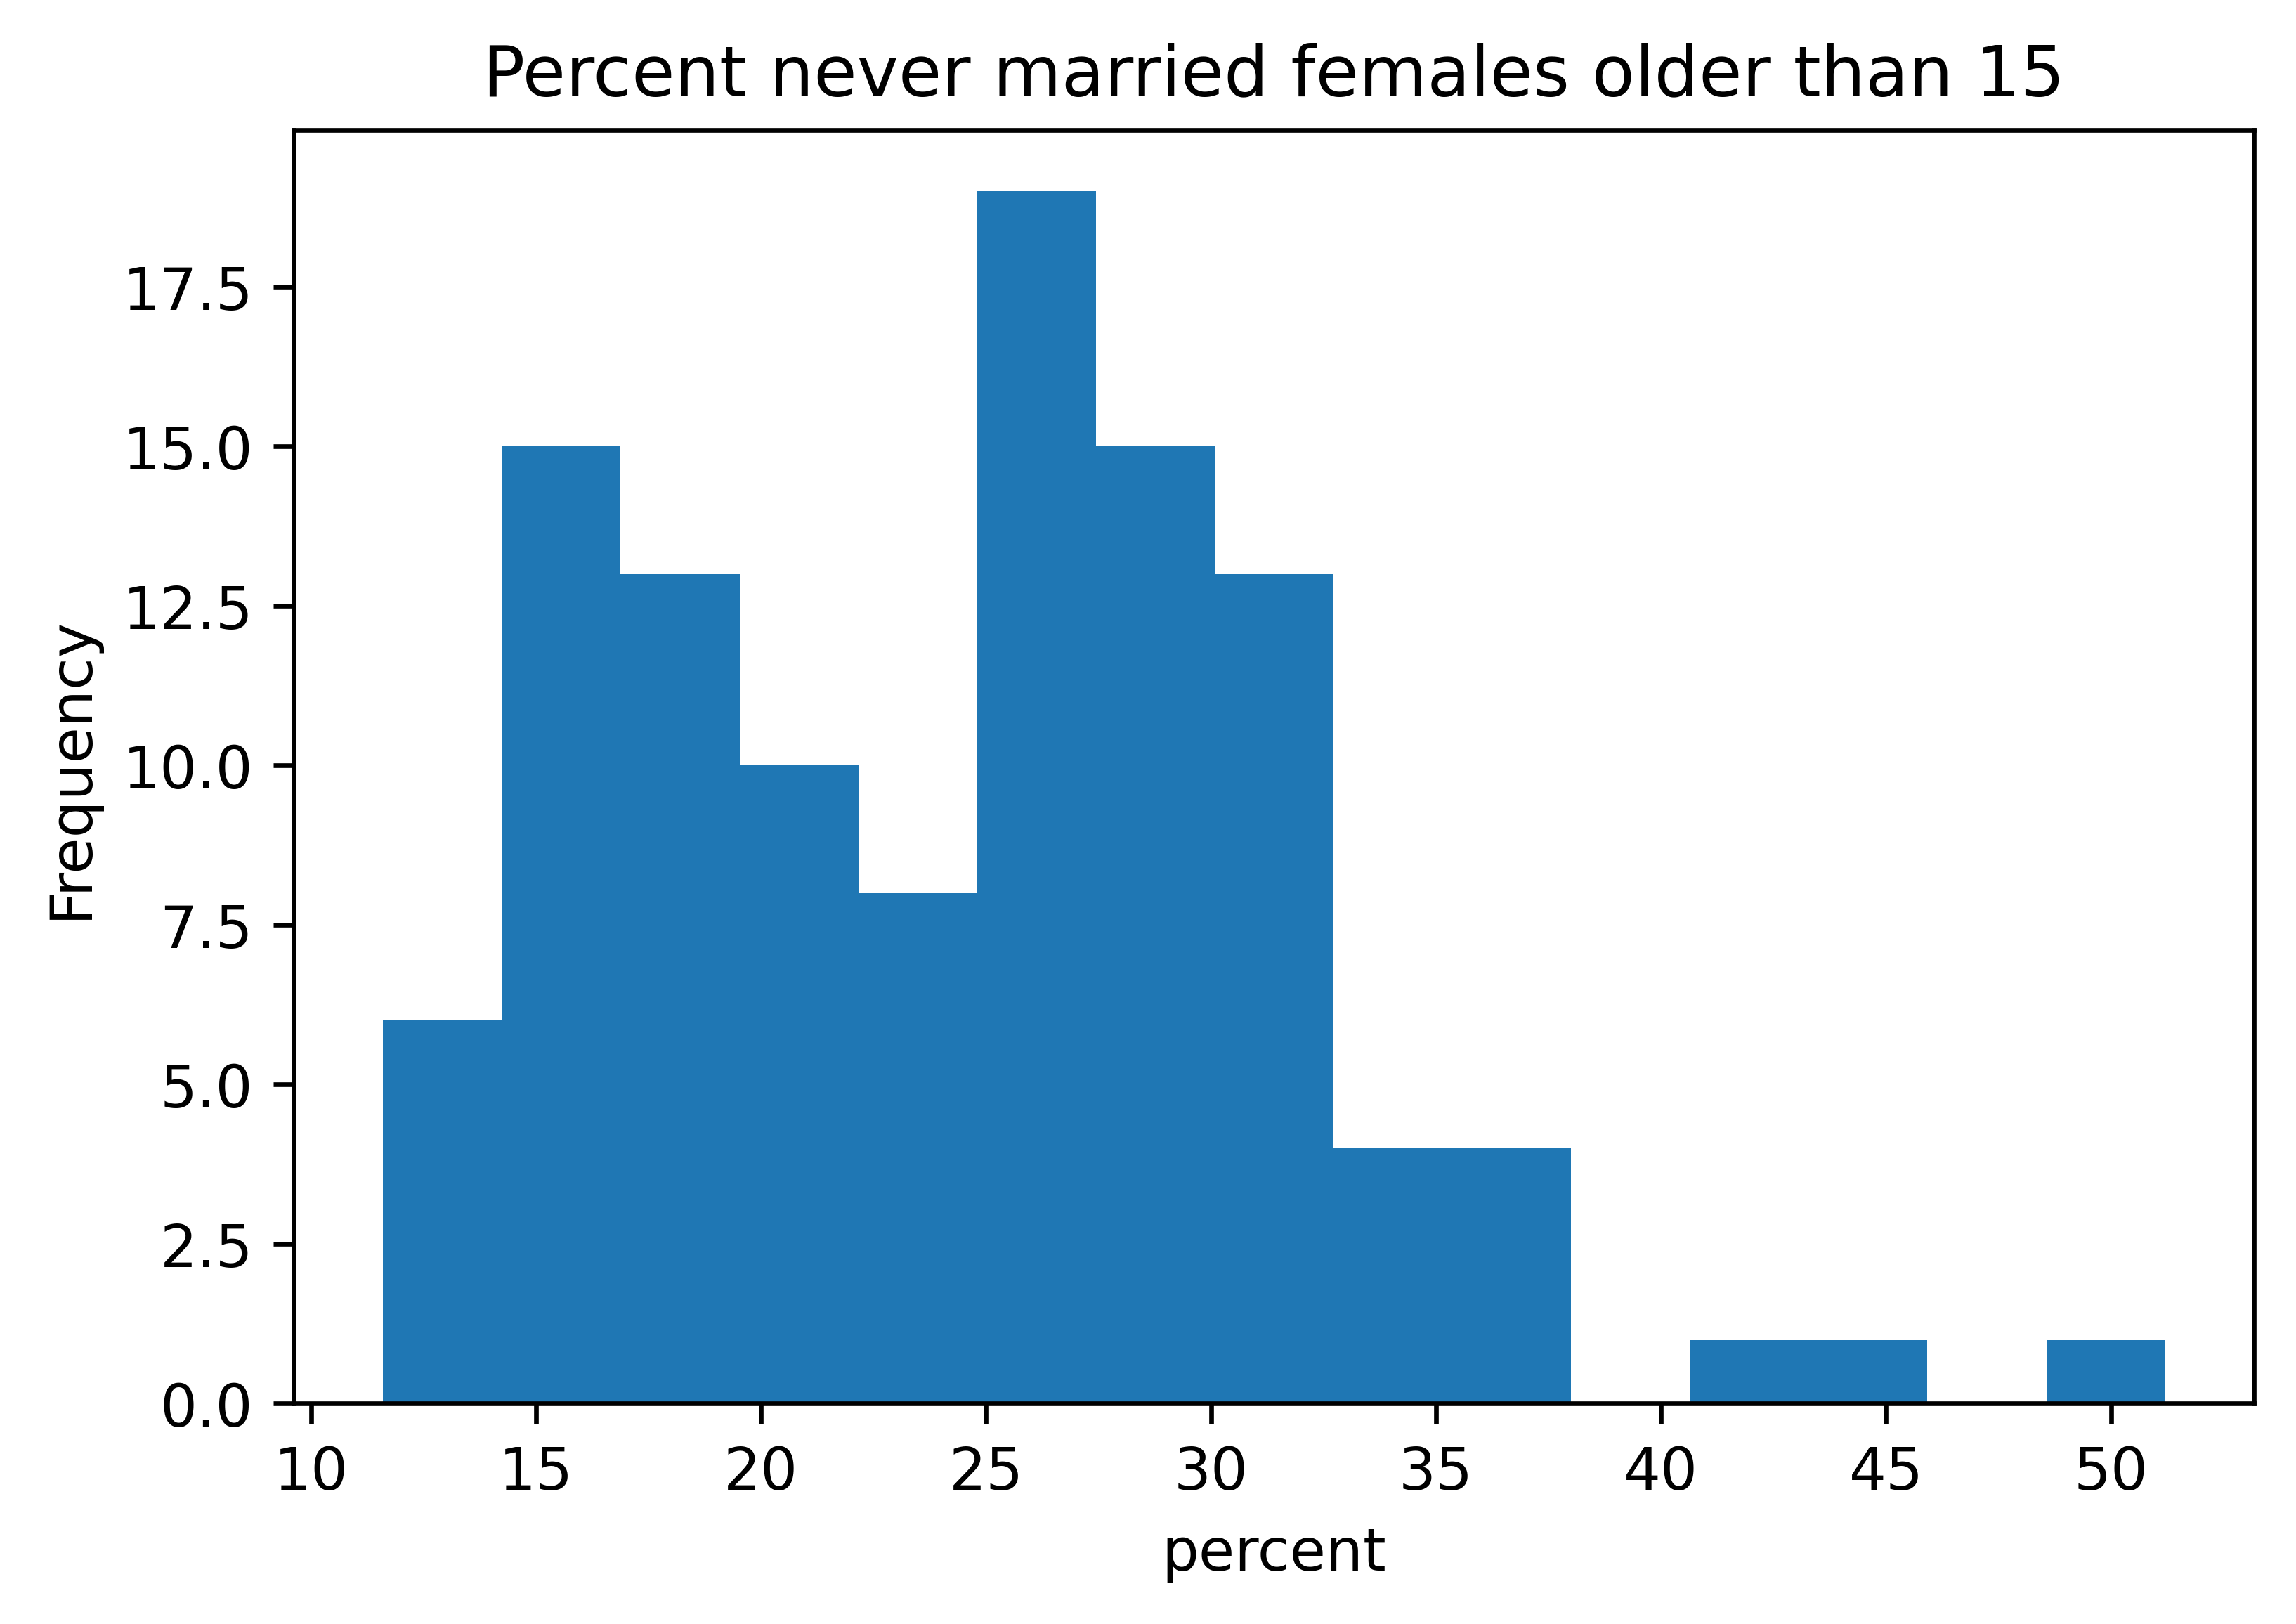

In [132]:
df_cars['pct never married females > 15'].plot(kind='hist', bins = 15)
plt.xlabel('percent')
plt.title('Percent never married females older than 15')

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 0, 'percent')

Text(0.5, 1.0, 'Percent never married males older than 15')

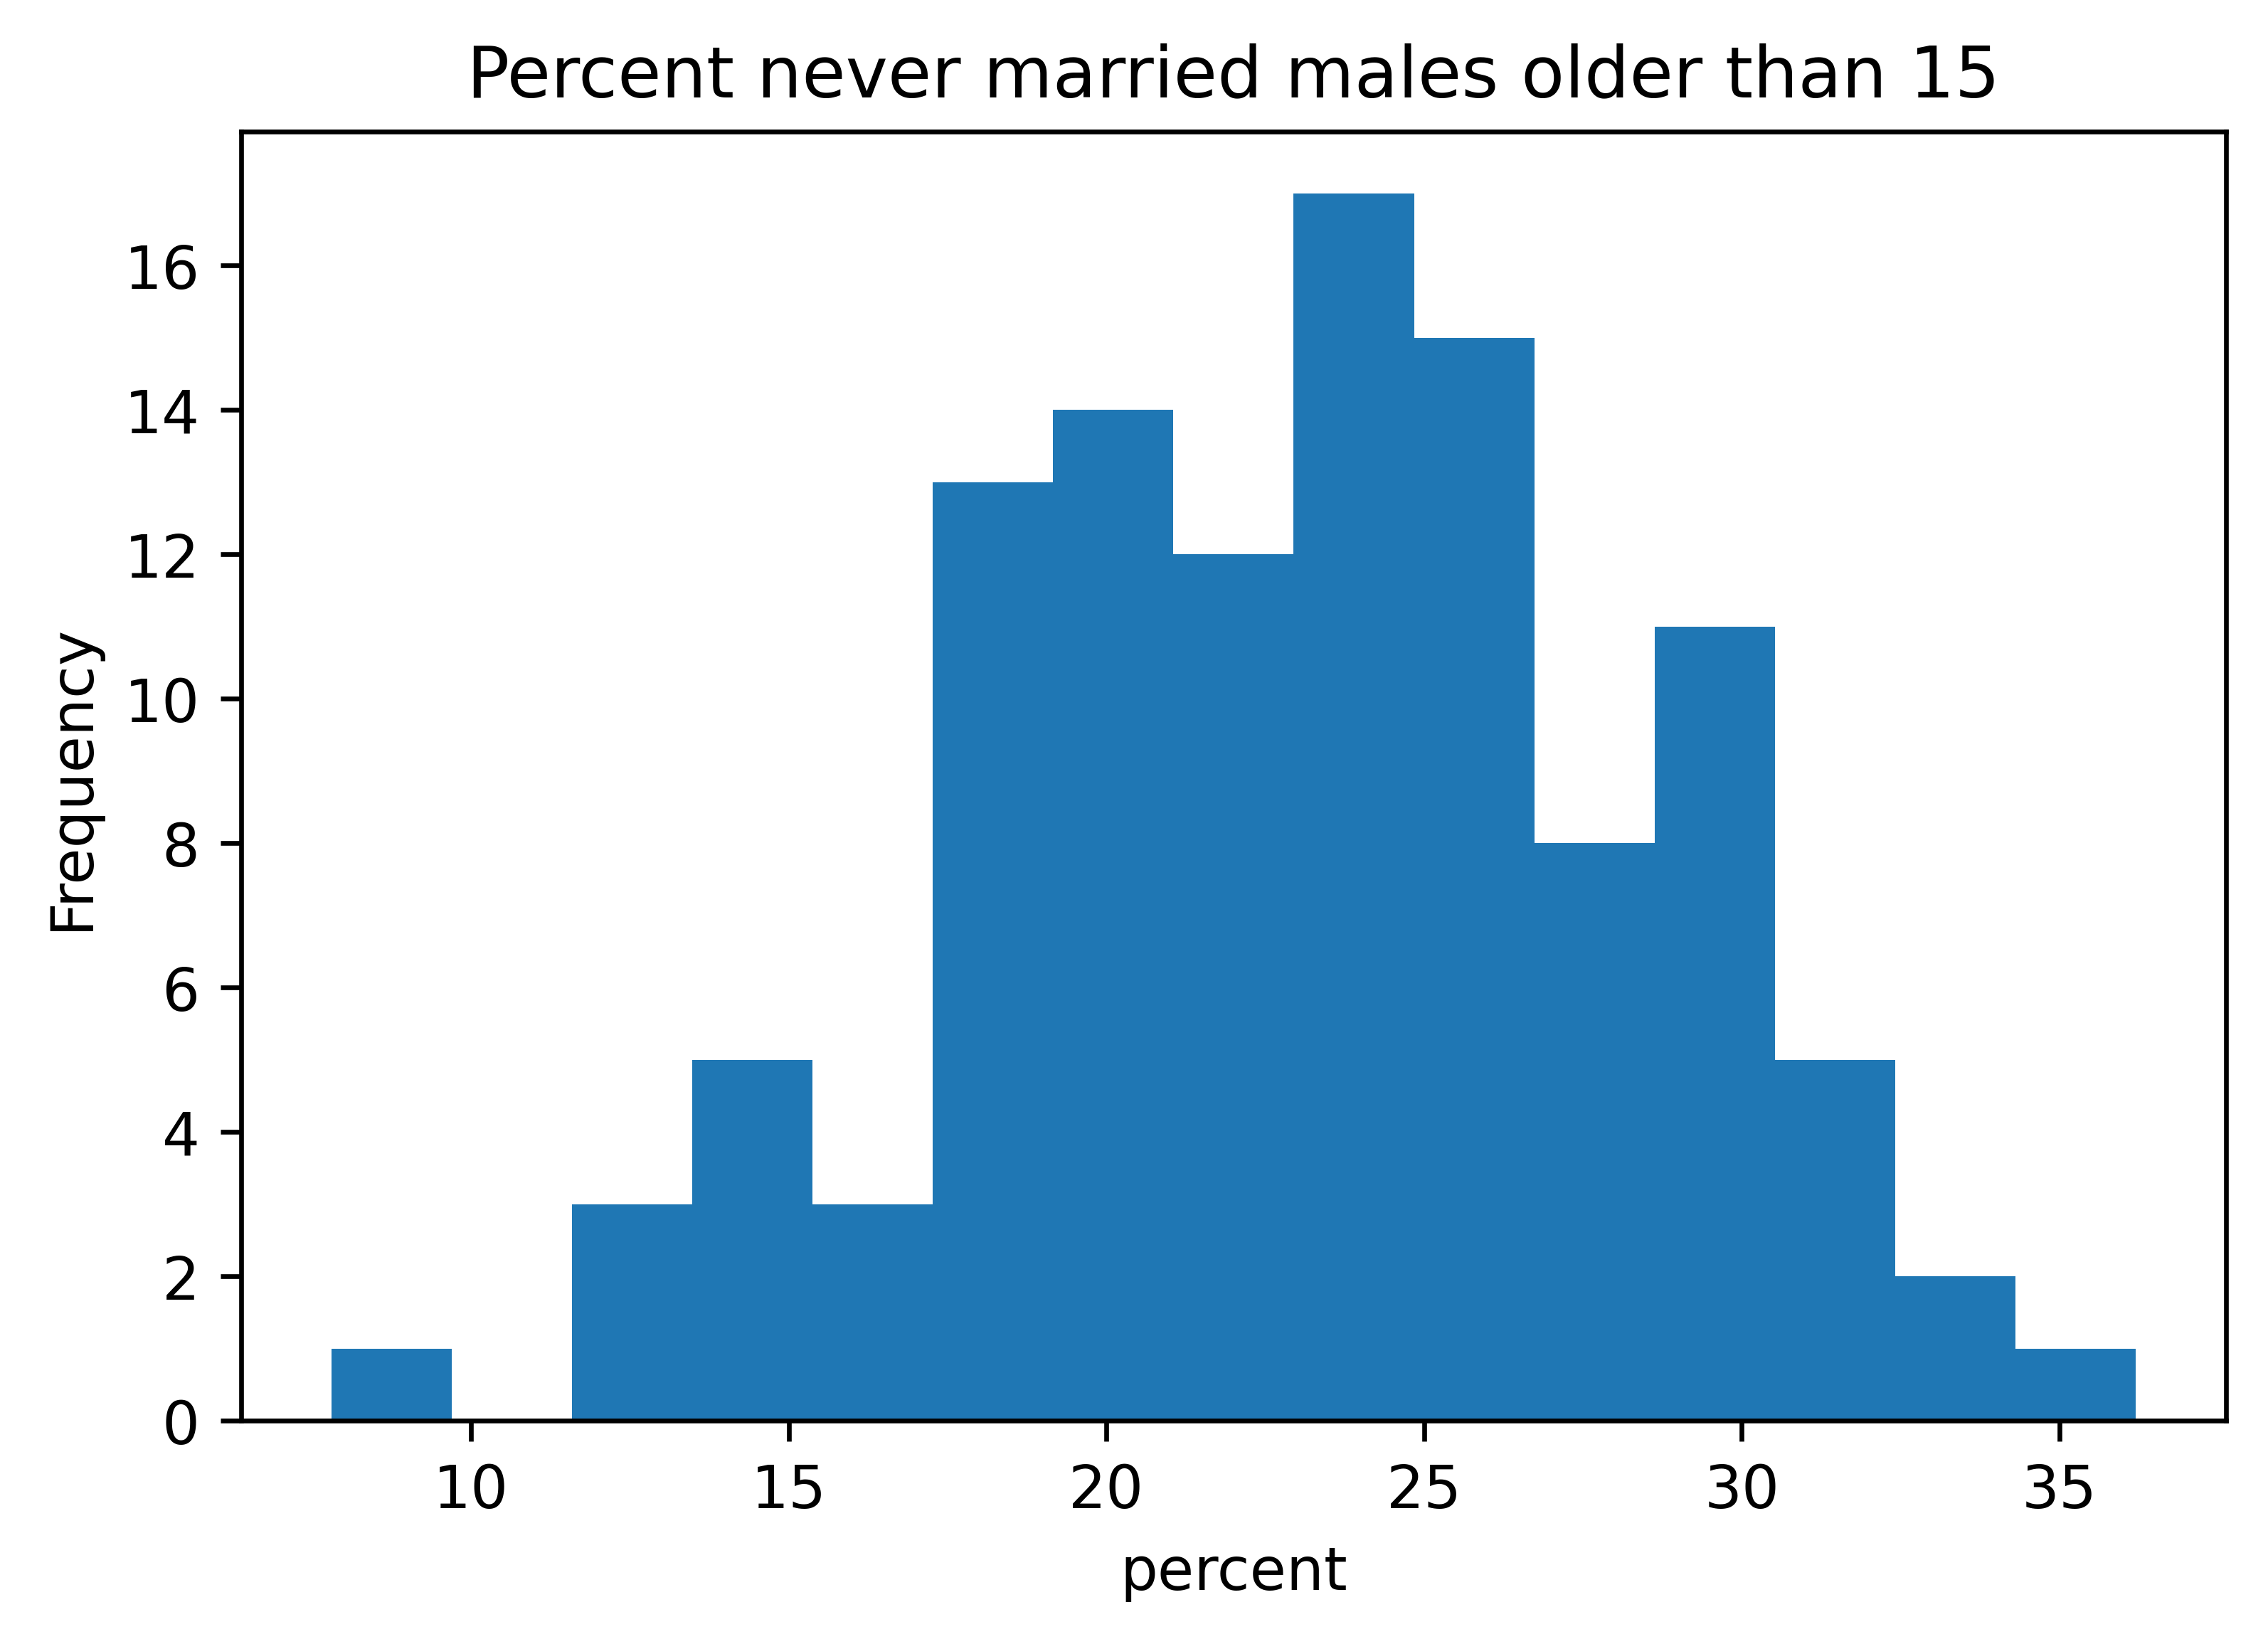

In [133]:
df_cars['pct never married males > 15'].plot(kind='hist', bins = 15)
plt.xlabel('percent')
plt.title('Percent never married males older than 15')

---
### Percent residents born in other states or outside the U.S.

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 0, 'percent')

Text(0.5, 1.0, 'Percent born in another U.S. state')

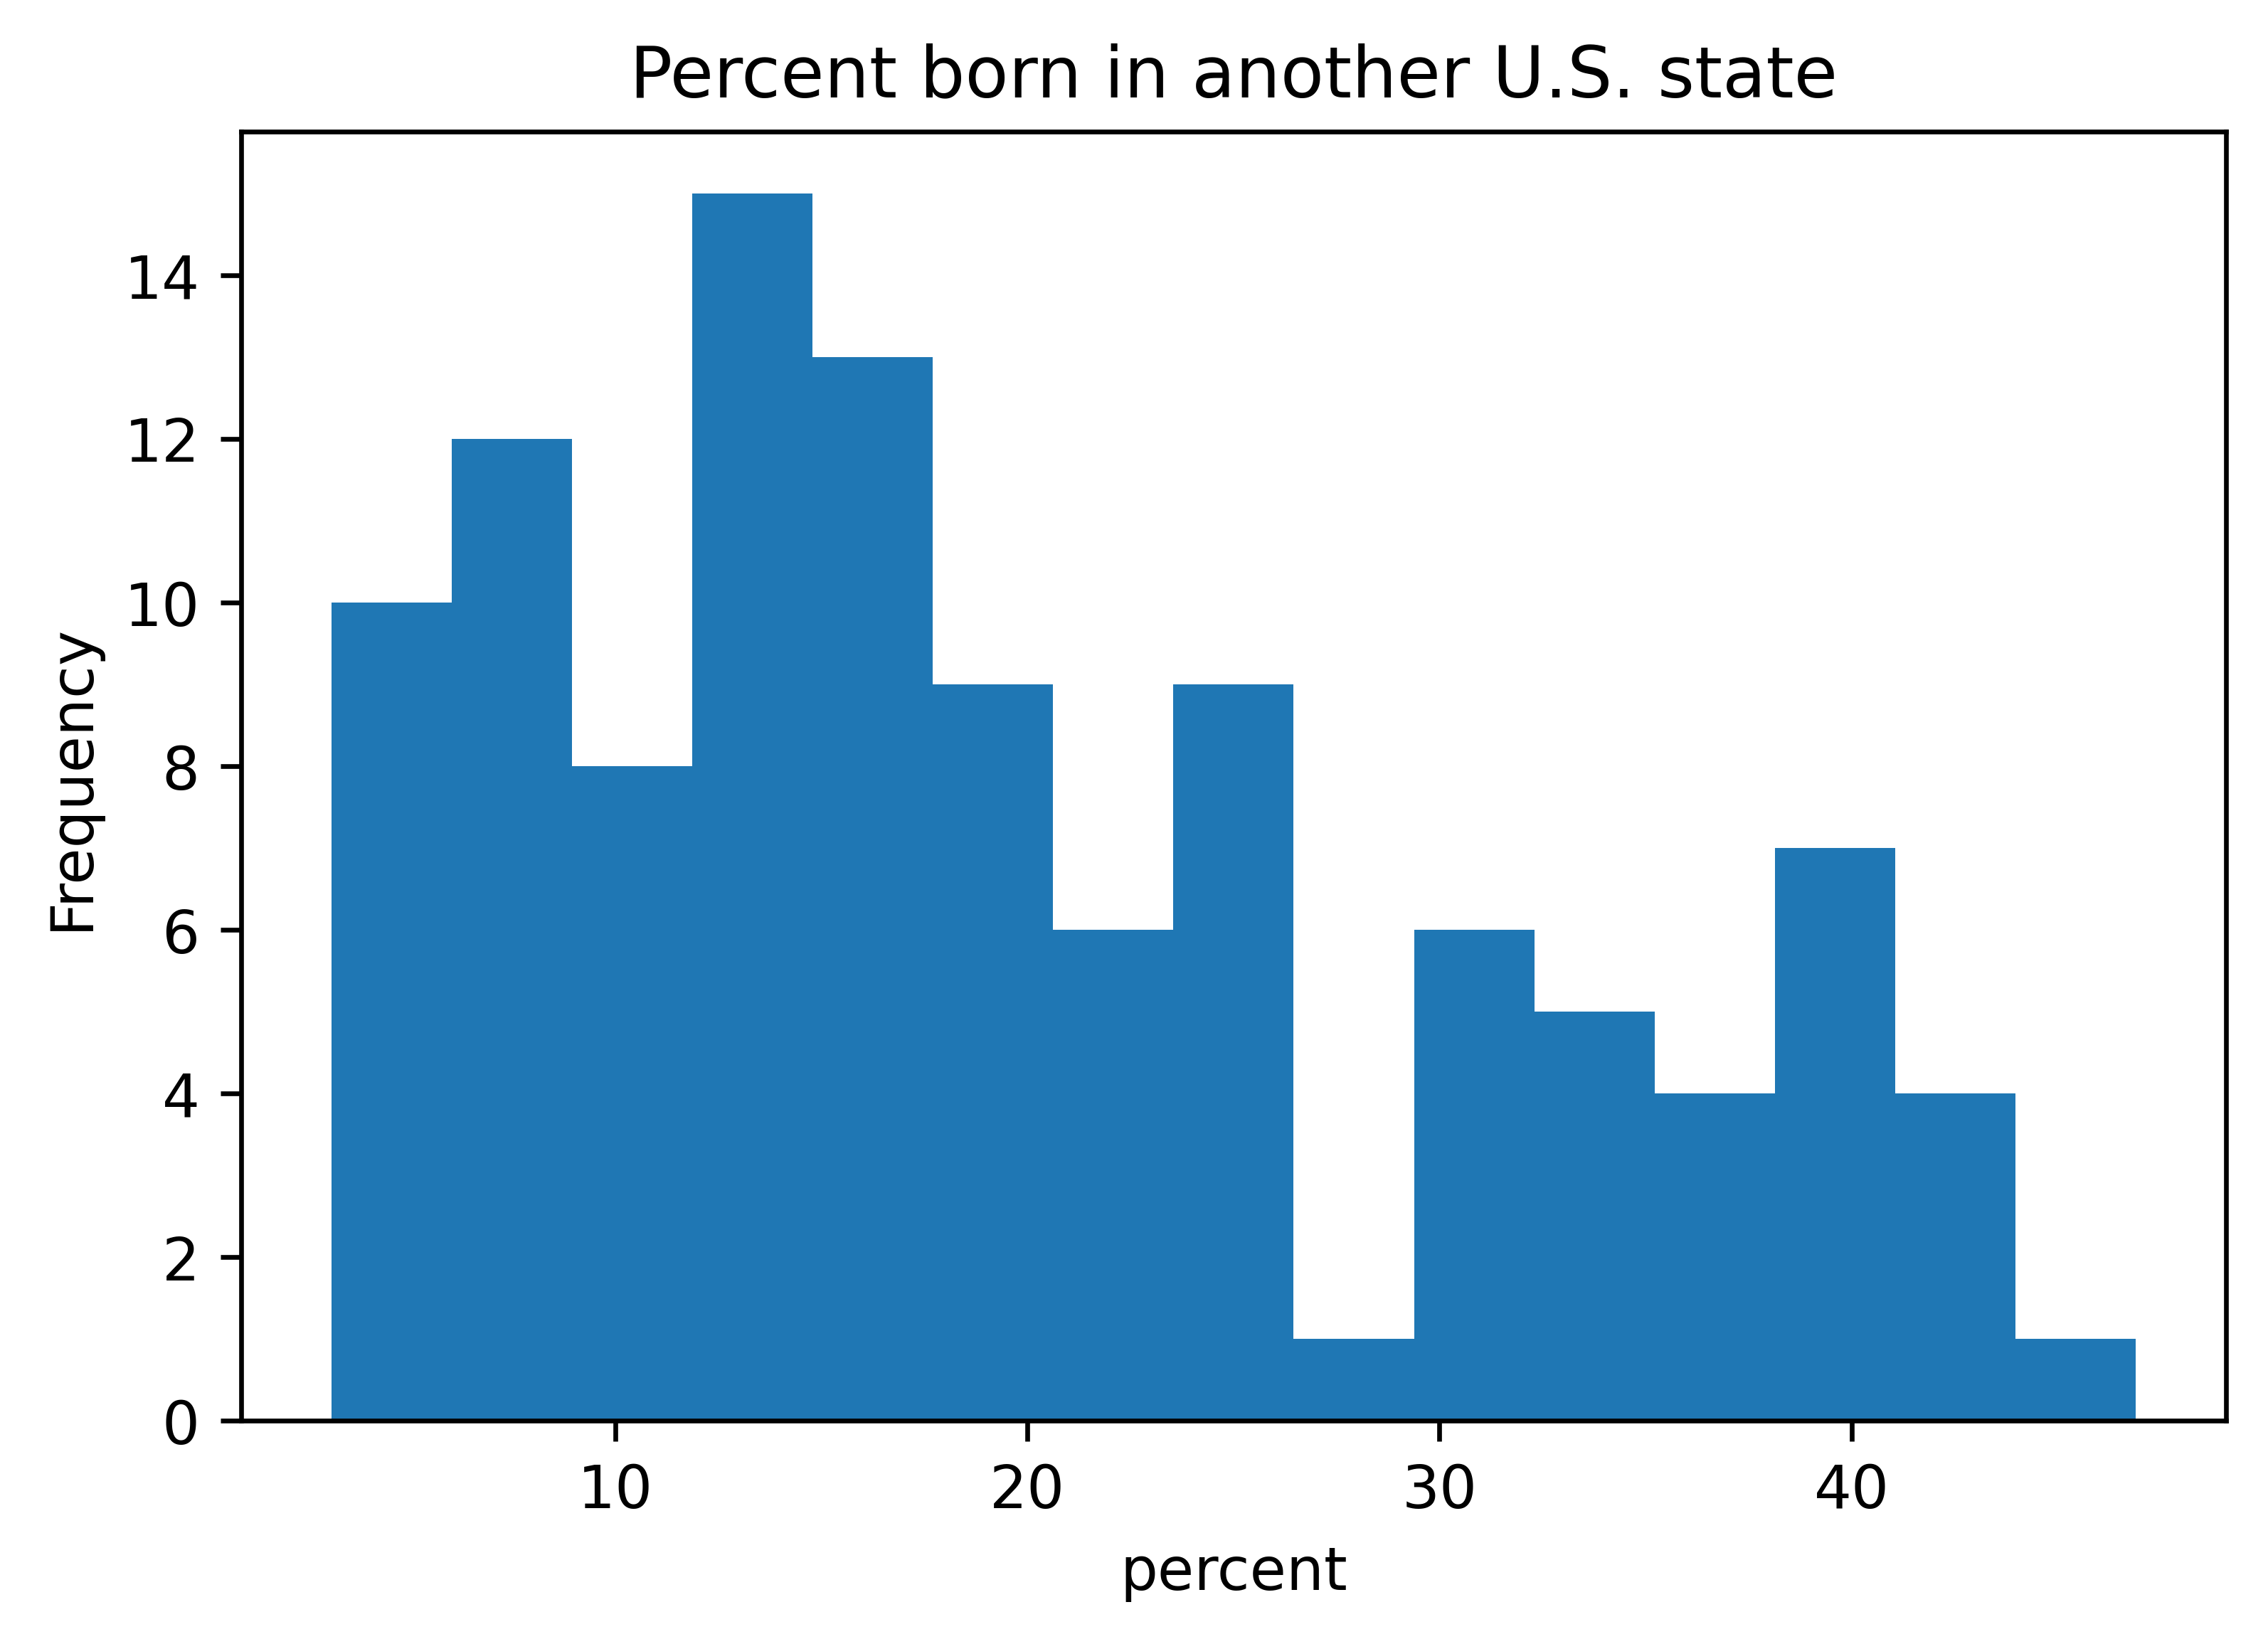

In [134]:
df_cars['pct born in another us state'].plot(kind='hist', bins = 15)
plt.xlabel('percent')
plt.title('Percent born in another U.S. state')

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 0, 'percent')

Text(0.5, 1.0, 'Percent born in IL')

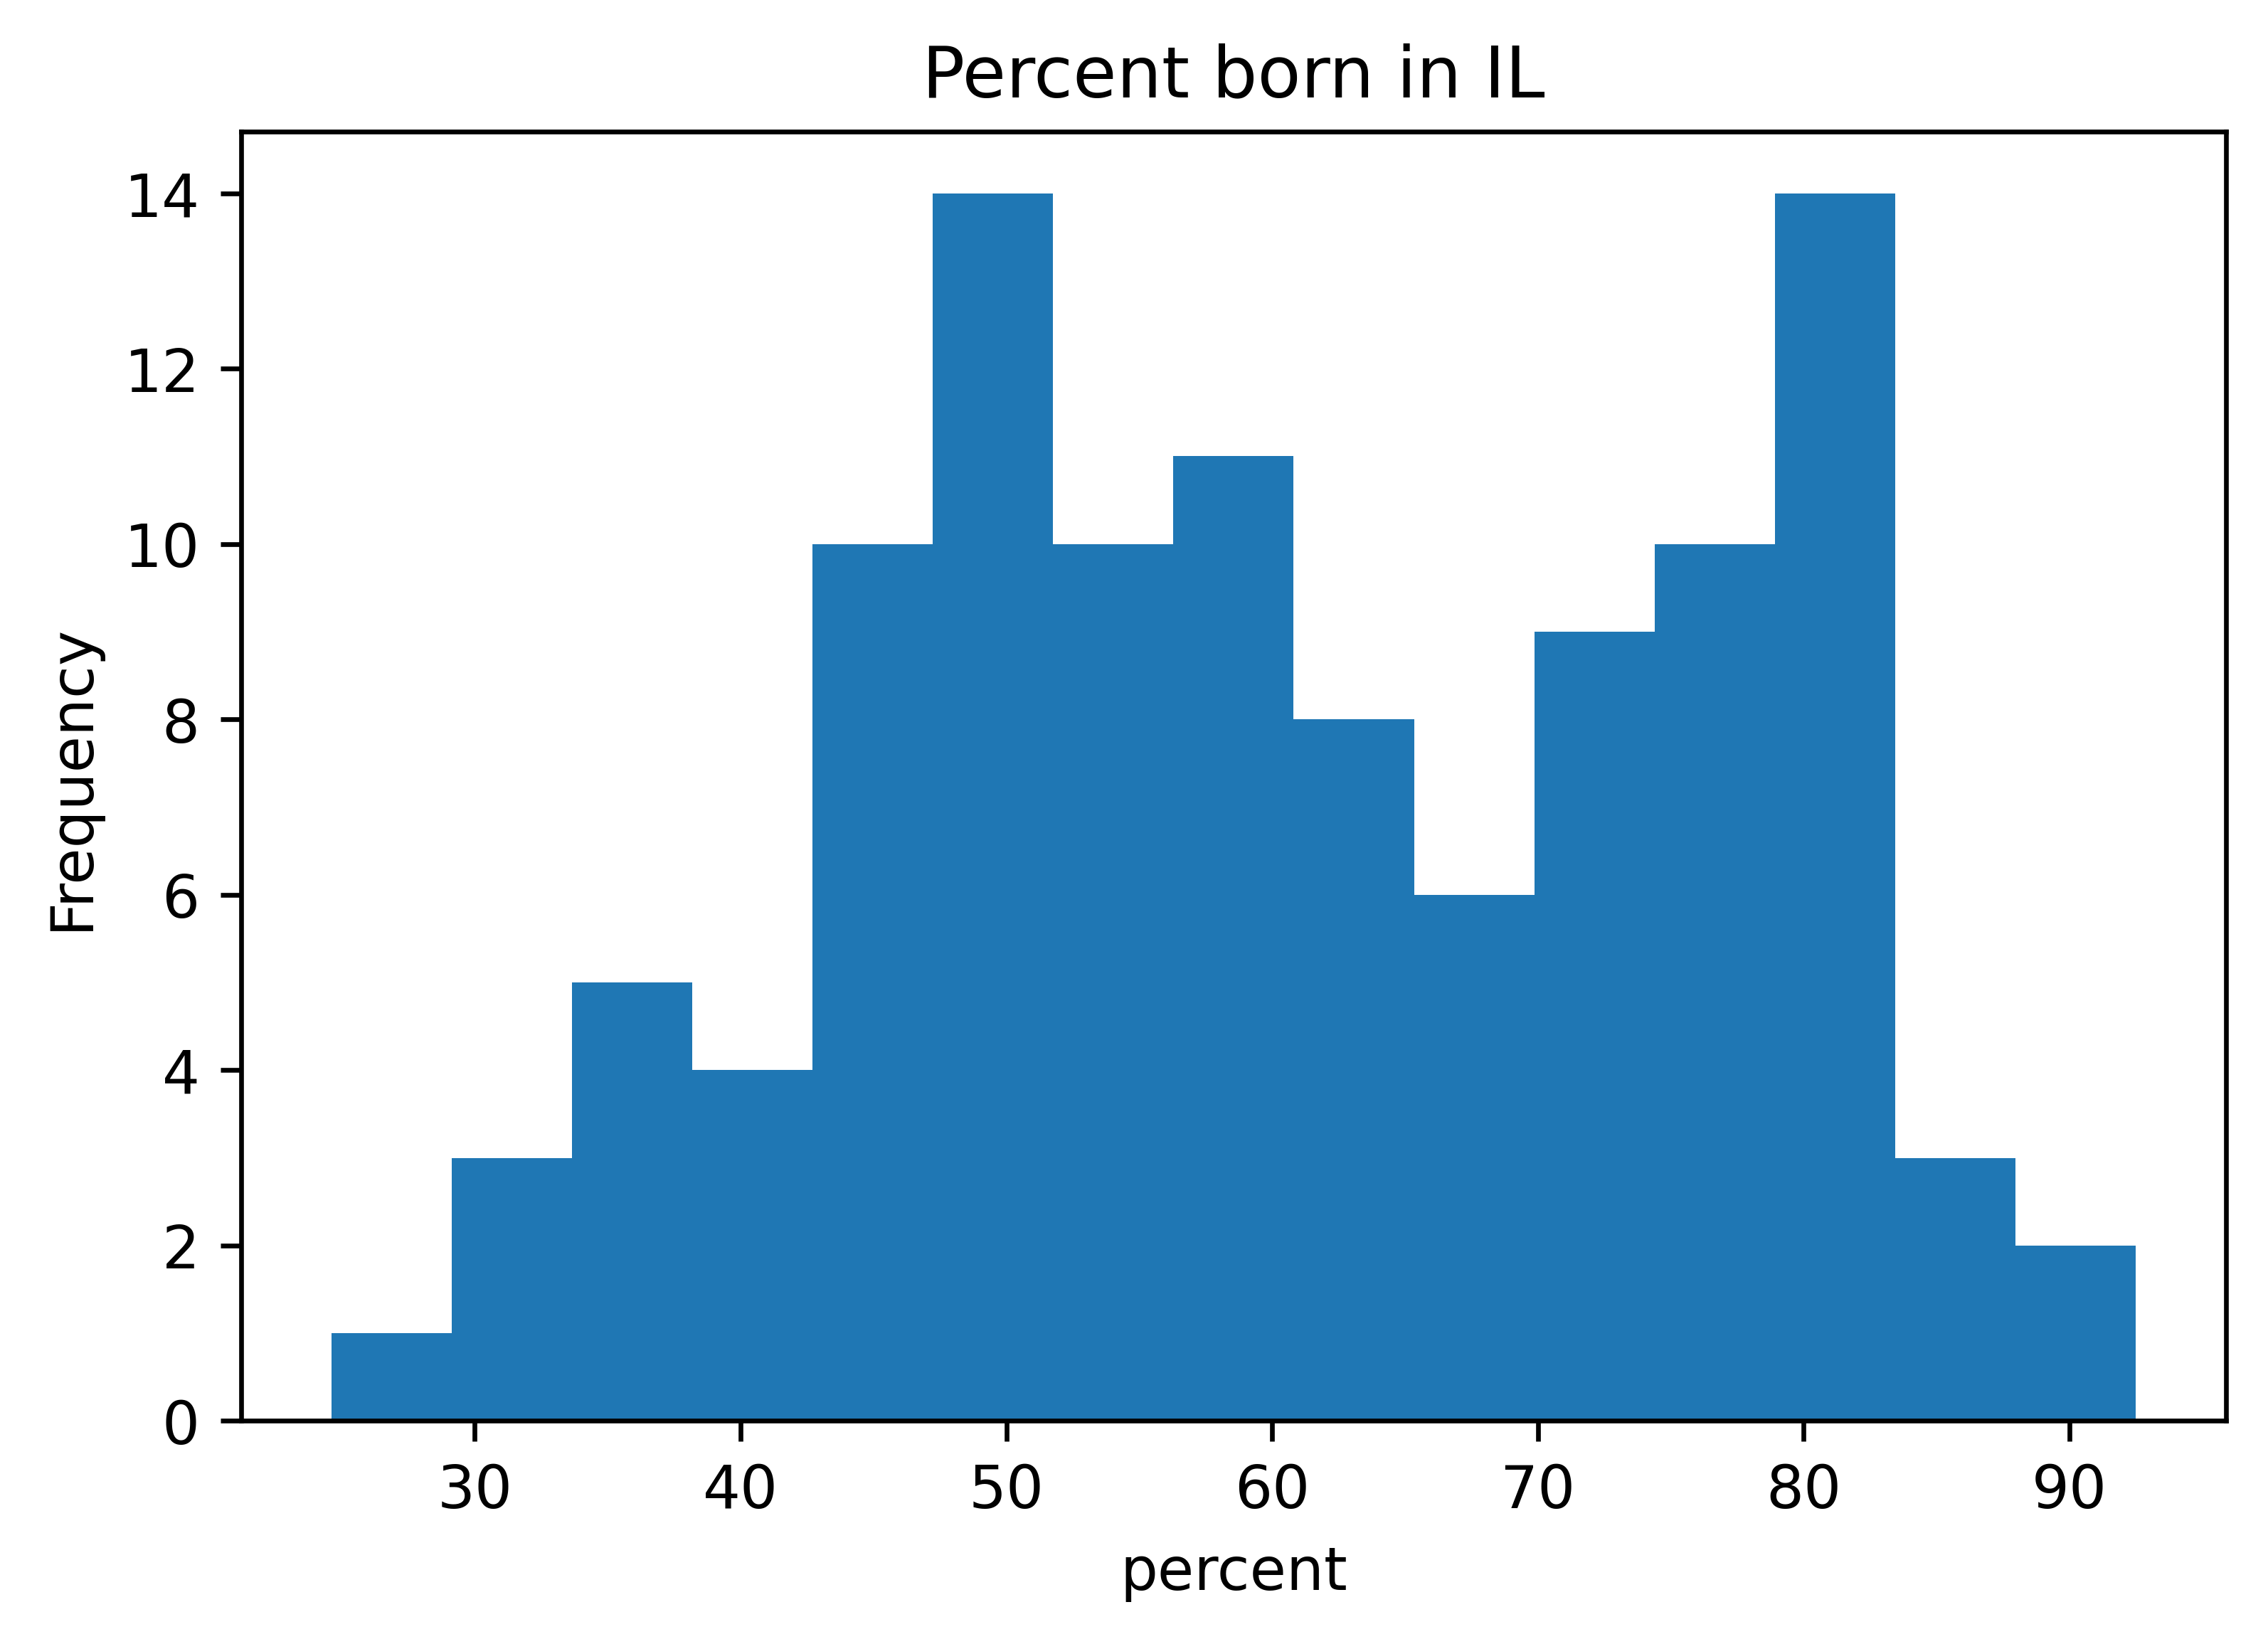

In [135]:
df_cars['pct born in state'].plot(kind='hist', bins = 15)
plt.xlabel('percent')
plt.title('Percent born in IL')

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 0, 'percent')

Text(0.5, 1.0, 'Percent foreign born residents')

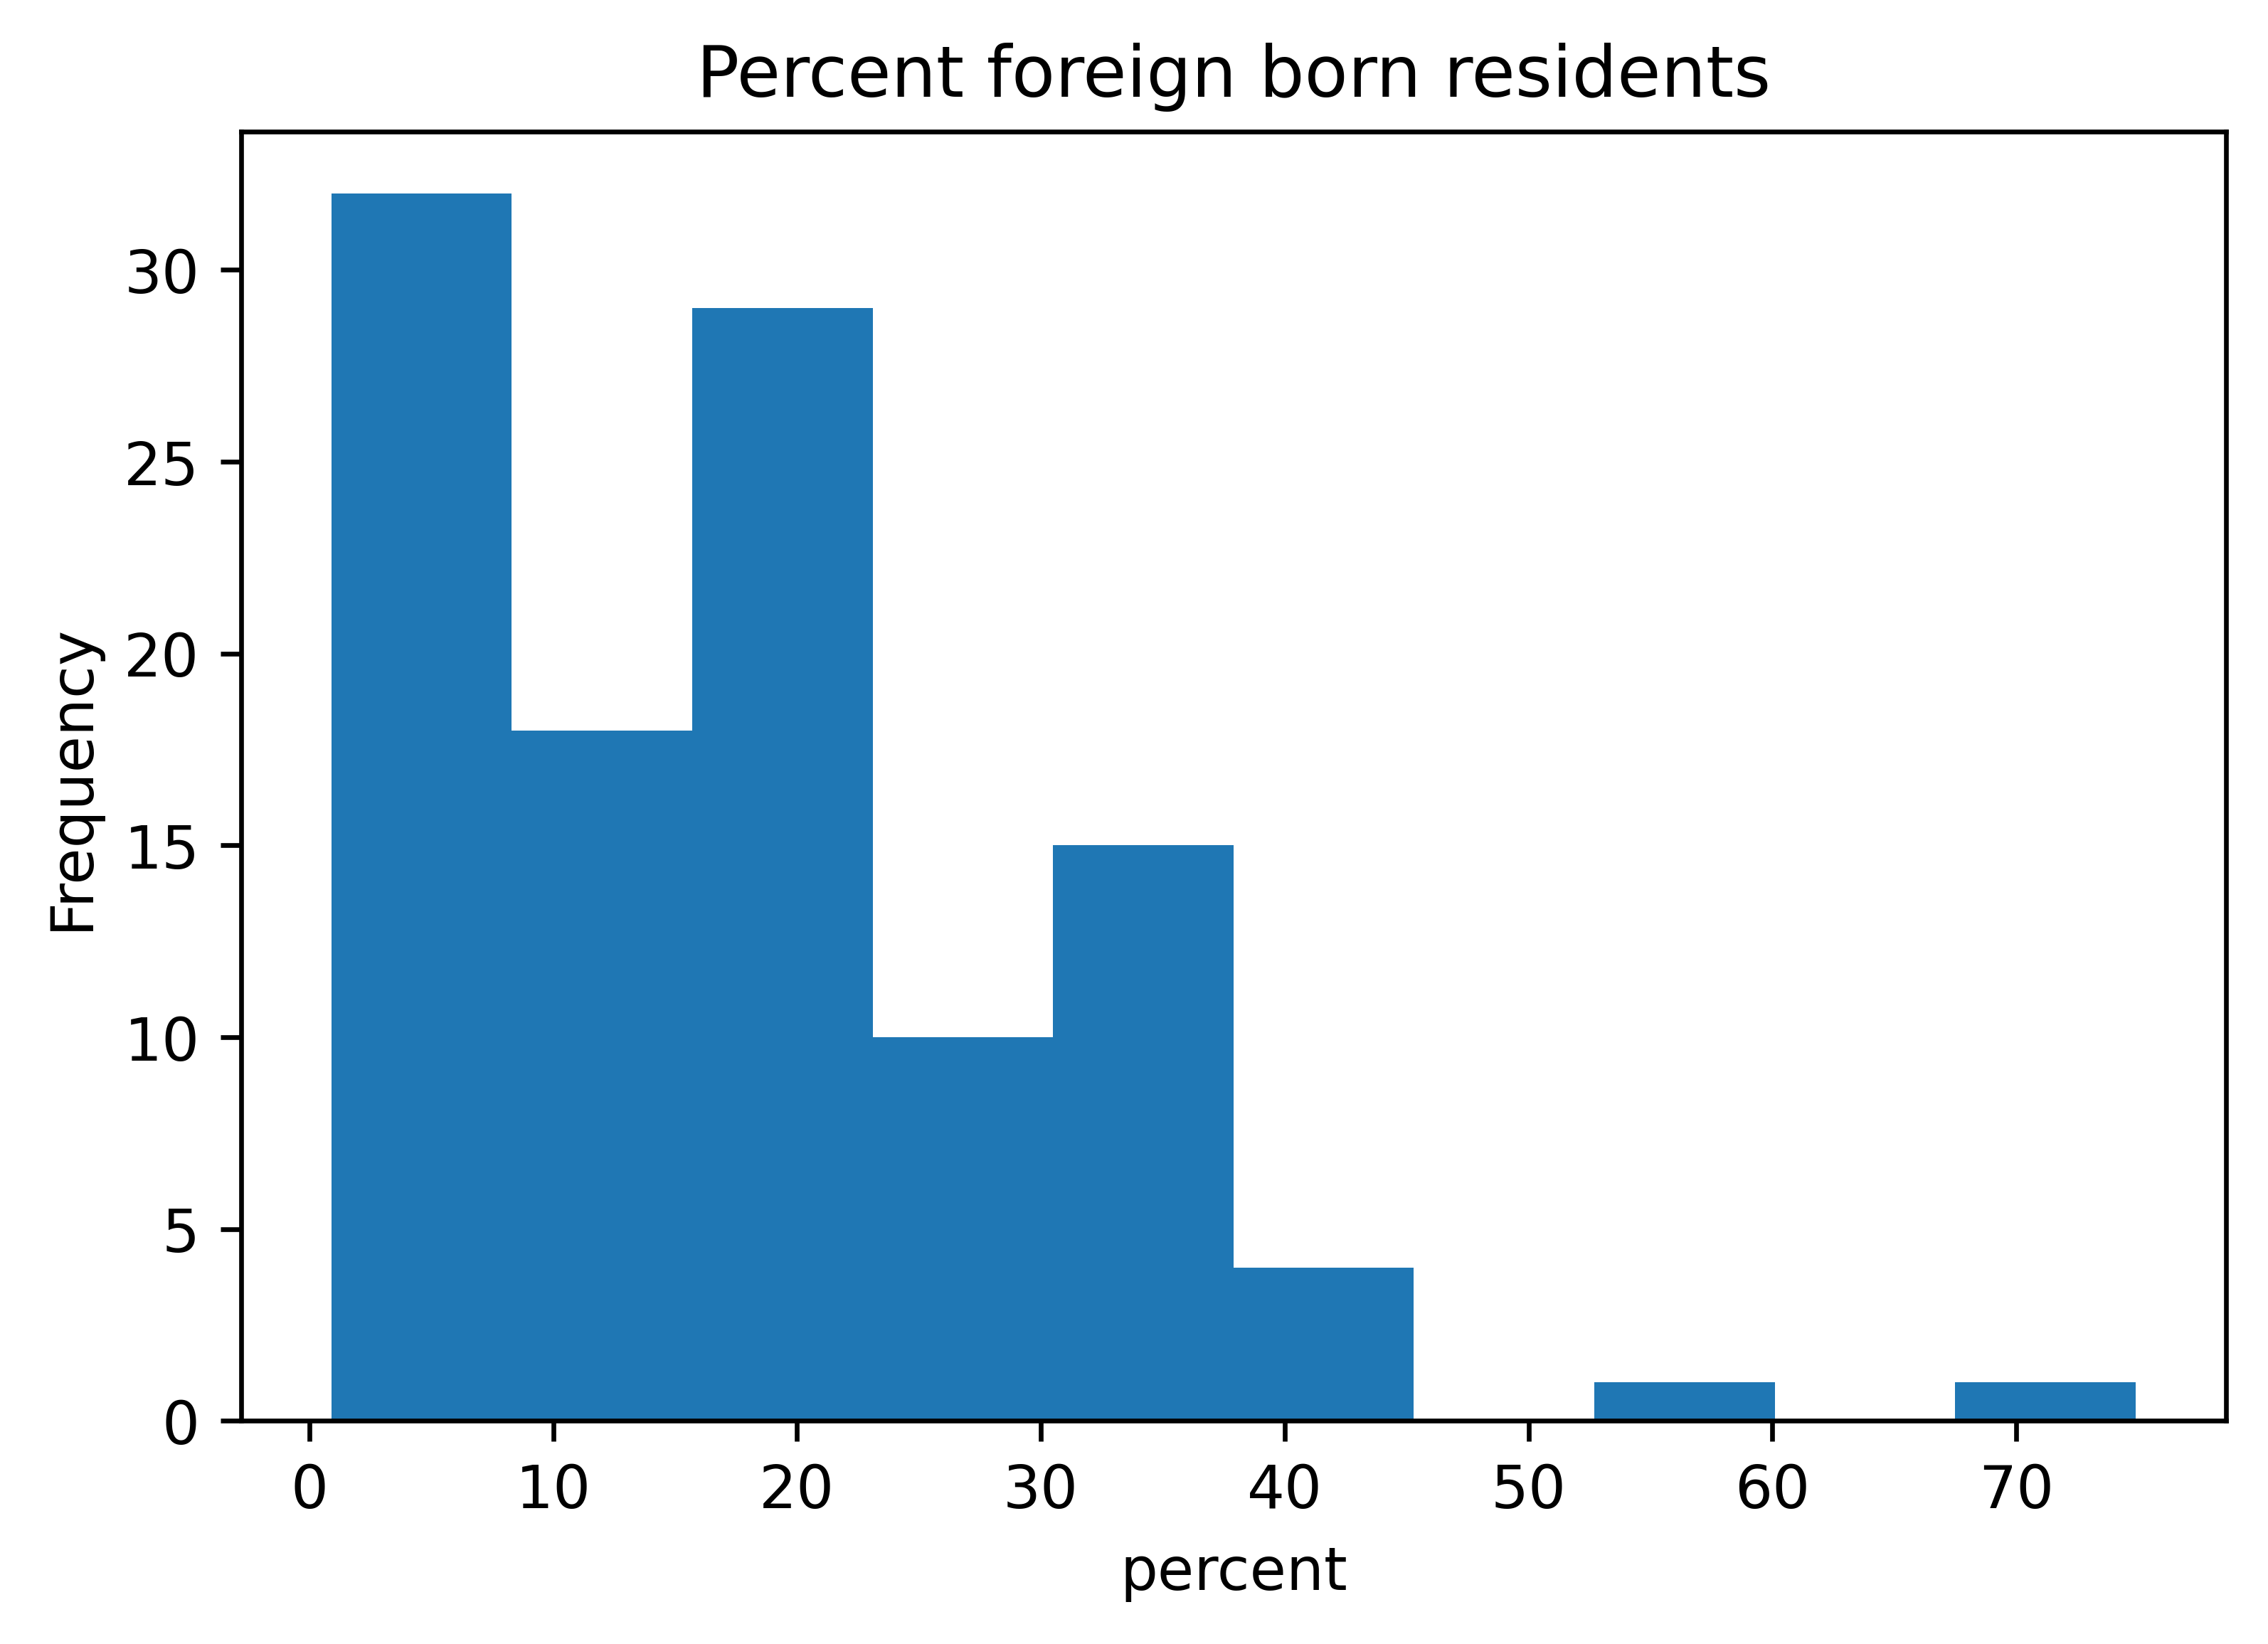

In [136]:
df_cars['pct foreign born residents'].plot(kind='hist', bins = 10)
plt.xlabel('percent')
plt.title('Percent foreign born residents')

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 0, 'percent')

Text(0.5, 1.0, 'Percent native residents born outside of the U.S.')

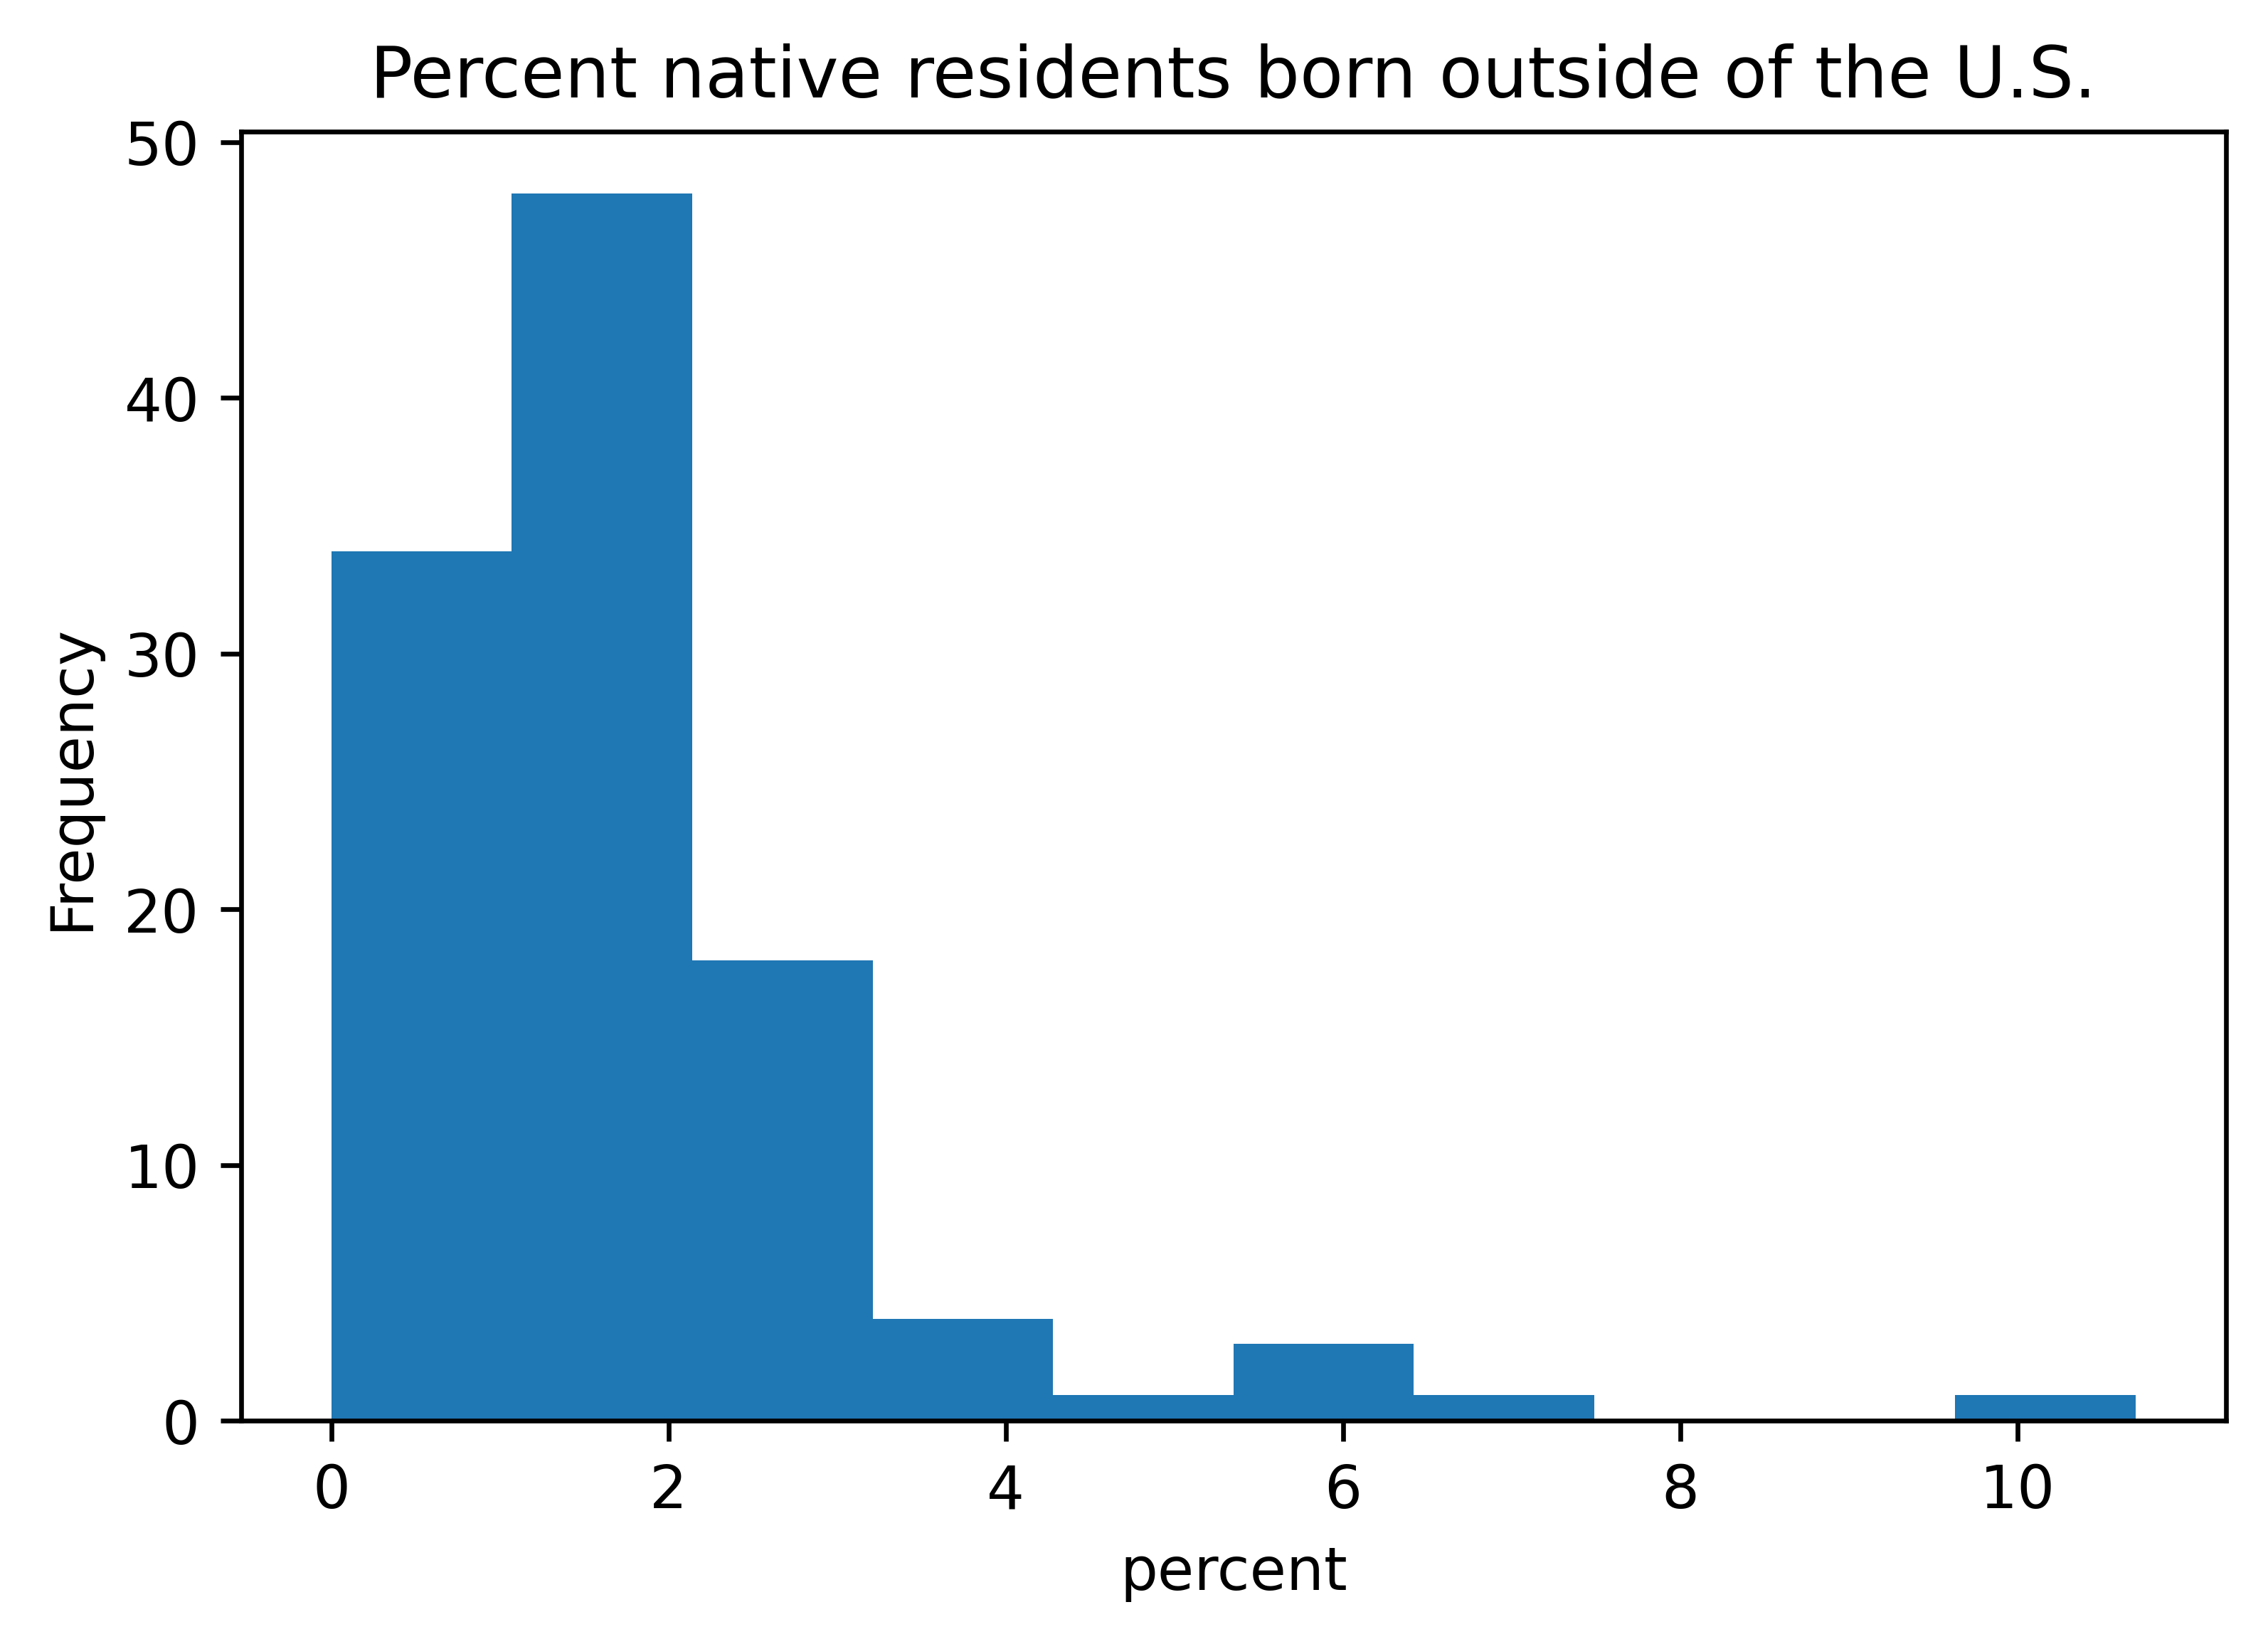

In [137]:
df_cars['pct native residents born outside us'].plot(kind='hist', bins = 10)
plt.xlabel('percent')
plt.title('Percent native residents born outside of the U.S.')

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 0, 'percent')

Text(0.5, 1.0, 'Percent residents who do not speak English well')

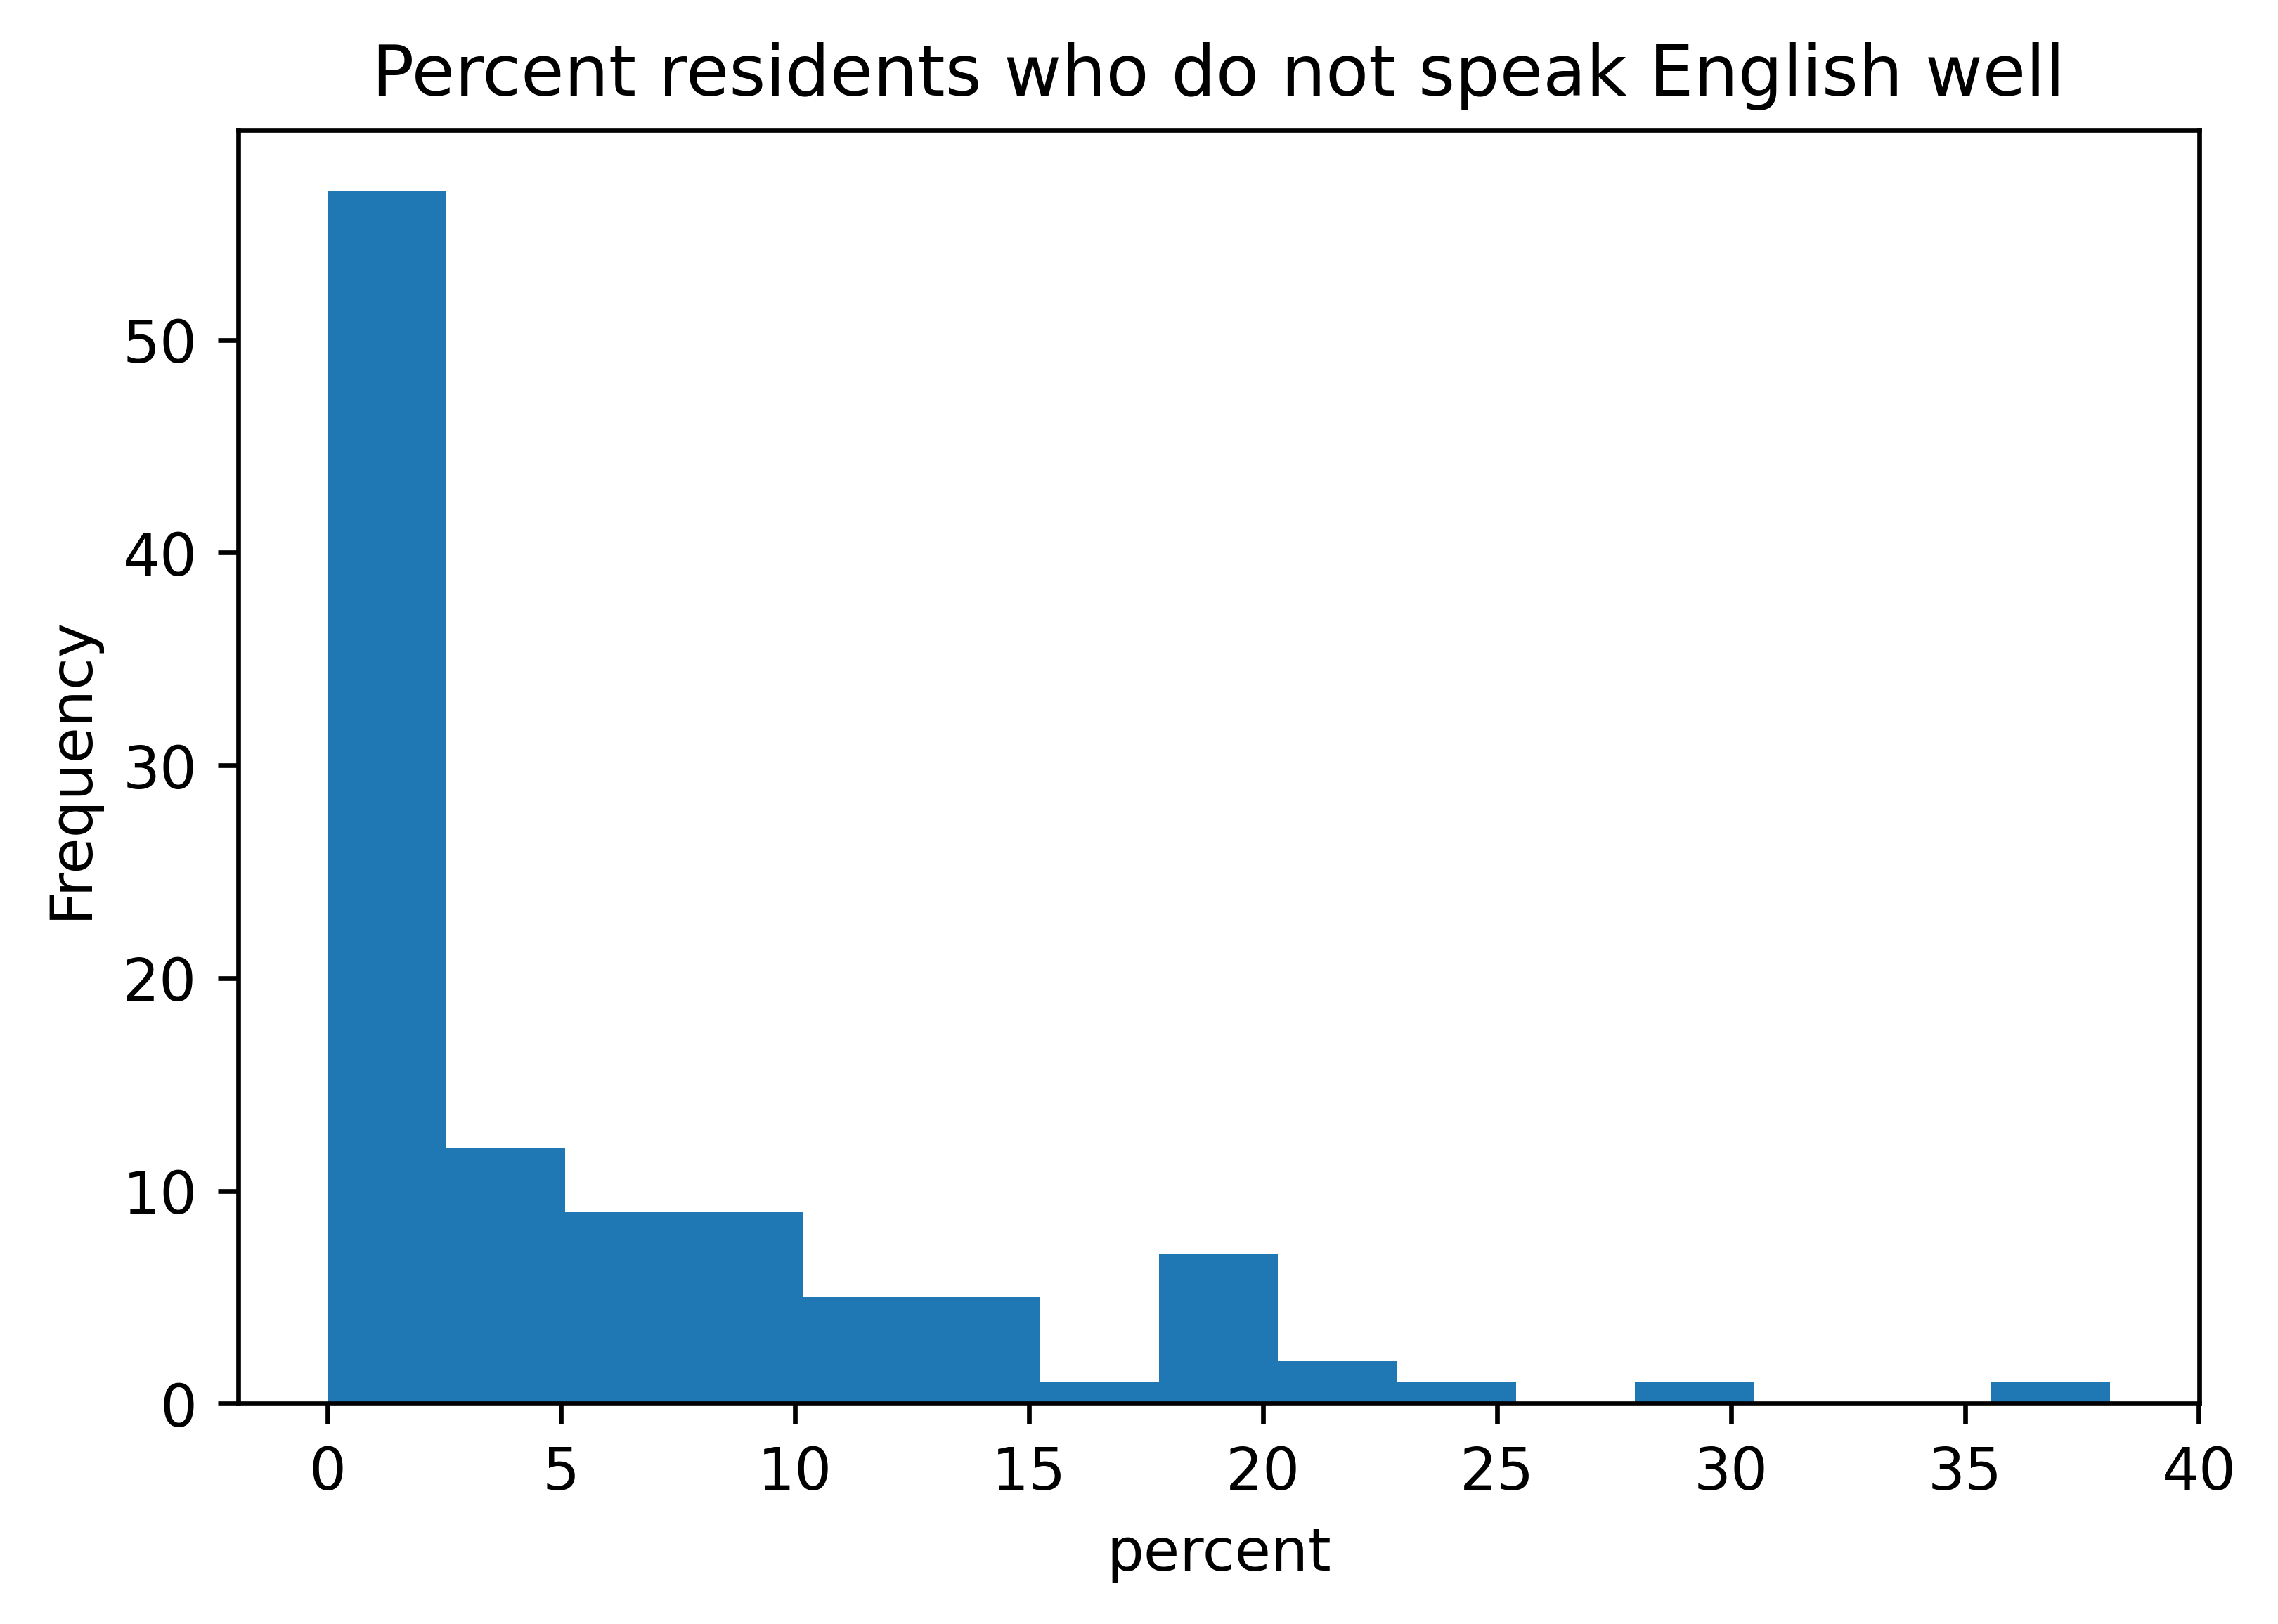

In [138]:
df_cars['pct not speak English well'].plot(kind='hist', bins = 15)
plt.xlabel('percent')
plt.title('Percent residents who do not speak English well')

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 0, 'percent')

Text(0.5, 1.0, 'Percent single mother households')

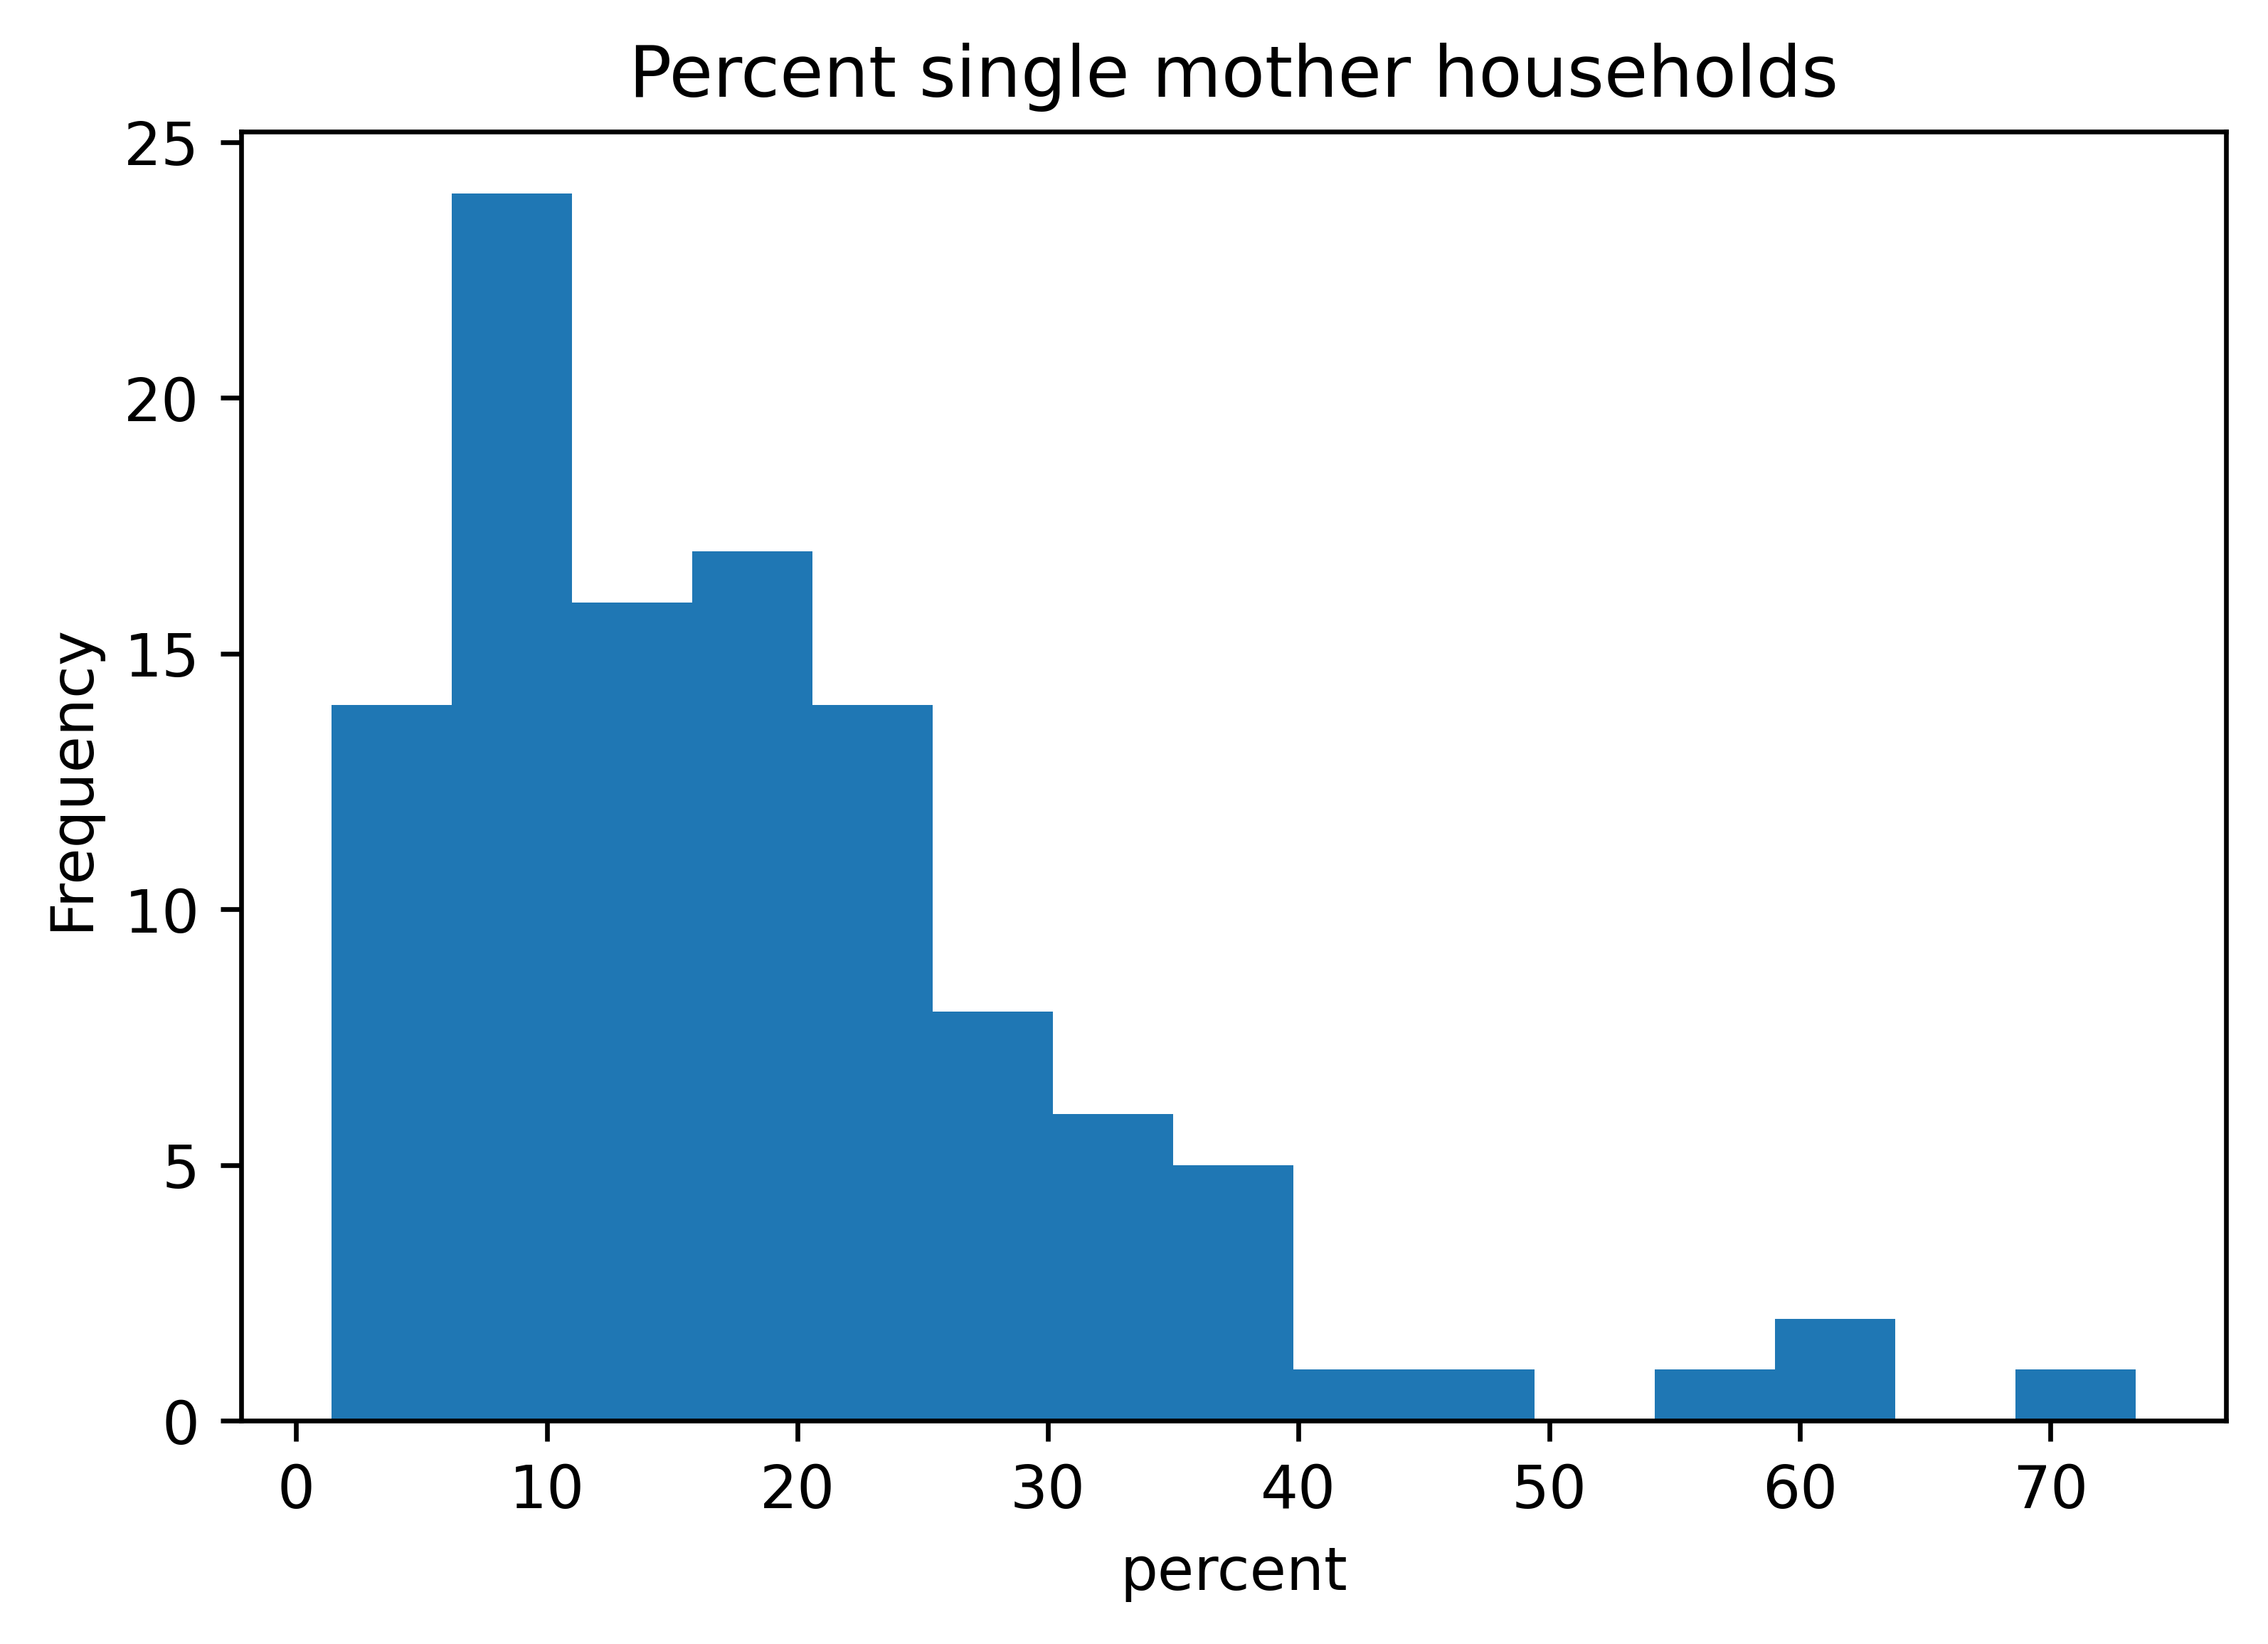

In [139]:
df_cars['pct single mother'].plot(kind='hist', bins = 15)
plt.xlabel('percent')
plt.title('Percent single mother households')

In [140]:
df_cars = df_cars[df_cars['pct units mortgage'] < 100]

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 0, 'percent')

Text(0.5, 1.0, 'Percent units with mortgage')

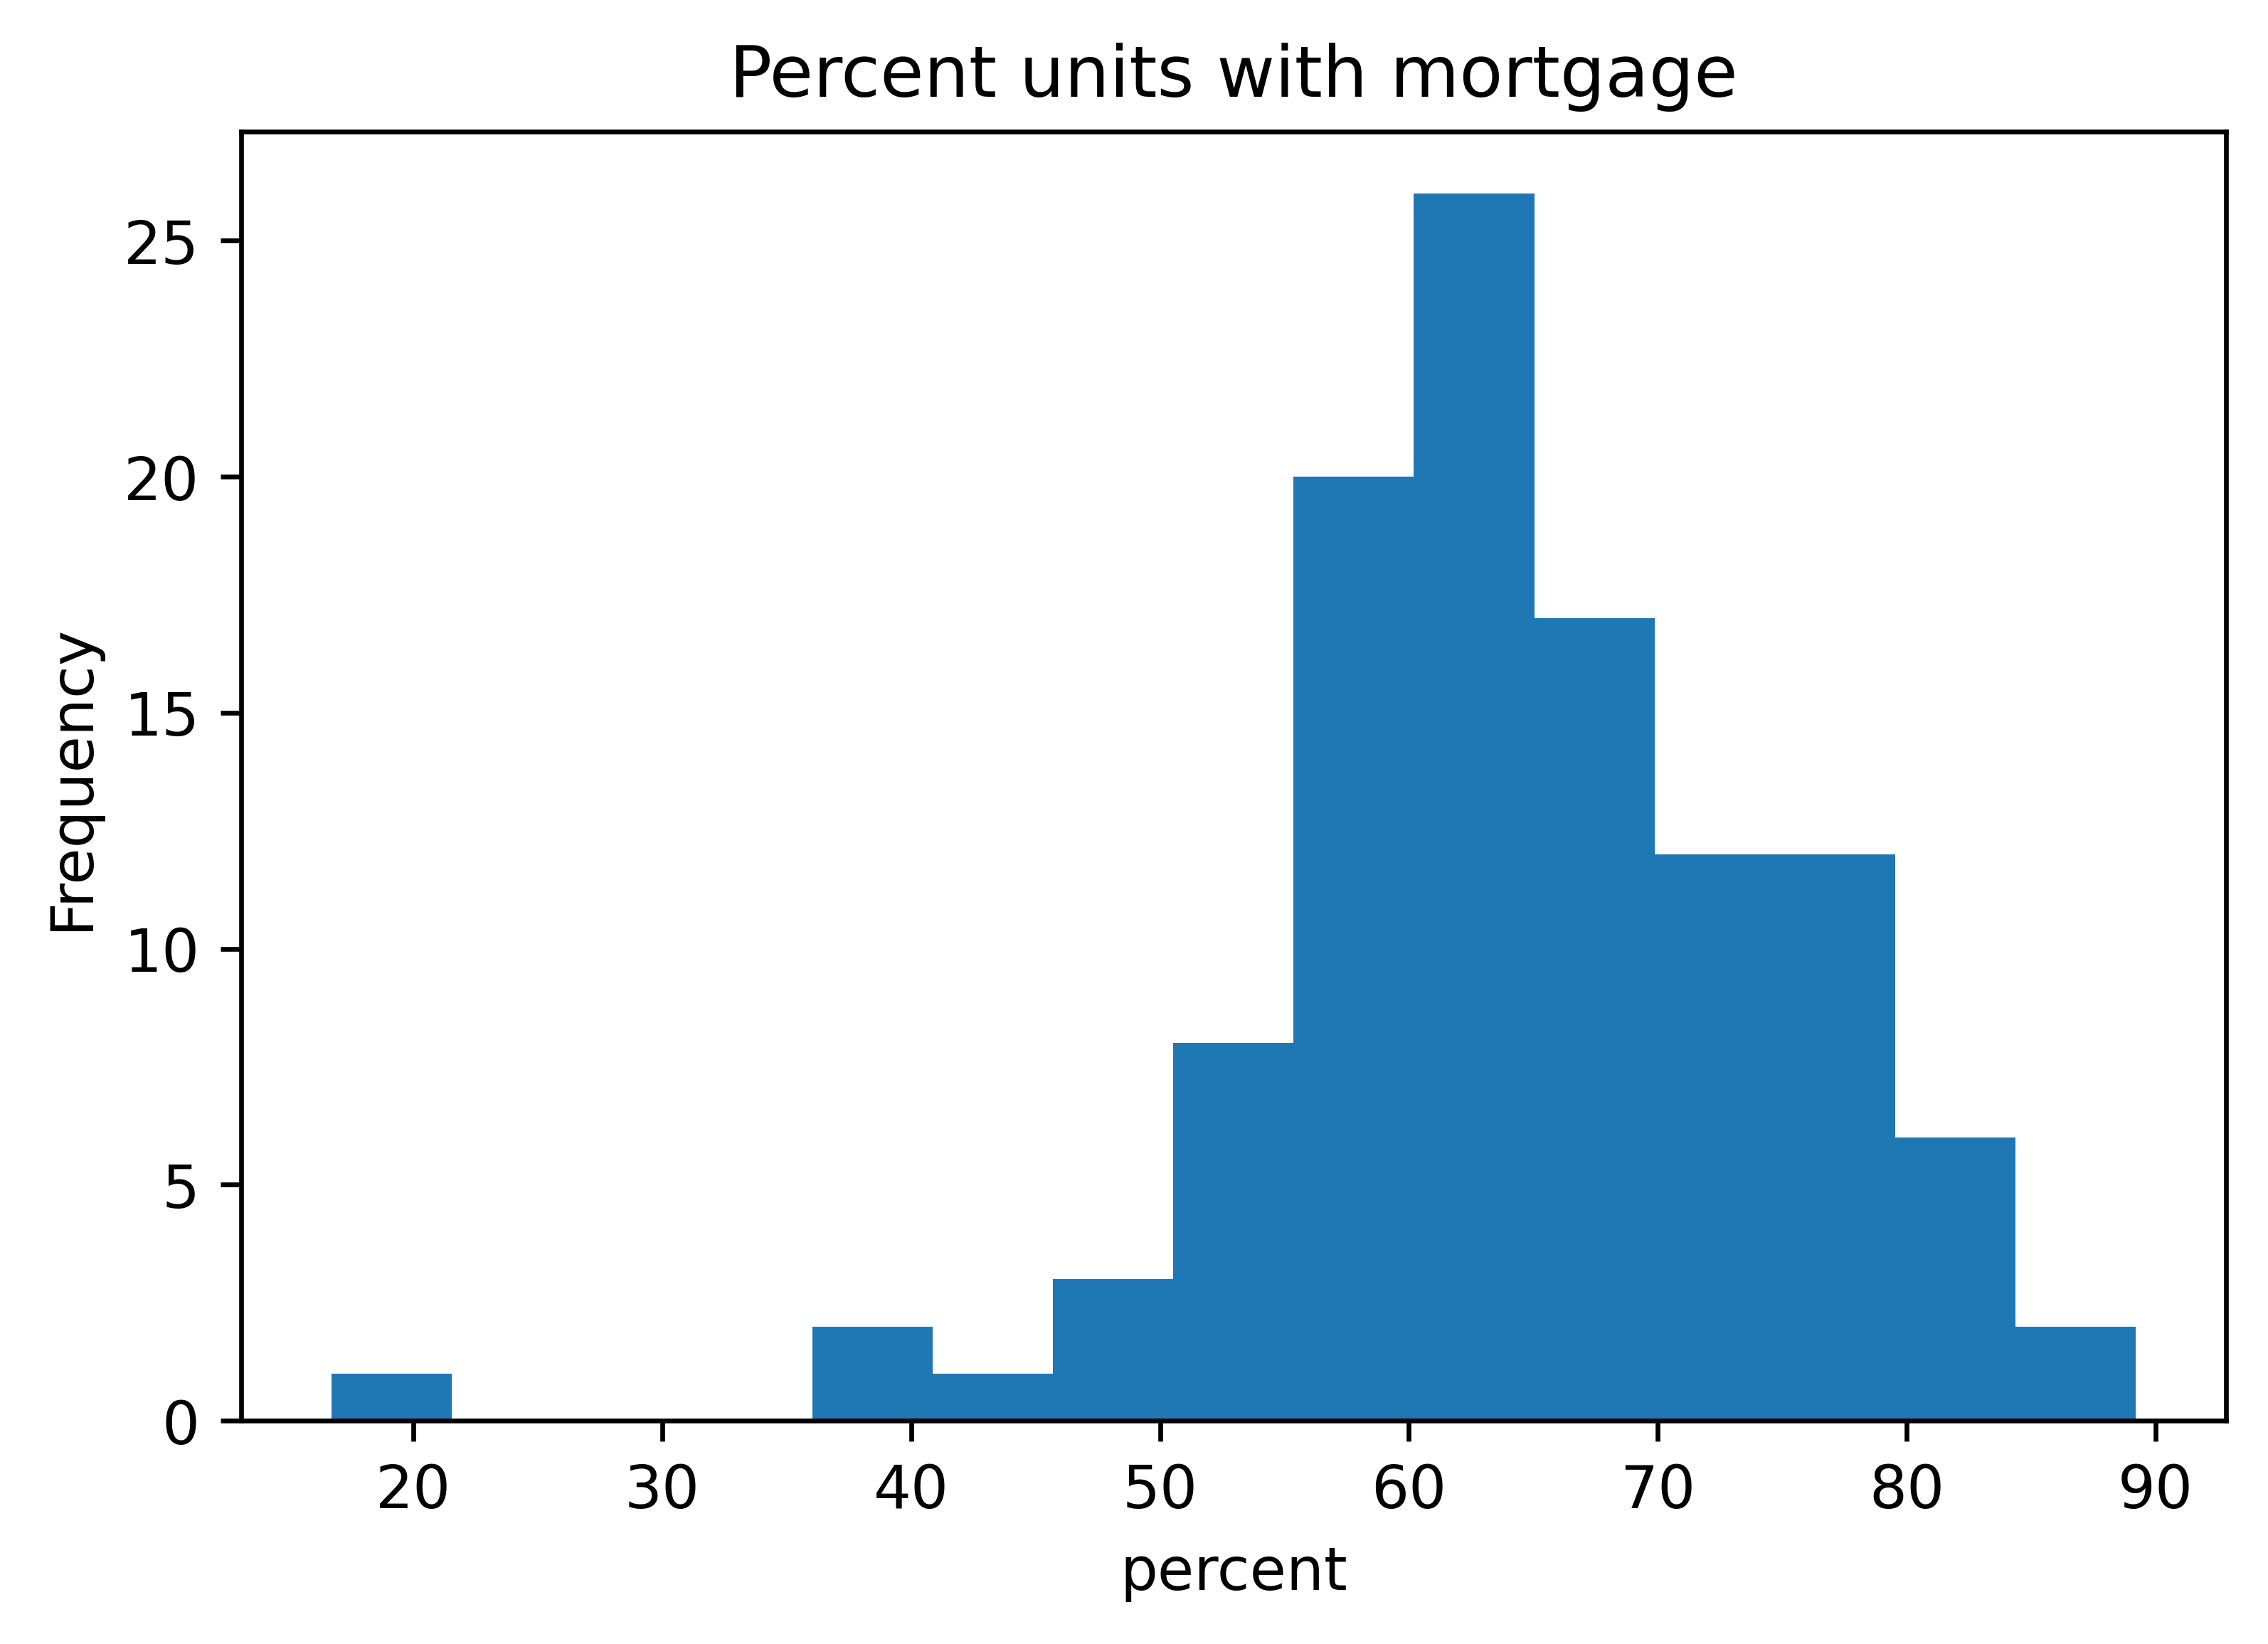

In [141]:
df_cars['pct units mortgage'].plot(kind='hist', bins = 15)
plt.xlabel('percent')
plt.title('Percent units with mortgage')

In [142]:
df_clean = df_cars[df_cars['pct units mortgage'] < 100]
df_clean.shape

(110, 317)

In [143]:
# Save for further use
df_clean.to_csv('chicago_brook-park_neighs_clean3.csv')
df_clean.head()

area  population  avg household size  \
Neighborhood                                                         
Albany Park, Chicago, IL     1.915       45575                 4.8   
Andersonville, Chicago, IL   0.634       14913                 5.0   
Appletree, West Chicago, IL  0.126          25                 3.8   
Armour Square, Chicago, IL   0.526        8279                 2.4   
Auburn Gresham, Chicago, IL  3.740       56648                 6.4   

                             avg number of cars apts  \
Neighborhood                                           
Albany Park, Chicago, IL                         1.1   
Andersonville, Chicago, IL                       0.8   
Appletree, West Chicago, IL                      1.8   
Armour Square, Chicago, IL                       0.5   
Auburn Gresham, Chicago, IL                      0.7   

                             avg number of cars houses    males  \
Neighborhood                                                      
Albany Park, Chicago, IL                           1.4  22787.5   
Andersonville, Chicago, IL                         1.4   7456.5   
Appletree, West Chicago, IL                        2.3     13.0   
Armour Square, Chicago, IL                         1.4   4139.5   
Auburn Gresham, Chicago, IL                        1.6  28324.0   

                             med age females  med age males  \
Neighborhood                                                  
Albany Park, Chicago, IL                38.6           35.5   
Andersonville, Chicago, IL              39.0           40.2   
Appletree, West Chicago, IL             34.5           29.6   
Armour Square, Chicago, IL              47.1           39.2   
Auburn Gresham, Chicago, IL             43.7           35.2   

                             med household income  med rent  ...  Whisky Bar  \
Neighborhood                                                 ...               
Albany Park, Chicago, IL                  65737.0     983.0  ...         0.0   
Andersonville, Chicago, IL                85830.0    1264.0  ...         0.0   
Appletree, West Chicago, IL               81237.0    1107.0  ...         0.0   
Armour Square, Chicago, IL                32295.0     518.0  ...         0.0   
Auburn Gresham, Chicago, IL               40185.0     770.0  ...         0.0   

                             Wine Bar  Wine Shop  Winery  Wings Joint  \
Neighborhood                                                            
Albany Park, Chicago, IL          0.0        0.0     0.0          0.0   
Andersonville, Chicago, IL        0.0        0.0     0.0          0.0   
Appletree, West Chicago, IL       0.0        0.0     0.0          0.0   
Armour Square, Chicago, IL        0.0        0.0     0.0          0.0   
Auburn Gresham, Chicago, IL       0.0        0.0     0.0          0.0   

                             Women's Store  Yoga Studio  Zoo  \
Neighborhood                                                   
Albany Park, Chicago, IL               0.0         0.00  0.0   
Andersonville, Chicago, IL             0.0         0.00  0.0   
Appletree, West Chicago, IL            0.0         0.00  0.0   
Armour Square, Chicago, IL             0.0         0.02  0.0   
Auburn Gresham, Chicago, IL            0.0         0.00  0.0   

                             avg number of cars  med age  
Neighborhood                                              
Albany Park, Chicago, IL                    1.1    37.05  
Andersonville, Chicago, IL                  0.8    39.60  
Appletree, West Chicago, IL                 1.8    32.05  
Armour Square, Chicago, IL                  0.5    43.15  
Auburn Gresham, Chicago, IL                 0.7    39.45  

[5 rows x 317 columns]